In [0]:
import pandas as pd
import numpy as np
import os

import teradatasql

import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from statsmodels.tsa.stattools import adfuller

import itertools
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime,date,timedelta
from dateutil.relativedelta import relativedelta

### Reading Sales Data

In [0]:
df = spark.sql(f'''
        SELECT s.sls_date as SLS_Date, s.GSV as GSV, s.SLS_MRP as SLS_MRP,
               SUM(s.sls_qty) as SLS_Qty, s.site_code as Site_Code
        FROM ABFRL_CATALOG.PFRL_VRDM.sls_summary as s
        LEFT JOIN ABFRL_CATALOG.PFRL_VRDM.sls_marticle as a on s.article_code=a.article_code 
        LEFT JOIN ABFRL_CATALOG.PFRL_VRDM.sls_marticlehierarchy as h on a.mc_code=h.mc_code
        LEFT JOIN ABFRL_CATALOG.PFRL_REPORTS_VIEWS.cube_ag_dg_master as c on a.article_code = c.article_code
        JOIN ABFRL_CATALOG.PFRL_VRDM.sls_msite as st on s.site_code=st.site_code 
        WHERE h.mc_type = ('PT')
        and h.new_simplified_product in ('T-SHIRT')
        and h.new_mc_product_class in ('C/CP') 
        and st.concept in ('PT','PW','PK') 
        and h.new_brand_description='AJILE' 
        and s.bill_type in ('ZPOS','ZRMS','ZBOS','ZOMB','ZOMS','ZBMS') 
        and h.new_world='MEN APPAREL'
        and c.AG not in ('NA', '!_DROPPED')
        group by s.sls_date, s.GSV, s.SLS_MRP, s.site_code;
        ''').toPandas()

In [0]:
columns_to_convert = ['SLS_Qty', 'SLS_MRP', 'GSV']
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df

,SLS_Date,GSV,SLS_MRP,SLS_Qty,Site_Code
0,2019-06-25,208.95,299.0,1.0,P299
1,2022-05-12,339.15,399.0,2.0,P033
2,2022-11-18,314.10,399.0,2.0,P368
3,2020-08-12,299.00,349.0,6.0,P284
4,2020-02-01,299.00,349.0,4.0,P325
...,...,...,...,...,...
1515328,2022-07-23,180.78,349.0,1.0,P048
1515329,2024-09-07,701.34,798.0,4.0,P387
1515330,2024-07-23,399.00,399.0,1.0,P304
1515331,2020-10-26,349.00,349.0,1.0,P406


In [0]:
sales_df = df.copy()
sales_df['SLS_Date'] = pd.to_datetime(sales_df['SLS_Date'])
sales_df.sort_values(by=['SLS_Date'], inplace =True)
sales_df['MD'] = round(((sales_df['SLS_MRP'] - sales_df['GSV'])/sales_df['SLS_MRP'])*100)
sales_df.drop(['SLS_MRP', 'GSV'], inplace=True, axis=1)
sales_df['MD'] = sales_df['MD'].apply(lambda x: 0 if x<0 else x)
sales_df['MD'] = sales_df['MD'].apply(lambda x: 0 if x>100 else x)
sales_df.set_index('SLS_Date',inplace=True)

In [0]:
sales_df

,SLS_Qty,Site_Code,MD
SLS_Date,,,
2018-01-01,1.0,P296,21.0
2018-01-01,1.0,P160,21.0
2018-01-01,1.0,P171,21.0
2018-01-01,2.0,P185,13.0
2018-01-01,2.0,P235,34.0
...,...,...,...
2024-09-18,1.0,P194,18.0
2024-09-18,1.0,P205,21.0
2024-09-18,-2.0,P233,12.0


In [0]:
monthly_df = sales_df.resample('M').agg({ 'Site_Code': 'nunique','SLS_Qty': 'sum', 'MD': 'mean'})
# monthly_df = sales_df.resample('M').agg({'SLS_Qty': 'sum'})
monthly_df = monthly_df[:-1]
monthly_df

,Site_Code,SLS_Qty,MD
SLS_Date,,,
2018-01-31,228,17714.0,13.093746
2018-02-28,237,28968.0,12.548621
2018-03-31,251,61768.0,13.946125
2018-04-30,258,85547.0,12.908783
2018-05-31,259,68688.0,12.579094
...,...,...,...
2024-04-30,410,59697.0,10.460725
2024-05-31,410,54098.0,13.949572
2024-06-30,412,73658.0,22.368421


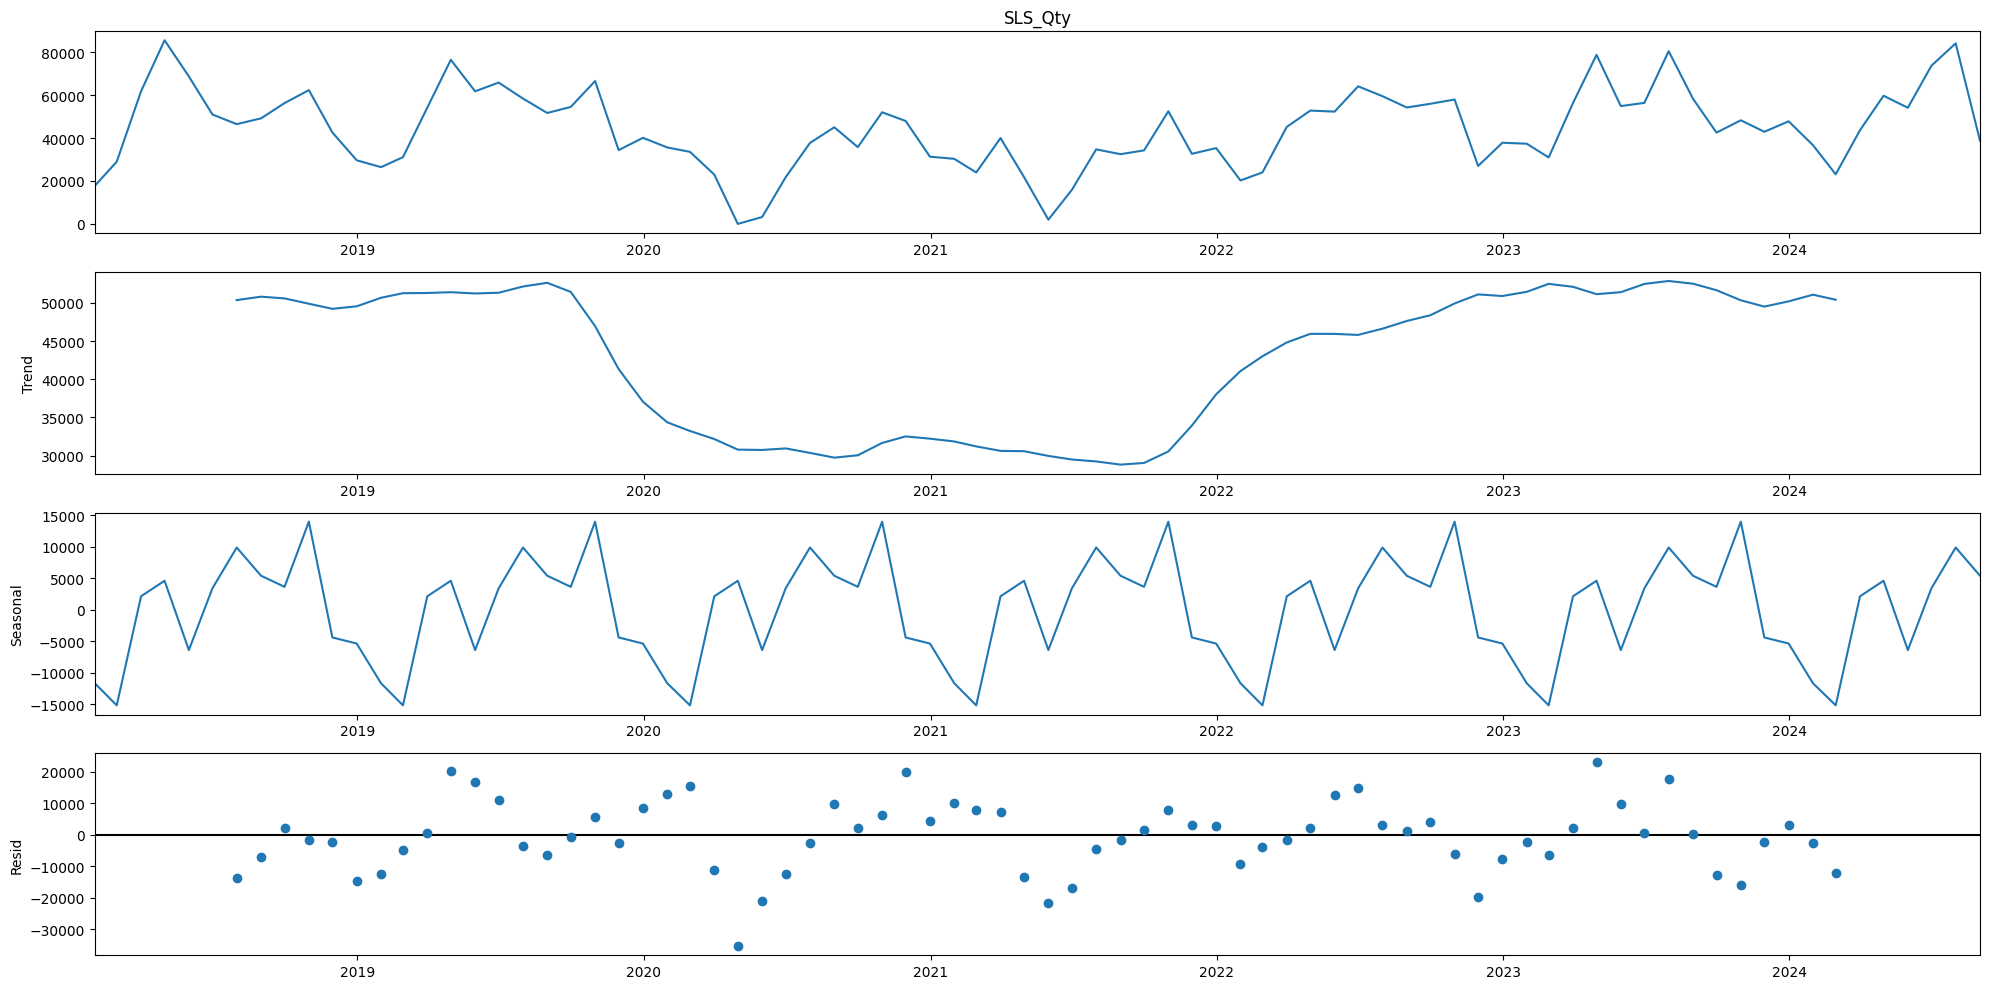

In [0]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(monthly_df.SLS_Qty, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### Monthly Sales Graph

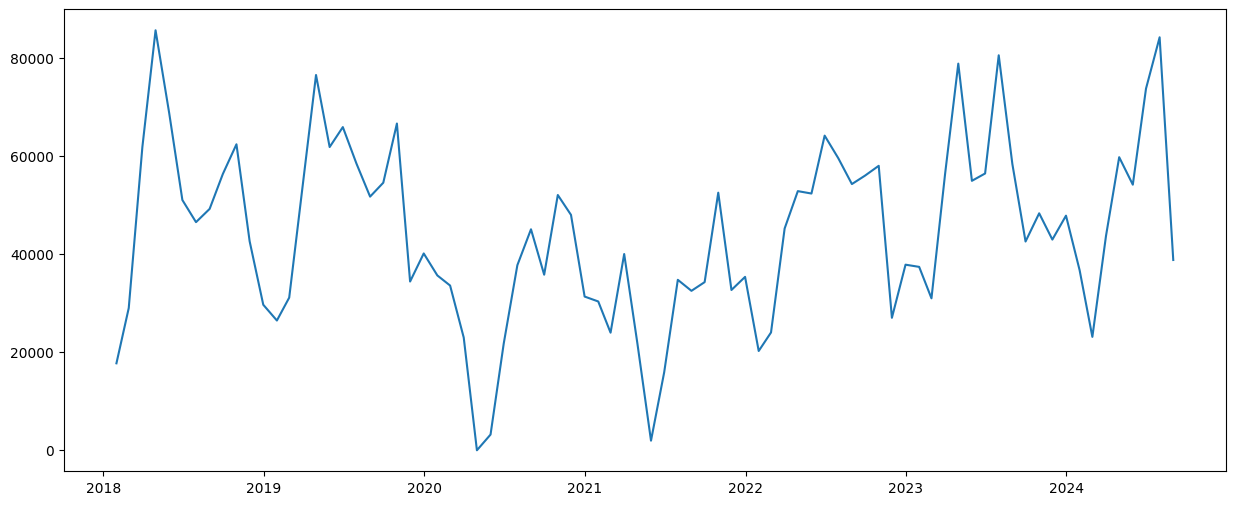

In [0]:
plt.figure(figsize=(15,6))
plt.plot(monthly_df.index,monthly_df['SLS_Qty'])

### EOSS

In [0]:
eoss_df = pd.DataFrame({'SLS_Date':pd.date_range(start=monthly_df.index[0] ,end='2025-03-31',)})

eoss = pd.read_csv('/Workspace/Users/swayam.sharma@abfrl.adityabirla.com/EOSS_Dates.csv')
eoss.columns = ['date','EOSS']
eoss['date'] = pd.to_datetime(eoss['date'])
eoss=eoss[eoss['date']>='2018-01-01']

eoss_df = (eoss_df.merge(eoss, left_on='SLS_Date', right_on='date',how='left'))
eoss_df.drop('date',inplace=True,axis=1)
eoss_df['EOSS'] = eoss_df['EOSS'].fillna(0)
eoss_df.set_index('SLS_Date',inplace=True)

eoss_df.loc[(eoss_df.index >= '2023-06-28') & (eoss_df.index <= '2023-07-31'), 'EOSS'] = 1
eoss_df.loc[(eoss_df.index >= '2023-12-20') & (eoss_df.index <= '2024-01-28'), 'EOSS'] = 1

eoss_df.loc[(eoss_df.index >= '2024-06-28') & (eoss_df.index <= '2024-07-31'), 'EOSS'] = 1
eoss_df.loc[(eoss_df.index >= '2024-12-20') & (eoss_df.index <= '2025-01-31'), 'EOSS'] = 1

# Set EOSS to 1 for specific date ranges for EOSS winter and summer
eoss_df['EOSS_winter'] = 0
eoss_df.loc[(eoss_df['EOSS'] == 1) & ((eoss_df.index.month ==12) | (eoss_df.index.month ==1)), 'EOSS_winter'] = 1
eoss_df['EOSS_summer'] = 0
eoss_df.loc[(eoss_df['EOSS'] == 1) & ((eoss_df.index.month == 6) | (eoss_df.index.month == 7)), 'EOSS_summer'] = 1

eoss_df.drop('EOSS', axis=1, inplace= True)

### COVID

In [0]:
def is_covid(dt):
    year_month={
    2020:[3,4,5,6,7],
    2021:[4,5,6,7],
    }

    if year_month.get(dt.year) and dt.month in year_month.get(dt.year):
        return 1
    return 0
eoss_df['covid'] = eoss_df.index.map(lambda dt:is_covid(dt))

### FESTIVE

In [0]:
def is_festive(dt):
    year_month={
    2018:[10,11],
    2019:[9,10],
    2020:[10,11],
    2021:[10,11],
    2022:[9,10],
    2023:[10,11],
    2024:[9,10],  
    }

    if year_month.get(dt.year) and dt.month in year_month.get(dt.year):
        return 1
    return 0
eoss_df['Festive'] = eoss_df.index.map(lambda dt:is_festive(dt))

In [0]:
# SUMMER REG

In [0]:
# def sum_reg(dt):
#     year_month={
#     2018:[3,4,5,6,7],
#     2019:[3,4,5,6,7],
#     2020:[3,6,7],
#     2021:[3,4,6,7],
#     2022:[3,4,5,6,7],
#     2023:[3,4,5,6,7],
#     2024:[3,4,5,6,7],
#     }

#     if year_month.get(dt.year) and dt.month in year_month.get(dt.year):
#         return 1
#     return 0
# eoss_df['Summer Reg'] = eoss_df.index.map(lambda dt:sum_reg(dt))

In [0]:
eoss_df = eoss_df.resample('M').sum()

In [0]:
# eoss_df['EOSS_winter'] = np.round(eoss_df['EOSS_winter']/eoss_df.index.day,2)
# eoss_df['EOSS_summer'] = np.round(eoss_df['EOSS_summer']/eoss_df.index.day,2)
# eoss_df['covid'] = np.round(eoss_df['covid']/eoss_df.index.day,2)
# eoss_df['Festive'] = np.round(eoss_df['Festive']/eoss_df.index.day,2)

In [0]:
monthly_grouped_df = (eoss_df.merge(monthly_df, right_on='SLS_Date', left_on=eoss_df.index ,how='left'))

In [0]:
monthly_grouped_df.set_index('SLS_Date', inplace=True)

In [0]:
monthly_grouped_df

,EOSS_winter,EOSS_summer,covid,Festive,Site_Code,SLS_Qty,MD
SLS_Date,,,,,,,
2018-01-31,1,0,0,0,228.0,17714.0,13.093746
2018-02-28,0,0,0,0,237.0,28968.0,12.548621
2018-03-31,0,0,0,0,251.0,61768.0,13.946125
2018-04-30,0,0,0,0,258.0,85547.0,12.908783
2018-05-31,0,0,0,0,259.0,68688.0,12.579094
...,...,...,...,...,...,...,...
2024-11-30,0,0,0,0,NaN,NaN,NaN
2024-12-31,12,0,0,0,NaN,NaN,NaN
2025-01-31,31,0,0,0,NaN,NaN,NaN


In [0]:
grouped_df = monthly_grouped_df[monthly_grouped_df.index >= '2021-08-01']

In [0]:
def fill_future_with_avg(df):
    col_name = df.index[0]
    if pd.isna(df[col_name]):
      current_month = df.name.strftime('%m')
      return (grouped_df[grouped_df[col_name].index.strftime('%m')==current_month][col_name][:-1].mean())
    else:
      return df[0]

In [0]:
col_fill = ['MD']

In [0]:
for cols in col_fill:
  monthly_grouped_df[cols] = monthly_grouped_df[[cols]].apply(fill_future_with_avg, axis=1)

In [0]:
monthly_grouped_df

,EOSS_winter,EOSS_summer,covid,Festive,Site_Code,SLS_Qty,MD
SLS_Date,,,,,,,
2018-01-31,1,0,0,0,228.0,17714.0,13.093746
2018-02-28,0,0,0,0,237.0,28968.0,12.548621
2018-03-31,0,0,0,0,251.0,61768.0,13.946125
2018-04-30,0,0,0,0,258.0,85547.0,12.908783
2018-05-31,0,0,0,0,259.0,68688.0,12.579094
...,...,...,...,...,...,...,...
2024-11-30,0,0,0,0,NaN,NaN,18.324029
2024-12-31,12,0,0,0,NaN,NaN,26.426303
2025-01-31,31,0,0,0,NaN,NaN,21.174369


### Adding No. of Stores

In [0]:
mapping_df = pd.DataFrame({
    'SLS_Date': ['2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31', '2025-02-28', '2025-03-31'],
    'Site_Code': [416, 415, 415, 416, 416, 418, 422]
})
mapping_df['SLS_Date'] = pd.to_datetime(mapping_df['SLS_Date'])
mapping_df

,SLS_Date,Site_Code
0,2024-09-30,416
1,2024-10-31,415
2,2024-11-30,415
3,2024-12-31,416
4,2025-01-31,416
5,2025-02-28,418
6,2025-03-31,422


In [0]:
# Merge the mapping DataFrame with the original DataFrame
monthly_grouped_df = monthly_grouped_df.merge(mapping_df, on='SLS_Date', how='left', suffixes=('', '_y'))

In [0]:
# Fill NaN values in Site_Code with the mapped values
monthly_grouped_df['Site_Code'].fillna(monthly_grouped_df['Site_Code_y'], inplace=True)

In [0]:
# Drop the extra column created by the merge
monthly_grouped_df.drop(columns=['Site_Code_y'], inplace=True)

In [0]:
monthly_grouped_df.fillna(0, inplace= True)
monthly_grouped_df.tail(20)

,SLS_Date,EOSS_winter,EOSS_summer,covid,Festive,Site_Code,SLS_Qty,MD
67,2023-08-31,0,0,0,0,431.0,58310.0,9.274625
68,2023-09-30,0,0,0,0,432.0,42522.0,5.323528
69,2023-10-31,0,0,0,31,434.0,48269.0,8.898792
70,2023-11-30,0,0,0,30,436.0,42915.0,10.041966
71,2023-12-31,12,0,0,0,436.0,47787.0,24.145780
72,2024-01-31,28,0,0,0,435.0,36683.0,24.793154
73,2024-02-29,0,0,0,0,432.0,23102.0,5.662003
74,2024-03-31,0,0,0,0,423.0,43661.0,8.910127
75,2024-04-30,0,0,0,0,410.0,59697.0,10.460725
76,2024-05-31,0,0,0,0,410.0,54098.0,13.949572


In [0]:
monthly_grouped_df.set_index('SLS_Date', inplace=True)

In [0]:
monthly_grouped_df

,EOSS_winter,EOSS_summer,covid,Festive,Site_Code,SLS_Qty,MD
SLS_Date,,,,,,,
2018-01-31,1,0,0,0,228.0,17714.0,13.093746
2018-02-28,0,0,0,0,237.0,28968.0,12.548621
2018-03-31,0,0,0,0,251.0,61768.0,13.946125
2018-04-30,0,0,0,0,258.0,85547.0,12.908783
2018-05-31,0,0,0,0,259.0,68688.0,12.579094
...,...,...,...,...,...,...,...
2024-11-30,0,0,0,0,415.0,0.0,18.324029
2024-12-31,12,0,0,0,416.0,0.0,26.426303
2025-01-31,31,0,0,0,416.0,0.0,21.174369


## SARIMAX

In [0]:
#Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(monthly_grouped_df['SLS_Qty'][:-8], autolag= 'AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -3.478199
p-value                         0.008565
#Lags Used                      3.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


In [0]:
# from statsmodels.graphics.tsaplots import plot_acf
# plt.figure(figsize=(20,5))
# plt.grid()
# plot_acf(monthly_grouped_df['SLS_Qty'][:-7], ax=plt.gca(), lags = 15)
# plt.show()

In [0]:
# from statsmodels.graphics.tsaplots import plot_pacf
# plt.figure(figsize=(20,5))
# plt.grid()
# plot_pacf(monthly_grouped_df['SLS_Qty'][:-7], ax=plt.gca(), lags = 15)
# plt.show()

In [0]:
monthly_df = monthly_grouped_df[['SLS_Qty']]
regressors_df = monthly_grouped_df.drop('SLS_Qty', axis=1)

In [0]:
 # Min Max Scaling
from sklearn.preprocessing import MinMaxScaler

scaler_sales = MinMaxScaler()
scaled_sales = scaler_sales.fit_transform(monthly_df)
sales = pd.DataFrame(scaled_sales, columns=monthly_df.columns, index=monthly_df.index)

scaler_regressors = MinMaxScaler()
scaled_regressors = scaler_regressors.fit_transform(regressors_df)
regressors = pd.DataFrame(scaled_regressors, columns=regressors_df.columns, index=regressors_df.index)

In [0]:
# Split data into train / test sets
# sales_train,sales_test = monthly_df[monthly_df.index<='2023-05-31'],monthly_df[monthly_df.index>'2023-05-31']
# reg_train,reg_test = regressors_df[regressors_df.index<='2023-05-31'],regressors_df[regressors_df.index>'2023-05-31']

# Split data into train / test sets
sales_train,sales_test = sales[sales.index<='2024-03-31'],sales[sales.index>'2024-03-31']
reg_train,reg_test = regressors[regressors.index<='2024-03-31'],regressors[regressors.index>'2024-03-31']

### OPTUNA to find best order

In [0]:
reg_test_optuna = reg_test[reg_test.index <= '2024-08-31']
sales_test_optuna = sales_test[sales_test.index <= '2024-08-31']

In [0]:
sales_test_optuna

,SLS_Qty
SLS_Date,
2024-04-30,0.697827
2024-05-31,0.632378
2024-06-30,0.861024
2024-07-31,0.983272
2024-08-31,0.453061


In [0]:
p = q = range(0, 4)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [0]:
%%capture
%%time
def objective_sarima(trial):
    order=trial.suggest_categorical('order',pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
    try:
        model = SARIMAX(sales_train['SLS_Qty'], 
                    order = order, 
                    seasonal_order = seasonal_order,
                    exog = reg_train
                    ).fit()
        start = len(sales_train)
        end = len(sales_train) + 5
        
        predictions = model.predict(start, end,
                                    typ = 'levels', exog = reg_test_optuna).to_frame()

        residuals = np.abs(sales_test_optuna['SLS_Qty'] - predictions['predicted_mean']).to_frame()
        mape  = (residuals[0]/sales_test_optuna['SLS_Qty'])*100
        mape=mape[-12:].mean()
        return mape
    except:
        return 999
study=optuna.create_study(direction="minimize")
study.optimize(objective_sarima,n_trials=250);

[I 2024-09-19 10:38:02,396] A new study created in memory with name: no-name-9b686b94-1aca-4da9-b1f6-2e75e092ff71
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34475D-01    |proj g|=  6.37410D-01

At iterate    5    f= -7.26640D-01    |proj g|=  1.23037D+00

At iterate   10    f= -8.18455D-01    |proj g|=  2.15162D-01

At iterate   15    f= -8.32688D-01    |proj g|=  4.09525D-01

At iterate   20    f= -8.38238D-01    |proj g|=  1.82451D-02

At iterate   25    f= -8.38962D-01    |proj g|=  1.13495D-02

At iterate   30    f= -8.39003D-01    |proj g|=  1.11704D-02

At iterate   35    f= -8.39050D-01    |proj g|=  3.05638D-03

At iterate   40    f= -8.39054D-01    |proj g|=  8.80583D-04

At iterate   45    f= -8.39055D-01    |proj g|=  5.01683D-04


[I 2024-09-19 10:38:04,082] Trial 0 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.39055D-01    |proj g|=  2.16118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   2.161D-03  -8.391D-01
  F = -0.83905532300563535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.64215D-01    |proj g|=  1.95316D+00


 This problem is unconstrained.



At iterate    5    f= -7.61173D-01    |proj g|=  5.62970D-01

At iterate   10    f= -7.98738D-01    |proj g|=  2.08344D-01

At iterate   15    f= -8.25561D-01    |proj g|=  1.37724D-01

At iterate   20    f= -8.40571D-01    |proj g|=  3.10315D-02

At iterate   25    f= -8.41537D-01    |proj g|=  3.01193D-02

At iterate   30    f= -8.41878D-01    |proj g|=  1.11200D-02

At iterate   35    f= -8.42643D-01    |proj g|=  2.86745D-02

At iterate   40    f= -8.46096D-01    |proj g|=  4.05450D-02

At iterate   45    f= -8.47391D-01    |proj g|=  9.92667D-02


[I 2024-09-19 10:38:06,226] Trial 1 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.49348D-01    |proj g|=  2.95032D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   2.950D-02  -8.493D-01
  F = -0.84934833332720183     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.50229D-01    |proj g|=  5.39000D-01


 This problem is unconstrained.



At iterate    5    f= -7.84365D-01    |proj g|=  5.05350D-01

At iterate   10    f= -7.99758D-01    |proj g|=  7.99049D-02

At iterate   15    f= -8.01043D-01    |proj g|=  4.93127D-03

At iterate   20    f= -8.01095D-01    |proj g|=  2.23955D-03

At iterate   25    f= -8.01104D-01    |proj g|=  1.57434D-03

At iterate   30    f= -8.01111D-01    |proj g|=  1.35405D-03

At iterate   35    f= -8.01133D-01    |proj g|=  1.34766D-02

At iterate   40    f= -8.01201D-01    |proj g|=  3.82406D-03

At iterate   45    f= -8.01227D-01    |proj g|=  3.64147D-03


[I 2024-09-19 10:38:09,167] Trial 2 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.01258D-01    |proj g|=  2.87606D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   2.876D-02  -8.013D-01
  F = -0.80125782215939434     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.31383D-01    |proj g|=  5.05286D-01

At iterate    5    f= -7.65486D-01    |proj g|=  1.79095D-01

At iterate   10    f= -8.28150D-01    |proj g|=  2.31967D-01

At iterate   15    f= -8.38520D-01    |proj g|=  2.36125D-01

At iterate   20    f= -8.44887D-01    |proj g|=  5.46819D-02

At iterate   25    f= -8.45839D-01    |proj g|=  3.70938D-02

At iterate   30    f= -8.46374D-01    |proj g|=  1.96628D-02

At iterate   35    f= -8.46596D-01    |proj g|=  5.34720D-02

At iterate   40    f= -8.46755D-01    |proj g|=  2.08252D-02

At iterate   45    f= -8.46888D-01    |proj g|=  1.25578D-02

At iterate   50    f= -8.47067D-01    |proj g|=  3.93685D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:38:16,582] Trial 3 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.93363D-01    |proj g|=  2.82002D+00

At iterate    5    f= -7.45786D-01    |proj g|=  8.87390D-01

At iterate   10    f= -7.99117D-01    |proj g|=  2.22879D-01

At iterate   15    f= -8.01371D-01    |proj g|=  3.72225D-02

At iterate   20    f= -8.01824D-01    |proj g|=  9.82410D-03

At iterate   25    f= -8.01904D-01    |proj g|=  1.48058D-02

At iterate   30    f= -8.01942D-01    |proj g|=  1.11065D-02

At iterate   35    f= -8.02116D-01    |proj g|=  8.59853D-03

At iterate   40    f= -8.03700D-01    |proj g|=  1.64903D-01

At iterate   45    f= -8.22446D-01    |proj g|=  1.01518D+00


[I 2024-09-19 10:38:20,255] Trial 4 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.43232D-01    |proj g|=  9.35981D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   9.360D-02  -8.432D-01
  F = -0.84323172864955576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.71928D-01    |proj g|=  1.13607D+00


 This problem is unconstrained.



At iterate    5    f= -7.84612D-01    |proj g|=  4.48252D-01

At iterate   10    f= -7.98425D-01    |proj g|=  1.17887D-01

At iterate   15    f= -8.03789D-01    |proj g|=  4.93950D-02

At iterate   20    f= -8.09568D-01    |proj g|=  4.01587D-02

At iterate   25    f= -8.14058D-01    |proj g|=  1.73957D-01

At iterate   30    f= -8.14652D-01    |proj g|=  8.12577D-02

At iterate   35    f= -8.15437D-01    |proj g|=  9.92910D-02

At iterate   40    f= -8.16184D-01    |proj g|=  8.41875D-02

At iterate   45    f= -8.16325D-01    |proj g|=  1.28497D-02


[I 2024-09-19 10:38:22,209] Trial 5 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.16349D-01    |proj g|=  3.04252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   3.043D-03  -8.163D-01
  F = -0.81634921814907691     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11575D-01    |proj g|=  4.83498D-01


 This problem is unconstrained.



At iterate    5    f= -7.40080D-01    |proj g|=  4.03140D-01

At iterate   10    f= -7.61589D-01    |proj g|=  2.12569D-01

At iterate   15    f= -7.64371D-01    |proj g|=  4.09988D-02

At iterate   20    f= -7.65749D-01    |proj g|=  2.63857D-02

At iterate   25    f= -7.65959D-01    |proj g|=  4.81217D-02

At iterate   30    f= -7.66135D-01    |proj g|=  1.91708D-02

At iterate   35    f= -7.66305D-01    |proj g|=  2.49199D-02

At iterate   40    f= -7.67185D-01    |proj g|=  1.66449D-02

At iterate   45    f= -7.68694D-01    |proj g|=  6.75505D-02


[I 2024-09-19 10:38:24,232] Trial 6 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.69788D-01    |proj g|=  2.38848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   2.388D-02  -7.698D-01
  F = -0.76978803492085246     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.10102D-01    |proj g|=  1.27308D+00


 This problem is unconstrained.



At iterate    5    f= -7.43341D-01    |proj g|=  1.58586D+00

At iterate   10    f= -7.86656D-01    |proj g|=  6.45012D-02

At iterate   15    f= -7.97014D-01    |proj g|=  7.03497D-02

At iterate   20    f= -7.98722D-01    |proj g|=  1.67508D-02

At iterate   25    f= -7.99580D-01    |proj g|=  2.84114D-02

At iterate   30    f= -7.99787D-01    |proj g|=  2.18489D-02

At iterate   35    f= -7.99814D-01    |proj g|=  3.48356D-03

At iterate   40    f= -7.99831D-01    |proj g|=  1.45715D-03

At iterate   45    f= -7.99834D-01    |proj g|=  3.11709D-03


[I 2024-09-19 10:38:29,352] Trial 7 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.99837D-01    |proj g|=  2.58263D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   2.583D-03  -7.998D-01
  F = -0.79983699432541788     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.26248D-01    |proj g|=  4.95092D-01

At iterate    5    f= -7.65065D-01    |proj g|=  2.89938D-01

At iterate   10    f= -8.19306D-01    |proj g|=  6.64888D-02

At iterate   15    f= -8.29342D-01    |proj g|=  1.36089D-01

At iterate   20    f= -8.36708D-01    |proj g|=  1.87115D-02

At iterate   25    f= -8.37844D-01    |proj g|=  1.07340D-02

At iterate   30    f= -8.38099D-01    |proj g|=  1.96688D-02

At iterate   35    f= -8.38340D-01    |proj g|=  3.01945D-02

At iterate   40    f= -8.38648D-01    |proj g|=  1.24562D-02

At iterate   45    f= -8.38703D-01    |proj g|=  1.75594D-02


[I 2024-09-19 10:38:32,265] Trial 8 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.38744D-01    |proj g|=  1.38776D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57      1     0     0   1.388D-02  -8.387D-01
  F = -0.83874360769999134     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.50630D-01    |proj g|=  2.25199D+00


 This problem is unconstrained.



At iterate    5    f= -6.15326D-01    |proj g|=  2.63942D+00

At iterate   10    f= -7.74732D-01    |proj g|=  4.83102D-01

At iterate   15    f= -8.04508D-01    |proj g|=  1.65111D-01

At iterate   20    f= -8.25697D-01    |proj g|=  2.75135D-01

At iterate   25    f= -8.33903D-01    |proj g|=  2.29381D-01

At iterate   30    f= -8.36578D-01    |proj g|=  4.82337D-02

At iterate   35    f= -8.38771D-01    |proj g|=  7.05696D-02

At iterate   40    f= -8.39795D-01    |proj g|=  2.29033D-02

At iterate   45    f= -8.39846D-01    |proj g|=  7.36837D-03


[I 2024-09-19 10:38:34,295] Trial 9 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.39850D-01    |proj g|=  3.88046D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   3.880D-03  -8.398D-01
  F = -0.83984995896319059     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.62143D-01    |proj g|=  4.03700D-01


 This problem is unconstrained.



At iterate    5    f= -7.80566D-01    |proj g|=  1.27175D-01

At iterate   10    f= -8.12462D-01    |proj g|=  3.80176D-02

At iterate   15    f= -8.14259D-01    |proj g|=  3.26609D-02

At iterate   20    f= -8.15570D-01    |proj g|=  3.82587D-02

At iterate   25    f= -8.15978D-01    |proj g|=  4.69576D-02

At iterate   30    f= -8.16059D-01    |proj g|=  3.69434D-02

At iterate   35    f= -8.16089D-01    |proj g|=  2.38139D-02

At iterate   40    f= -8.16107D-01    |proj g|=  4.38449D-03

At iterate   45    f= -8.16127D-01    |proj g|=  4.09146D-03


[I 2024-09-19 10:38:38,278] Trial 10 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.16172D-01    |proj g|=  3.77426D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     56      1     0     0   3.774D-02  -8.162D-01
  F = -0.81617152719400576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34475D-01    |proj g|=  6.37410D-01


 This problem is unconstrained.



At iterate    5    f= -8.14189D-01    |proj g|=  3.52231D-01

At iterate   10    f= -8.61428D-01    |proj g|=  1.10630D-01

At iterate   15    f= -9.04855D-01    |proj g|=  2.83356D-01

At iterate   20    f= -9.09080D-01    |proj g|=  7.38897D-02

At iterate   25    f= -9.11396D-01    |proj g|=  1.66000D-01

At iterate   30    f= -9.12139D-01    |proj g|=  1.34903D-02

At iterate   35    f= -9.12911D-01    |proj g|=  1.06151D-02

At iterate   40    f= -9.13099D-01    |proj g|=  2.37826D-02

At iterate   45    f= -9.13765D-01    |proj g|=  6.77479D-02

At iterate   50    f= -9.14705D-01    |proj g|=  2.22284D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:38:40,240] Trial 11 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94829D-01    |proj g|=  1.97055D+00

At iterate    5    f= -7.17423D-01    |proj g|=  6.93614D-01

At iterate   10    f= -7.53116D-01    |proj g|=  2.81279D-01

At iterate   15    f= -7.65908D-01    |proj g|=  2.57879D-02

At iterate   20    f= -7.67073D-01    |proj g|=  3.96382D-02

At iterate   25    f= -7.67487D-01    |proj g|=  7.86017D-03

At iterate   30    f= -7.67540D-01    |proj g|=  2.80611D-03

At iterate   35    f= -7.67560D-01    |proj g|=  8.54760D-03

At iterate   40    f= -7.67599D-01    |proj g|=  2.32509D-02

At iterate   45    f= -7.67646D-01    |proj g|=  6.57580D-03


[I 2024-09-19 10:38:45,627] Trial 12 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.67708D-01    |proj g|=  9.69960D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     61      1     0     0   9.700D-03  -7.677D-01
  F = -0.76770770225974805     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76633D-01    |proj g|=  6.46202D-01

At iterate    5    f= -6.93743D-01    |proj g|=  7.64434D-01

At iterate   10    f= -7.29681D-01    |proj g|=  3.86510D-01

At iterate   15    f= -7.42650D-01    |proj g|=  1.06366D-01

At iterate   20    f= -7.45139D-01    |proj g|=  3.64116D-02

At iterate   25    f= -7.45812D-01    |proj g|=  2.24710D-02

At iterate   30    f= -7.45925D-01    |proj g|=  4.48825D-03

At iterate   35    f= -7.45936D-01    |proj g|=  1.25553D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
[I 2024-09-19 10:38:47,128] Trial 13 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     64      1     0     0   1.058D-03  -7.459D-01
  F = -0.74593564869992368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.85153D-01    |proj g|=  1.90683D+00


 This problem is unconstrained.



At iterate    5    f= -7.65156D-01    |proj g|=  7.04683D-01

At iterate   10    f= -8.30559D-01    |proj g|=  1.17434D+00

At iterate   15    f= -8.64087D-01    |proj g|=  5.05079D-01

At iterate   20    f= -8.93644D-01    |proj g|=  1.42394D-01

At iterate   25    f= -9.02123D-01    |proj g|=  1.40392D-01

At iterate   30    f= -9.22840D-01    |proj g|=  4.19608D-01

At iterate   35    f= -9.26622D-01    |proj g|=  5.33942D-02

At iterate   40    f= -9.27721D-01    |proj g|=  1.05201D-01

At iterate   45    f= -9.29155D-01    |proj g|=  9.61155D-02


[I 2024-09-19 10:38:49,372] Trial 14 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.30055D-01    |proj g|=  1.31409D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     62      1     0     0   1.314D-01  -9.301D-01
  F = -0.93005463402969513     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.13516D-01    |proj g|=  2.65682D+00


 This problem is unconstrained.



At iterate    5    f= -7.12227D-01    |proj g|=  3.72709D-01

At iterate   10    f= -8.37132D-01    |proj g|=  1.21874D+00

At iterate   15    f= -8.56044D-01    |proj g|=  3.10237D-01

At iterate   20    f= -8.60619D-01    |proj g|=  1.38811D-01

At iterate   25    f= -8.63141D-01    |proj g|=  2.95076D-01

At iterate   30    f= -8.65310D-01    |proj g|=  2.14212D-01

At iterate   35    f= -8.66480D-01    |proj g|=  5.04505D-02

At iterate   40    f= -8.68282D-01    |proj g|=  1.16459D-01

At iterate   45    f= -8.70529D-01    |proj g|=  8.98072D-02


[I 2024-09-19 10:38:52,891] Trial 15 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.71972D-01    |proj g|=  2.78212D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   2.782D-02  -8.720D-01
  F = -0.87197195525097493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.48759D-01    |proj g|=  1.88917D+00


 This problem is unconstrained.



At iterate    5    f= -7.52390D-01    |proj g|=  8.72166D-01

At iterate   10    f= -7.96706D-01    |proj g|=  1.10782D+00

At iterate   15    f= -8.18023D-01    |proj g|=  4.78020D-01

At iterate   20    f= -8.28394D-01    |proj g|=  5.66802D-02

At iterate   25    f= -8.47465D-01    |proj g|=  3.62749D-01

At iterate   30    f= -8.65822D-01    |proj g|=  9.39701D-02

At iterate   35    f= -8.82261D-01    |proj g|=  6.24822D-01

At iterate   40    f= -8.85464D-01    |proj g|=  3.39003D-01

At iterate   45    f= -8.87265D-01    |proj g|=  5.70983D-02


[I 2024-09-19 10:38:56,223] Trial 16 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.87491D-01    |proj g|=  1.53313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     61      1     0     0   1.533D-02  -8.875D-01
  F = -0.88749096217092849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.51622D-01    |proj g|=  5.45342D-01


 This problem is unconstrained.



At iterate    5    f= -7.85941D-01    |proj g|=  2.54790D-01

At iterate   10    f= -8.50801D-01    |proj g|=  1.43565D-01

At iterate   15    f= -8.65849D-01    |proj g|=  5.11084D-02

At iterate   20    f= -8.77975D-01    |proj g|=  1.64224D-01

At iterate   25    f= -9.01967D-01    |proj g|=  5.32914D-01

At iterate   30    f= -9.10413D-01    |proj g|=  2.56164D-01

At iterate   35    f= -9.18041D-01    |proj g|=  1.99020D-02

At iterate   40    f= -9.18084D-01    |proj g|=  2.17971D-02

At iterate   45    f= -9.18186D-01    |proj g|=  8.03076D-03


[I 2024-09-19 10:38:59,113] Trial 17 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.18507D-01    |proj g|=  2.71879D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   2.719D-02  -9.185D-01
  F = -0.91850697687904248     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.47037D-01    |proj g|=  2.96379D+00

At iterate    5    f= -8.46183D-01    |proj g|=  2.13868D+00

At iterate   10    f= -8.86211D-01    |proj g|=  1.19927D+00

At iterate   15    f= -9.32417D-01    |proj g|=  4.26301D-01

At iterate   20    f= -9.38672D-01    |proj g|=  1.19526D-01

At iterate   25    f= -9.45235D-01    |proj g|=  2.27567D-01

At iterate   30    f= -9.47264D-01    |proj g|=  8.04605D-02

At iterate   35    f= -9.47895D-01    |proj g|=  2.28656D-02

At iterate   40    f= -9.48513D-01    |proj g|=  1.41108D-01

At iterate   45    f= -9.49068D-01    |proj g|=  5.42241D-02


[I 2024-09-19 10:39:02,607] Trial 18 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.49741D-01    |proj g|=  2.13760D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   2.138D-02  -9.497D-01
  F = -0.94974094158078459     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.35535D-01    |proj g|=  2.74397D-01

At iterate    5    f= -7.93435D-01    |proj g|=  2.56044D-01

At iterate   10    f= -8.00431D-01    |proj g|=  6.64321D-02

At iterate   15    f= -8.00906D-01    |proj g|=  5.01805D-02

At iterate   20    f= -8.01312D-01    |proj g|=  1.47648D-02

At iterate   25    f= -8.01497D-01    |proj g|=  6.37205D-03

At iterate   30    f= -8.01549D-01    |proj g|=  6.03428D-03

At iterate   35    f= -8.01641D-01    |proj g|=  9.14727D-03

At iterate   40    f= -8.01732D-01    |proj g|=  2.87075D-02

At iterate   45    f= -8.02378D-01    |proj g|=  2.38309D-02

At iterate   50    f= -8.03135D-01    |proj g|=  3.74374D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:39:08,102] Trial 19 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.16310D-01    |proj g|=  2.05754D+00

At iterate    5    f= -7.90643D-01    |proj g|=  1.02876D+00

At iterate   10    f= -8.48490D-01    |proj g|=  1.57211D-01

At iterate   15    f= -8.75914D-01    |proj g|=  1.22606D-01

At iterate   20    f= -8.81417D-01    |proj g|=  7.21877D-02

At iterate   25    f= -8.89713D-01    |proj g|=  4.21398D-01

At iterate   30    f= -8.96258D-01    |proj g|=  1.43989D-01

At iterate   35    f= -8.98032D-01    |proj g|=  1.34397D-01

At iterate   40    f= -8.98160D-01    |proj g|=  3.48858D-02

At iterate   45    f= -8.98372D-01    |proj g|=  3.17427D-02


[I 2024-09-19 10:39:11,488] Trial 20 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.98462D-01    |proj g|=  8.48587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   8.486D-03  -8.985D-01
  F = -0.89846196976177173     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.50229D-01    |proj g|=  5.39000D-01

At iterate    5    f= -7.92240D-01    |proj g|=  3.77287D-01

At iterate   10    f= -8.00190D-01    |proj g|=  4.86996D-02

At iterate   15    f= -8.01032D-01    |proj g|=  9.76551D-03

At iterate   20    f= -8.01233D-01    |proj g|=  6.94476D-03

At iterate   25    f= -8.01267D-01    |proj g|=  1.62704D-03

At iterate   30    f= -8.01281D-01    |proj g|=  1.69295D-03

At iterate   35    f= -8.01286D-01    |proj g|=  2.36734D-03

At iterate   40    f= -8.01288D-01    |proj g|=  1.28831D-03

At iterate   45    f= -8.01295D-01    |proj g|=  1.71516D-03

At iterate   50    f= -8.01320D-01    |proj g|=  3.95631D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:39:17,033] Trial 21 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.09470D-01    |proj g|=  6.30990D-01

At iterate    5    f= -7.42293D-01    |proj g|=  1.74261D-01

At iterate   10    f= -8.01963D-01    |proj g|=  3.62917D-01

At iterate   15    f= -8.32601D-01    |proj g|=  1.16441D-01

At iterate   20    f= -8.41588D-01    |proj g|=  5.81443D-02

At iterate   25    f= -8.45756D-01    |proj g|=  1.11962D-01

At iterate   30    f= -8.46500D-01    |proj g|=  2.61761D-02

At iterate   35    f= -8.46931D-01    |proj g|=  6.04381D-02

At iterate   40    f= -8.47126D-01    |proj g|=  6.01252D-02

At iterate   45    f= -8.47192D-01    |proj g|=  3.14581D-02


[I 2024-09-19 10:39:19,400] Trial 22 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.47415D-01    |proj g|=  1.09502D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     55      1     0     0   1.095D-02  -8.474D-01
  F = -0.84741455451539438     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.30599D-01    |proj g|=  2.41954D-01


 This problem is unconstrained.



At iterate    5    f= -6.93845D-01    |proj g|=  1.85337D-01

At iterate   10    f= -7.12369D-01    |proj g|=  3.09703D-02

At iterate   15    f= -7.14587D-01    |proj g|=  7.84234D-02

At iterate   20    f= -7.16754D-01    |proj g|=  3.58239D-02

At iterate   25    f= -7.17712D-01    |proj g|=  2.08452D-01

At iterate   30    f= -7.17899D-01    |proj g|=  1.38621D-02

At iterate   35    f= -7.17915D-01    |proj g|=  6.80313D-03

At iterate   40    f= -7.17918D-01    |proj g|=  3.62336D-03

At iterate   45    f= -7.17952D-01    |proj g|=  2.62177D-02


[I 2024-09-19 10:39:22,331] Trial 23 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.17956D-01    |proj g|=  5.64210D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     77      1     0     0   5.642D-03  -7.180D-01
  F = -0.71795647330725521     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11676D-01    |proj g|=  2.80618D+00

At iterate    5    f= -7.96031D-01    |proj g|=  1.50737D+00

At iterate   10    f= -8.27952D-01    |proj g|=  2.48553D-01

At iterate   15    f= -8.43169D-01    |proj g|=  7.03453D-02

At iterate   20    f= -8.43589D-01    |proj g|=  1.12910D-01

At iterate   25    f= -8.44131D-01    |proj g|=  1.16913D-02

At iterate   30    f= -8.44153D-01    |proj g|=  9.07113D-03

At iterate   35    f= -8.44563D-01    |proj g|=  1.14225D-01

At iterate   40    f= -8.47270D-01    |proj g|=  1.47694D-01

At iterate   45    f= -8.48606D-01    |proj g|=  1.68225D-02


[I 2024-09-19 10:39:25,357] Trial 24 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.49906D-01    |proj g|=  8.02635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   8.026D-02  -8.499D-01
  F = -0.84990631144203577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28879D+00    |proj g|=  6.86182D-01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
[I 2024-09-19 10:39:25,503] Trial 25 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     55      2     0     0   1.825D-05  -3.766D-01
  F = -0.37661912817761733     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40592D-01    |proj g|=  2.12299D+00

At iterate    5    f= -7.92483D-01    |proj g|=  1.54925D+00

At iterate   10    f= -8.30777D-01    |proj g|=  5.02565D-01

At iterate   15    f= -8.54461D-01    |proj g|=  1.12107D+00

At iter

[I 2024-09-19 10:39:29,667] Trial 26 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.24630D-01    |proj g|=  5.42476D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     59      1     0     0   5.425D-02  -9.246D-01
  F = -0.92463006513645041     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.17016D-01    |proj g|=  1.01165D+00


 This problem is unconstrained.



At iterate    5    f= -7.48837D-01    |proj g|=  1.73178D-01

At iterate   10    f= -7.87701D-01    |proj g|=  1.26579D-01

At iterate   15    f= -8.28811D-01    |proj g|=  8.42206D-02

At iterate   20    f= -8.43853D-01    |proj g|=  1.94016D-01

At iterate   25    f= -8.52501D-01    |proj g|=  3.87860D-02

At iterate   30    f= -8.53705D-01    |proj g|=  4.78586D-02

At iterate   35    f= -8.55947D-01    |proj g|=  5.32629D-02

At iterate   40    f= -8.57099D-01    |proj g|=  3.41319D-02

At iterate   45    f= -8.57496D-01    |proj g|=  1.73267D-02

At iterate   50    f= -8.57660D-01    |proj g|=  1.90068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:39:31,988] Trial 27 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.49771D-01    |proj g|=  5.30973D-01

At iterate    5    f= -7.70451D-01    |proj g|=  2.90950D-01

At iterate   10    f= -7.75956D-01    |proj g|=  7.27373D-02

At iterate   15    f= -7.78413D-01    |proj g|=  1.75134D-02

At iterate   20    f= -7.78476D-01    |proj g|=  2.20542D-03

At iterate   25    f= -7.78501D-01    |proj g|=  3.69803D-03


[I 2024-09-19 10:39:32,986] Trial 28 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   30    f= -7.78504D-01    |proj g|=  1.86448D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     33     43      1     0     0   5.787D-05  -7.785D-01
  F = -0.77850403372936572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.15619D-01    |proj g|=  1.69144D+00


 This problem is unconstrained.



At iterate    5    f= -7.42552D-01    |proj g|=  6.32567D-01

At iterate   10    f= -7.78191D-01    |proj g|=  4.26089D-01

At iterate   15    f= -8.09949D-01    |proj g|=  1.69934D-01

At iterate   20    f= -8.17342D-01    |proj g|=  6.40867D-02

At iterate   25    f= -8.19702D-01    |proj g|=  1.98555D-02

At iterate   30    f= -8.19930D-01    |proj g|=  2.25818D-02

At iterate   35    f= -8.20750D-01    |proj g|=  3.32290D-02

At iterate   40    f= -8.21767D-01    |proj g|=  5.71642D-02


[I 2024-09-19 10:39:34,002] Trial 29 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.21945D-01    |proj g|=  7.65794D-03

At iterate   50    f= -8.22026D-01    |proj g|=  3.66486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   3.665D-03  -8.220D-01
  F = -0.82202610858122893     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37287D-01    |proj g|=  7.88352D+00


 This problem is unconstrained.



At iterate    5    f= -3.56643D-01    |proj g|=  1.62998D+00

At iterate   10    f= -6.90544D-01    |proj g|=  2.85136D-01

At iterate   15    f= -7.65020D-01    |proj g|=  8.20398D-01

At iterate   20    f= -7.80190D-01    |proj g|=  3.42077D-01

At iterate   25    f= -7.95465D-01    |proj g|=  1.91659D-01

At iterate   30    f= -8.45043D-01    |proj g|=  3.49228D-01

At iterate   35    f= -8.79063D-01    |proj g|=  1.45888D-01

At iterate   40    f= -8.86087D-01    |proj g|=  1.07841D-01

At iterate   45    f= -8.88346D-01    |proj g|=  7.46648D-02


[I 2024-09-19 10:39:36,793] Trial 30 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.90882D-01    |proj g|=  4.51577D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     59      1     0     0   4.516D-02  -8.909D-01
  F = -0.89088219686902070     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.36557D-01    |proj g|=  1.95224D+00


 This problem is unconstrained.



At iterate    5    f= -7.91472D-01    |proj g|=  4.56209D-01

At iterate   10    f= -8.18819D-01    |proj g|=  1.35055D-01

At iterate   15    f= -8.50169D-01    |proj g|=  2.54387D-01

At iterate   20    f= -8.57425D-01    |proj g|=  5.20450D-02

At iterate   25    f= -8.58407D-01    |proj g|=  6.70923D-02

At iterate   30    f= -8.58742D-01    |proj g|=  1.47696D-02

At iterate   35    f= -8.58856D-01    |proj g|=  1.05577D-02

At iterate   40    f= -8.58937D-01    |proj g|=  4.78026D-03

At iterate   45    f= -8.59034D-01    |proj g|=  2.09715D-02

At iterate   50    f= -8.59830D-01    |proj g|=  3.14697D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:39:39,120] Trial 31 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.66731D-01    |proj g|=  1.23508D+00

At iterate    5    f= -7.81503D-01    |proj g|=  8.31518D-01

At iterate   10    f= -8.23402D-01    |proj g|=  1.23360D-01

At iterate   15    f= -8.30633D-01    |proj g|=  2.14608D-01

At iterate   20    f= -8.36877D-01    |proj g|=  1.35937D-01

At iterate   25    f= -8.40798D-01    |proj g|=  2.49771D-01

At iterate   30    f= -8.45956D-01    |proj g|=  6.07919D-02

At iterate   35    f= -8.48485D-01    |proj g|=  1.23969D-01

At iterate   40    f= -8.51918D-01    |proj g|=  7.86695D-02

At iterate   45    f= -8.57274D-01    |proj g|=  9.25651D-02

At iterate   50    f= -8.59974D-01    |proj g|=  3.29286D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:39:44,891] Trial 32 finished with value: 999.0 and parameters: {'order': (1, 0, 3), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76541D-01    |proj g|=  1.96799D+00

At iterate    5    f= -7.12000D-01    |proj g|=  3.66228D-01

At iterate   10    f= -7.40702D-01    |proj g|=  2.36810D-01

At iterate   15    f= -7.47448D-01    |proj g|=  4.35941D-02

At iterate   20    f= -7.49344D-01    |proj g|=  3.28992D-02

At iterate   25    f= -7.49447D-01    |proj g|=  4.31376D-03


[I 2024-09-19 10:39:45,426] Trial 33 finished with value: 999.0 and parameters: {'order': (1, 1, 0), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   30    f= -7.49449D-01    |proj g|=  8.60563D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     39      1     0     0   8.606D-05  -7.494D-01
  F = -0.74944870705236066     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.45359D-01    |proj g|=  1.95811D+00


 This problem is unconstrained.



At iterate    5    f= -7.94950D-01    |proj g|=  4.22974D-01

At iterate   10    f= -8.15859D-01    |proj g|=  2.16283D-01

At iterate   15    f= -8.34775D-01    |proj g|=  6.59704D-02

At iterate   20    f= -8.40864D-01    |proj g|=  1.13540D-01

At iterate   25    f= -8.44420D-01    |proj g|=  5.55644D-02

At iterate   30    f= -8.49082D-01    |proj g|=  5.60077D-02

At iterate   35    f= -8.52196D-01    |proj g|=  1.91735D-02

At iterate   40    f= -8.53555D-01    |proj g|=  3.93531D-02

At iterate   45    f= -8.62330D-01    |proj g|=  1.98500D-01


[I 2024-09-19 10:39:46,445] Trial 34 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.67907D-01    |proj g|=  1.35585D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   1.356D-01  -8.679D-01
  F = -0.86790717349379842     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.64002D-01    |proj g|=  4.13116D-01

At iterate    5    f= -7.79142D-01    |proj g|=  1.90101D-01

At iterate   10    f= -7.85012D-01    |proj g|=  6.10446D-02

At iter

 This problem is unconstrained.
[I 2024-09-19 10:39:46,811] Trial 35 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   25    f= -7.86423D-01    |proj g|=  2.93287D-02

At iterate   30    f= -7.86750D-01    |proj g|=  3.33506D-02

At iterate   35    f= -7.96856D-01    |proj g|=  1.38930D-01

At iterate   40    f= -8.07341D-01    |proj g|=  3.03578D-02

At iterate   45    f= -8.08298D-01    |proj g|=  5.04313D-02

At iterate   50    f= -8.08986D-01    |proj g|=  2.88248D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58      1     0     0   2.882D-02  -8.090D-01
  F = -0.80898647864539475     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.62282D-01    |proj g|=  4.13669D-01

At iterate    5    f= -7.83334D-01    |proj g|=  1.27877D-01

At iterate   10    f= -8.14746D-01    |proj g|=  2.10403D-02

At iterate   15    f= -8.15767D-01    |proj g|=  1.67710D-01

At iterate   20    f= -8.16403D-01    |proj g|=  5.49910D-02

At iterate   25    f= -8.16802D-01    |proj g|=  3.29882D-02

At iterate   30    f= -8.16997D-01    |proj g|=  4.60807D-02

At iterate   35    f= -8.19288D-01    |proj g|=  3.39736D-01

At iterate   40    f= -8.21186D-01    |proj g|=  1.63898D-01

At iterate   45    f= -8.26082D-01    |proj g|=  7.04973D-02

At iterate   50    f= -8.40557D-01    |proj g|=  2.04807D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:39:51,736] Trial 36 finished with value: 999.0 and parameters: {'order': (3, 0, 1), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.85712D-01    |proj g|=  7.23508D-01

At iterate    5    f= -8.09782D-01    |proj g|=  3.15237D-01

At iterate   10    f= -8.18547D-01    |proj g|=  7.07969D-01

At iterate   15    f= -8.24660D-01    |proj g|=  1.09203D-01

At iterate   20    f= -8.25239D-01    |proj g|=  4.47139D-02

At iterate   25    f= -8.26972D-01    |proj g|=  7.46910D-02

At iterate   30    f= -8.32137D-01    |proj g|=  1.64074D-01

At iterate   35    f= -8.37039D-01    |proj g|=  1.92902D-01

At iterate   40    f= -8.42176D-01    |proj g|=  5.15867D-02

At iterate   45    f= -8.48118D-01    |proj g|=  1.28412D-01


[I 2024-09-19 10:39:54,259] Trial 37 finished with value: 999.0 and parameters: {'order': (1, 0, 1), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.49808D-01    |proj g|=  1.89624D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.896D-02  -8.498D-01
  F = -0.84980753951206589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.79639D-01    |proj g|=  4.12670D+00


 This problem is unconstrained.



At iterate    5    f= -7.27594D-01    |proj g|=  2.01669D-01

At iterate   10    f= -8.04076D-01    |proj g|=  5.57004D-02

At iterate   15    f= -8.11012D-01    |proj g|=  2.05180D-02

At iterate   20    f= -8.11710D-01    |proj g|=  8.75336D-02

At iterate   25    f= -8.12658D-01    |proj g|=  7.96855D-02

At iterate   30    f= -8.28151D-01    |proj g|=  7.09459D-01

At iterate   35    f= -8.47076D-01    |proj g|=  9.29802D-02

At iterate   40    f= -8.64017D-01    |proj g|=  5.10215D-02

At iterate   45    f= -8.68493D-01    |proj g|=  3.85557D-02


[I 2024-09-19 10:39:58,363] Trial 38 finished with value: 999.0 and parameters: {'order': (3, 0, 2), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.68966D-01    |proj g|=  1.10192D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   1.102D-02  -8.690D-01
  F = -0.86896636773130065     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.31383D-01    |proj g|=  5.05286D-01

At iterate    5    f= -7.65486D-01    |proj g|=  1.79095D-01

At iterate   10    f= -8.28150D-01    |proj g|=  2.31967D-01

At iterate   15    f= -8.38520D-01    |proj g|=  2.36125D-01

At iterate   20    f= -8.44887D-01    |proj g|=  5.46819D-02

At iterate   25    f= -8.45839D-01    |proj g|=  3.70938D-02

At iterate   30    f= -8.46374D-01    |proj g|=  1.96628D-02

At iterate   35    f= -8.46596D-01    |proj g|=  5.34720D-02

At iterate   40    f= -8.46755D-01    |proj g|=  2.08252D-02

At iterate   45    f= -8.46888D-01    |proj g|=  1.25578D-02

At iterate   50    f= -8.47067D-01    |proj g|=  3.93685D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:40:05,405] Trial 39 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94136D-01    |proj g|=  5.25049D+00

At iterate    5    f= -6.11325D-01    |proj g|=  2.26249D+00

At iterate   10    f= -7.71573D-01    |proj g|=  2.06428D-01

At iterate   15    f= -8.54509D-01    |proj g|=  1.59050D+00

At iterate   20    f= -8.88925D-01    |proj g|=  8.40231D-02

At iterate   25    f= -9.16219D-01    |proj g|=  9.61560D-02

At iterate   30    f= -9.19113D-01    |proj g|=  9.18234D-02

At iterate   35    f= -9.20942D-01    |proj g|=  2.00214D-02

At iterate   40    f= -9.21316D-01    |proj g|=  1.40913D-02

At iterate   45    f= -9.22147D-01    |proj g|=  3.95563D-02


[I 2024-09-19 10:40:09,599] Trial 40 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.23987D-01    |proj g|=  2.19480D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   2.195D-02  -9.240D-01
  F = -0.92398747259260439     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.75946D-01    |proj g|=  1.07174D+00


 This problem is unconstrained.



At iterate    5    f= -7.89694D-01    |proj g|=  7.27366D-01

At iterate   10    f= -8.26675D-01    |proj g|=  1.65504D-01

At iterate   15    f= -8.38102D-01    |proj g|=  2.53621D-01

At iterate   20    f= -8.49233D-01    |proj g|=  5.47123D-02

At iterate   25    f= -8.65587D-01    |proj g|=  8.55063D-01

At iterate   30    f= -8.71499D-01    |proj g|=  1.26827D-01

At iterate   35    f= -8.76958D-01    |proj g|=  3.84938D-02

At iterate   40    f= -8.77792D-01    |proj g|=  4.81535D-02

At iterate   45    f= -8.78772D-01    |proj g|=  2.43425D-02


[I 2024-09-19 10:40:13,298] Trial 41 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.79113D-01    |proj g|=  1.33989D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   1.340D-02  -8.791D-01
  F = -0.87911284599877604     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34475D-01    |proj g|=  6.37410D-01


 This problem is unconstrained.



At iterate    5    f= -8.14189D-01    |proj g|=  3.52231D-01

At iterate   10    f= -8.61428D-01    |proj g|=  1.10630D-01

At iterate   15    f= -9.04855D-01    |proj g|=  2.83356D-01

At iterate   20    f= -9.09080D-01    |proj g|=  7.38897D-02

At iterate   25    f= -9.11396D-01    |proj g|=  1.66000D-01

At iterate   30    f= -9.12139D-01    |proj g|=  1.34903D-02

At iterate   35    f= -9.12911D-01    |proj g|=  1.06151D-02

At iterate   40    f= -9.13099D-01    |proj g|=  2.37826D-02

At iterate   45    f= -9.13765D-01    |proj g|=  6.77479D-02

At iterate   50    f= -9.14705D-01    |proj g|=  2.22284D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:40:15,074] Trial 42 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.98436D-01    |proj g|=  2.68896D+00

At iterate    5    f= -7.41174D-01    |proj g|=  8.30140D-01

At iterate   10    f= -7.71221D-01    |proj g|=  2.01122D-01

At iterate   15    f= -7.75724D-01    |proj g|=  1.58524D-01

At iterate   20    f= -7.76686D-01    |proj g|=  1.59697D-02

At iterate   25    f= -7.77040D-01    |proj g|=  2.78557D-02

At iterate   30    f= -7.77131D-01    |proj g|=  7.47617D-03

At iterate   35    f= -7.77352D-01    |proj g|=  5.22735D-02

At iterate   40    f= -7.78661D-01    |proj g|=  5.43714D-02

At iterate   45    f= -7.79455D-01    |proj g|=  8.71397D-03


[I 2024-09-19 10:40:16,567] Trial 43 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.79483D-01    |proj g|=  3.17069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   3.171D-03  -7.795D-01
  F = -0.77948338634385272     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76633D-01    |proj g|=  6.46202D-01


 This problem is unconstrained.



At iterate    5    f= -6.93743D-01    |proj g|=  7.64434D-01

At iterate   10    f= -7.29681D-01    |proj g|=  3.86510D-01

At iterate   15    f= -7.42650D-01    |proj g|=  1.06366D-01

At iterate   20    f= -7.45139D-01    |proj g|=  3.64116D-02

At iterate   25    f= -7.45812D-01    |proj g|=  2.24710D-02

At iterate   30    f= -7.45925D-01    |proj g|=  4.48825D-03

At iterate   35    f= -7.45936D-01    |proj g|=  1.25553D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
[I 2024-09-19 10:40:18,040] Trial 44 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     64      1     0     0   1.058D-03  -7.459D-01
  F = -0.74593564869992368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.48013D-01    |proj g|=  3.24607D-01


 This problem is unconstrained.



At iterate    5    f= -7.63874D-01    |proj g|=  3.43536D-01

At iterate   10    f= -7.99506D-01    |proj g|=  2.28385D-01

At iterate   15    f= -8.00781D-01    |proj g|=  3.29549D-02

At iterate   20    f= -8.03282D-01    |proj g|=  1.99658D-02

At iterate   25    f= -8.03752D-01    |proj g|=  4.86034D-02

At iterate   30    f= -8.04010D-01    |proj g|=  1.03940D-02

At iterate   35    f= -8.04105D-01    |proj g|=  1.07541D-02

At iterate   40    f= -8.04130D-01    |proj g|=  8.84116D-03

At iterate   45    f= -8.04149D-01    |proj g|=  1.69521D-02


[I 2024-09-19 10:40:21,551] Trial 45 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.04198D-01    |proj g|=  6.36687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   6.367D-03  -8.042D-01
  F = -0.80419760659432882     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11575D-01    |proj g|=  4.83498D-01


 This problem is unconstrained.



At iterate    5    f= -7.40080D-01    |proj g|=  4.03140D-01

At iterate   10    f= -7.61589D-01    |proj g|=  2.12569D-01

At iterate   15    f= -7.64371D-01    |proj g|=  4.09988D-02

At iterate   20    f= -7.65749D-01    |proj g|=  2.63857D-02

At iterate   25    f= -7.65959D-01    |proj g|=  4.81217D-02

At iterate   30    f= -7.66135D-01    |proj g|=  1.91708D-02

At iterate   35    f= -7.66305D-01    |proj g|=  2.49199D-02

At iterate   40    f= -7.67185D-01    |proj g|=  1.66449D-02

At iterate   45    f= -7.68694D-01    |proj g|=  6.75505D-02


[I 2024-09-19 10:40:23,363] Trial 46 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.69788D-01    |proj g|=  2.38848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   2.388D-02  -7.698D-01
  F = -0.76978803492085246     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.80444D-01    |proj g|=  1.34119D+00


 This problem is unconstrained.



At iterate    5    f= -6.49823D-01    |proj g|=  3.01019D+00

At iterate   10    f= -7.66634D-01    |proj g|=  5.46692D-01

At iterate   15    f= -8.06931D-01    |proj g|=  1.41591D-01

At iterate   20    f= -8.14461D-01    |proj g|=  6.83354D-02

At iterate   25    f= -8.19826D-01    |proj g|=  1.22693D-01

At iterate   30    f= -8.26605D-01    |proj g|=  6.11426D-02

At iterate   35    f= -8.28646D-01    |proj g|=  1.30990D-02

At iterate   40    f= -8.28752D-01    |proj g|=  4.18690D-03

At iterate   45    f= -8.28754D-01    |proj g|=  1.08917D-03

At iterate   50    f= -8.28757D-01    |proj g|=  8.01344D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:40:25,521] Trial 47 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76273D-01    |proj g|=  1.16309D+00

At iterate    5    f= -7.59756D-01    |proj g|=  4.82491D-01

At iterate   10    f= -8.59495D-01    |proj g|=  2.14755D-01

At iterate   15    f= -9.06668D-01    |proj g|=  1.01144D-01

At iterate   20    f= -9.21570D-01    |proj g|=  1.03653D-01

At iterate   25    f= -9.44212D-01    |proj g|=  5.04719D-01

At iterate   30    f= -9.58138D-01    |proj g|=  4.56461D-02

At iterate   35    f= -9.62072D-01    |proj g|=  3.31326D-02

At iterate   40    f= -9.64425D-01    |proj g|=  3.75702D-02

At iterate   45    f= -9.68653D-01    |proj g|=  4.68817D-02


[I 2024-09-19 10:40:28,113] Trial 48 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.72177D-01    |proj g|=  3.78629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     60      1     0     0   3.786D-02  -9.722D-01
  F = -0.97217748381175417     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22150D-01    |proj g|=  1.55739D+00


 This problem is unconstrained.



At iterate    5    f= -7.71166D-01    |proj g|=  4.23966D-01

At iterate   10    f= -8.06348D-01    |proj g|=  1.39208D-01

At iterate   15    f= -8.12624D-01    |proj g|=  2.12765D-02

At iterate   20    f= -8.14215D-01    |proj g|=  1.91860D-02

At iterate   25    f= -8.14678D-01    |proj g|=  3.57727D-02

At iterate   30    f= -8.14705D-01    |proj g|=  1.58041D-03

At iterate   35    f= -8.14721D-01    |proj g|=  2.41871D-03

At iterate   40    f= -8.14721D-01    |proj g|=  9.02400D-04

At iterate   45    f= -8.14722D-01    |proj g|=  1.29570D-03


[I 2024-09-19 10:40:33,409] Trial 49 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.14725D-01    |proj g|=  2.40088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     65      1     0     0   2.401D-03  -8.147D-01
  F = -0.81472492480335901     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.88005D-01    |proj g|=  2.27593D+00

At iterate    5    f= -7.36896D-01    |proj g|=  1.77207D+00

At iterate   10    f= -7.54458D-01    |proj g|=  7.85128D-01

At iterate   15    f= -7.85997D-01    |proj g|=  1.05138D+00

At iterate   20    f= -8.20860D-01    |proj g|=  1.33001D-01

At iterate   25    f= -8.27258D-01    |proj g|=  2.20725D-01

At iterate   30    f= -8.31892D-01    |proj g|=  3.61910D-01

At iterate   35    f= -8.39662D-01    |proj g|=  1.97014D-01

At iterate   40    f= -8.41642D-01    |proj g|=  1.31905D-01

At iterate   45    f= -8.42309D-01    |proj g|=  6.84260D-02

At iterate   50    f= -8.42473D-01    |proj g|=  6.51864D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:40:38,076] Trial 50 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94863D-01    |proj g|=  3.24300D-01

At iterate    5    f= -7.26831D-01    |proj g|=  3.59249D-01

At iterate   10    f= -7.54347D-01    |proj g|=  3.78171D-02

At iterate   15    f= -7.57856D-01    |proj g|=  1.50016D-01

At iterate   20    f= -7.59243D-01    |proj g|=  3.23514D-02

At iterate   25    f= -7.59520D-01    |proj g|=  1.43995D-02

At iterate   30    f= -7.59610D-01    |proj g|=  1.52315D-02

At iterate   35    f= -7.59932D-01    |proj g|=  1.79564D-02

At iterate   40    f= -7.60219D-01    |proj g|=  4.87087D-02

At iterate   45    f= -7.60659D-01    |proj g|=  1.44897D-02


[I 2024-09-19 10:40:40,441] Trial 51 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.60737D-01    |proj g|=  3.85006D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   3.850D-02  -7.607D-01
  F = -0.76073745619674160     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.48425D-01    |proj g|=  5.21052D-01

At iterate    5    f= -7.63712D-01    |proj g|=  2.60801D-01

At iterate   10    f= -7.74974D-01    |proj g|=  4.08075D-02

At iterate   15    f= -7.77687D-01    |proj g|=  3.79696D-02

At iterate   20    f= -7.78201D-01    |proj g|=  3.47951D-02

At iterate   25    f= -7.78484D-01    |proj g|=  4.96142D-03

At iterate   30    f= -7.78496D-01    |proj g|=  3.13108D-03

At iterate   35    f= -7.78499D-01    |proj g|=  5.17725D-04

At iterate   40    f= -7.78499D-01    |proj g|=  2.88875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

[I 2024-09-19 10:40:41,473] Trial 52 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.07166D-01    |proj g|=  2.67503D+00

At iterate    5    f= -7.25580D-01    |proj g|=  2.77148D+00

At iterate   10    f= -8.27209D-01    |proj g|=  1.84308D-01

At iterate   15    f= -8.71391D-01    |proj g|=  1.22389D-01

At iterate   20    f= -8.78442D-01    |proj g|=  1.09413D-01

At iterate   25    f= -9.07585D-01    |proj g|=  7.30302D-01

At iterate   30    f= -9.50076D-01    |proj g|=  1.50759D+00

At iterate   35    f= -9.59775D-01    |proj g|=  3.23351D-02

At iterate   40    f= -9.62082D-01    |proj g|=  4.85181D-02

At iterate   45    f= -9.64007D-01    |proj g|=  1.45534D-01


[I 2024-09-19 10:40:45,051] Trial 53 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.64557D-01    |proj g|=  1.40104D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   1.401D-02  -9.646D-01
  F = -0.96455705571201744     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.74874D-01    |proj g|=  1.18009D+00

At iterate    5    f= -7.93197D-01    |proj g|=  9.67084D-01

At iterate   10    f= -8.26244D-01    |proj g|=  2.97690D-01

At iterate   15    f= -8.57848D-01    |proj g|=  1.61763D-01

At iterate   20    f= -8.75805D-01    |proj g|=  2.17679D-01

At iterate   25    f= -8.93548D-01    |proj g|=  2.80857D-01

At iterate   30    f= -9.01373D-01    |proj g|=  5.10706D-02

At iterate   35    f= -9.13903D-01    |proj g|=  1.55498D-01

At iterate   40    f= -9.17698D-01    |proj g|=  3.24510D-02

At iterate   45    f= -9.19574D-01    |proj g|=  4.69148D-02


[I 2024-09-19 10:40:49,216] Trial 54 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.22475D-01    |proj g|=  4.26132D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     62      1     0     0   4.261D-02  -9.225D-01
  F = -0.92247469141526872     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.35780D-01    |proj g|=  2.76863D+00


 This problem is unconstrained.



At iterate    5    f= -8.60717D-01    |proj g|=  5.31417D-01

At iterate   10    f= -9.15665D-01    |proj g|=  1.11949D-01

At iterate   15    f= -9.37020D-01    |proj g|=  8.05562D-02

At iterate   20    f= -9.66356D-01    |proj g|=  6.20203D-01

At iterate   25    f= -9.76454D-01    |proj g|=  4.15073D-01

At iterate   30    f= -9.77356D-01    |proj g|=  2.07507D-01

At iterate   35    f= -9.80046D-01    |proj g|=  6.89999D-02

At iterate   40    f= -9.80374D-01    |proj g|=  3.07563D-02

At iterate   45    f= -9.80522D-01    |proj g|=  1.02614D-02


[I 2024-09-19 10:40:53,177] Trial 55 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.80534D-01    |proj g|=  6.87160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     61      1     0     0   6.872D-03  -9.805D-01
  F = -0.98053375952995514     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.51622D-01    |proj g|=  5.45332D-01


 This problem is unconstrained.



At iterate    5    f= -8.22289D-01    |proj g|=  8.77992D-01

At iterate   10    f= -8.39748D-01    |proj g|=  1.85494D-01

At iterate   15    f= -8.47865D-01    |proj g|=  4.22911D-02

At iterate   20    f= -8.51920D-01    |proj g|=  1.22612D-01

At iterate   25    f= -8.54600D-01    |proj g|=  1.27945D-01

At iterate   30    f= -8.55296D-01    |proj g|=  1.53228D-01

At iterate   35    f= -8.55543D-01    |proj g|=  4.36643D-02

At iterate   40    f= -8.55736D-01    |proj g|=  3.28791D-02

At iterate   45    f= -8.55874D-01    |proj g|=  6.42041D-03


[I 2024-09-19 10:40:56,250] Trial 56 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.55930D-01    |proj g|=  7.04012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   7.040D-03  -8.559D-01
  F = -0.85593033193674617     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.48759D-01    |proj g|=  1.88917D+00

At iterate    5    f= -7.52390D-01    |proj g|=  8.72166D-01

At iterate   10    f= -7.96706D-01    |proj g|=  1.10782D+00

At iterate   15    f= -8.18023D-01    |proj g|=  4.78020D-01

At iterate   20    f= -8.28394D-01    |proj g|=  5.66802D-02

At iterate   25    f= -8.47465D-01    |proj g|=  3.62749D-01

At iterate   30    f= -8.65822D-01    |proj g|=  9.39701D-02

At iterate   35    f= -8.82261D-01    |proj g|=  6.24822D-01

At iterate   40    f= -8.85464D-01    |proj g|=  3.39003D-01

At iterate   45    f= -8.87265D-01    |proj g|=  5.70983D-02


[I 2024-09-19 10:40:59,628] Trial 57 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.87491D-01    |proj g|=  1.53313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     61      1     0     0   1.533D-02  -8.875D-01
  F = -0.88749096217092849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.24350D-01    |proj g|=  1.40354D+00


 This problem is unconstrained.



At iterate    5    f= -7.75295D-01    |proj g|=  1.19957D+00

At iterate   10    f= -8.20802D-01    |proj g|=  4.12496D-01

At iterate   15    f= -8.36648D-01    |proj g|=  6.69760D-02

At iterate   20    f= -8.40909D-01    |proj g|=  2.95260D-02

At iterate   25    f= -8.42515D-01    |proj g|=  1.72293D-02

At iterate   30    f= -8.43076D-01    |proj g|=  3.98382D-02

At iterate   35    f= -8.43336D-01    |proj g|=  6.12096D-03

At iterate   40    f= -8.43345D-01    |proj g|=  2.36072D-02

At iterate   45    f= -8.43382D-01    |proj g|=  4.09147D-03


[I 2024-09-19 10:41:03,429] Trial 58 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.43395D-01    |proj g|=  3.70491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     62      1     0     0   3.705D-03  -8.434D-01
  F = -0.84339492567611885     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.22033D-01    |proj g|=  1.78426D+00

At iterate    5    f= -6.75705D-01    |proj g|=  2.60161D+00

At iterate   10    f= -7.59799D-01    |proj g|=  4.17641D-01

At iterate   15    f= -7.97612D-01    |proj g|=  1.91928D-01

At iterate   20    f= -8.15520D-01    |proj g|=  4.12918D-01

At iterate   25    f= -8.59742D-01    |proj g|=  1.38387D-01

At iterate   30    f= -8.65211D-01    |proj g|=  6.28833D-02

At iterate   35    f= -8.66790D-01    |proj g|=  6.80635D-02

At iterate   40    f= -8.67942D-01    |proj g|=  1.91621D-02

At iterate   45    f= -8.68763D-01    |proj g|=  5.66490D-02


[I 2024-09-19 10:41:09,131] Trial 59 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.68881D-01    |proj g|=  4.59365D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     56      1     0     0   4.594D-03  -8.689D-01
  F = -0.86888139834270495     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.35535D-01    |proj g|=  2.74397D-01

At iterate    5    f= -7.93012D-01    |proj g|=  2.46934D-01

At iterate   10    f= -8.00563D-01    |proj g|=  2.78142D-01

At iterate   15    f= -8.00980D-01    |proj g|=  9.64813D-03

At iterate   20    f= -8.01145D-01    |proj g|=  4.94264D-03

At iterate   25    f= -8.01234D-01    |proj g|=  9.81716D-03

At iterate   30    f= -8.01331D-01    |proj g|=  6.83645D-03

At iterate   35    f= -8.01358D-01    |proj g|=  8.85204D-03

At iterate   40    f= -8.01372D-01    |proj g|=  3.32963D-03

At iterate   45    f= -8.01375D-01    |proj g|=  1.81238D-03

At iterate   50    f= -8.01376D-01    |proj g|=  2.96394D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:41:15,030] Trial 60 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11575D-01    |proj g|=  4.83498D-01

At iterate    5    f= -7.40080D-01    |proj g|=  4.03140D-01

At iterate   10    f= -7.61589D-01    |proj g|=  2.12569D-01

At iterate   15    f= -7.64371D-01    |proj g|=  4.09988D-02

At iterate   20    f= -7.65749D-01    |proj g|=  2.63857D-02

At iterate   25    f= -7.65959D-01    |proj g|=  4.81217D-02

At iterate   30    f= -7.66135D-01    |proj g|=  1.91708D-02

At iterate   35    f= -7.66305D-01    |proj g|=  2.49199D-02

At iterate   40    f= -7.67185D-01    |proj g|=  1.66449D-02

At iterate   45    f= -7.68694D-01    |proj g|=  6.75505D-02

At iterate   50    f= -7.69788D-01    |proj g|=  2.38848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:41:16,669] Trial 61 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.30339D-01    |proj g|=  3.64884D-01

At iterate    5    f= -7.07138D-01    |proj g|=  5.96502D-01

At iterate   10    f= -7.14894D-01    |proj g|=  2.34324D-01

At iterate   15    f= -7.17616D-01    |proj g|=  1.14540D-01

At iterate   20    f= -7.17881D-01    |proj g|=  2.52488D-02

At iterate   25    f= -7.19141D-01    |proj g|=  7.32082D-02

At iterate   30    f= -7.20038D-01    |proj g|=  2.50783D-02

At iterate   35    f= -7.20511D-01    |proj g|=  8.07257D-03

At iterate   40    f= -7.20688D-01    |proj g|=  9.24585D-02

At iterate   45    f= -7.20933D-01    |proj g|=  6.58866D-02

At iterate   50    f= -7.21016D-01    |proj g|=  6.58795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:41:21,172] Trial 62 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11676D-01    |proj g|=  2.80618D+00

At iterate    5    f= -7.96031D-01    |proj g|=  1.50737D+00

At iterate   10    f= -8.27952D-01    |proj g|=  2.48553D-01

At iterate   15    f= -8.43169D-01    |proj g|=  7.03453D-02

At iterate   20    f= -8.43589D-01    |proj g|=  1.12910D-01

At iterate   25    f= -8.44131D-01    |proj g|=  1.16913D-02

At iterate   30    f= -8.44153D-01    |proj g|=  9.07113D-03

At iterate   35    f= -8.44563D-01    |proj g|=  1.14225D-01

At iterate   40    f= -8.47270D-01    |proj g|=  1.47694D-01

At iterate   45    f= -8.48606D-01    |proj g|=  1.68225D-02


[I 2024-09-19 10:41:24,164] Trial 63 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.49906D-01    |proj g|=  8.02635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   8.026D-02  -8.499D-01
  F = -0.84990631144203577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28879D+00    |proj g|=  6.86182D-01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
[I 2024-09-19 10:41:24,296] Trial 64 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     55      2     0     0   1.825D-05  -3.766D-01
  F = -0.37661912817761733     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.66576D-01    |proj g|=  1.73551D+00

At iterate    5    f= -7.27778D-01    |proj g|=  1.37584D+00

At iterate   10    f= -8.01309D-01    |proj g|=  3.43598D-01

At iterate   15    f= -8.68203D-01    |proj g|=  2.07999D-01

At iter

[I 2024-09-19 10:41:28,559] Trial 65 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.40041D-01    |proj g|=  2.44589D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     57      1     0     0   2.446D-02  -9.400D-01
  F = -0.94004133517825439     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.14656D-01    |proj g|=  1.19148D+00

At iterate    5    f= -7.54255D-01    |proj g|=  2.28725D-01

At iterate   10    f= -8.20516D-01    |proj g|=  2.59012D-01

At iterate   15    f= -8.38701D-01    |proj g|=  2.27615D-01

At iterate   20    f= -8.41368D-01    |proj g|=  3.33349D-02

At iterate   25    f= -8.42333D-01    |proj g|=  6.50871D-02

At iterate   30    f= -8.42509D-01    |proj g|=  8.86895D-03

At iterate   35    f= -8.42535D-01    |proj g|=  3.78713D-03

At iterate   40    f= -8.42535D-01    |proj g|=  1.31627D-03


[I 2024-09-19 10:41:30,225] Trial 66 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.42535D-01    |proj g|=  1.65790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     45     51      1     0     0   1.658D-04  -8.425D-01
  F = -0.84253506542438839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.93363D-01    |proj g|=  2.82002D+00


 This problem is unconstrained.



At iterate    5    f= -7.45786D-01    |proj g|=  8.87390D-01

At iterate   10    f= -7.99117D-01    |proj g|=  2.22879D-01

At iterate   15    f= -8.01371D-01    |proj g|=  3.72225D-02

At iterate   20    f= -8.01824D-01    |proj g|=  9.82410D-03

At iterate   25    f= -8.01904D-01    |proj g|=  1.48058D-02

At iterate   30    f= -8.01942D-01    |proj g|=  1.11065D-02

At iterate   35    f= -8.02116D-01    |proj g|=  8.59853D-03

At iterate   40    f= -8.03700D-01    |proj g|=  1.64903D-01

At iterate   45    f= -8.22446D-01    |proj g|=  1.01518D+00


[I 2024-09-19 10:41:33,513] Trial 67 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.43232D-01    |proj g|=  9.35981D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   9.360D-02  -8.432D-01
  F = -0.84323172864955576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.75946D-01    |proj g|=  1.07174D+00

At iterate    5    f= -7.87826D-01    |proj g|=  6.17284D-01

At iterate   10    f= -8.22426D-01    |proj g|=  2.59883D-01

At iterate   15    f= -8.33612D-01    |proj g|=  2.64830D-01

At iterate   20    f= -8.43697D-01    |proj g|=  6.16612D-02

At iterate   25    f= -8.53217D-01    |proj g|=  1.27058D-01

At iterate   30    f= -8.64128D-01    |proj g|=  7.90387D-02

At iterate   35    f= -8.65508D-01    |proj g|=  2.45419D-02

At iterate   40    f= -8.66988D-01    |proj g|=  3.67301D-02

At iterate   45    f= -8.70884D-01    |proj g|=  1.56208D-01


[I 2024-09-19 10:41:36,912] Trial 68 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.72736D-01    |proj g|=  2.96104D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     57      1     0     0   2.961D-01  -8.727D-01
  F = -0.87273610879444319     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96689D-01    |proj g|=  6.27788D-01


 This problem is unconstrained.



At iterate    5    f= -7.54641D-01    |proj g|=  1.33541D-01

At iterate   10    f= -8.04235D-01    |proj g|=  2.86162D-01

At iterate   15    f= -8.13539D-01    |proj g|=  9.54702D-02

At iterate   20    f= -8.30235D-01    |proj g|=  3.01217D-02

At iterate   25    f= -8.30483D-01    |proj g|=  3.91758D-03

At iterate   30    f= -8.30492D-01    |proj g|=  1.79867D-03

At iterate   35    f= -8.30500D-01    |proj g|=  2.58310D-02

At iterate   40    f= -8.30664D-01    |proj g|=  4.32556D-02


[I 2024-09-19 10:41:37,876] Trial 69 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.30702D-01    |proj g|=  2.26089D-03

At iterate   50    f= -8.30706D-01    |proj g|=  1.87115D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   1.871D-03  -8.307D-01
  F = -0.83070568315654225     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.31031D-01    |proj g|=  5.99286D-01


 This problem is unconstrained.



At iterate    5    f= -7.83886D-01    |proj g|=  2.03225D-01

At iterate   10    f= -8.17382D-01    |proj g|=  7.83392D-02

At iterate   15    f= -8.26197D-01    |proj g|=  6.92719D-02

At iterate   20    f= -8.32665D-01    |proj g|=  3.36161D-02

At iterate   25    f= -8.38151D-01    |proj g|=  4.14588D-01

At iterate   30    f= -8.44584D-01    |proj g|=  4.72583D-02

At iterate   35    f= -8.46344D-01    |proj g|=  2.92304D-02

At iterate   40    f= -8.47097D-01    |proj g|=  2.88377D-02

At iterate   45    f= -8.48236D-01    |proj g|=  4.47480D-02

At iterate   50    f= -8.49496D-01    |proj g|=  3.71387D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:41:39,726] Trial 70 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.12056D-01    |proj g|=  1.96164D+00

At iterate    5    f= -7.73150D-01    |proj g|=  6.58063D-01

At iterate   10    f= -8.32660D-01    |proj g|=  2.05922D-01

At iterate   15    f= -8.44328D-01    |proj g|=  5.57412D-02

At iterate   20    f= -8.45064D-01    |proj g|=  3.76595D-02

At iterate   25    f= -8.46084D-01    |proj g|=  1.36995D-02

At iterate   30    f= -8.46224D-01    |proj g|=  7.63293D-03

At iterate   35    f= -8.46278D-01    |proj g|=  2.82355D-03

At iterate   40    f= -8.46311D-01    |proj g|=  7.88665D-03

At iterate   45    f= -8.46379D-01    |proj g|=  4.16910D-03

At iterate   50    f= -8.46438D-01    |proj g|=  1.13904D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:41:45,208] Trial 71 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.95355D-01    |proj g|=  8.22040D-01

At iterate    5    f= -7.21197D-01    |proj g|=  1.16429D-01

At iterate   10    f= -7.51634D-01    |proj g|=  1.00966D+00

At iterate   15    f= -7.87032D-01    |proj g|=  5.69399D-02

At iterate   20    f= -7.92332D-01    |proj g|=  5.05844D-02

At iterate   25    f= -7.95933D-01    |proj g|=  5.94329D-02

At iterate   30    f= -7.96422D-01    |proj g|=  5.34632D-02

At iterate   35    f= -7.96633D-01    |proj g|=  1.58886D-02

At iterate   40    f= -7.96750D-01    |proj g|=  1.08288D-02

At iterate   45    f= -7.96970D-01    |proj g|=  1.73338D-02

At iterate   50    f= -7.97237D-01    |proj g|=  2.72173D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:41:46,455] Trial 72 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33222D-01    |proj g|=  6.14411D-01

At iterate    5    f= -7.90302D-01    |proj g|=  2.04581D-01

At iterate   10    f= -8.36542D-01    |proj g|=  1.34564D-01

At iterate   15    f= -8.55726D-01    |proj g|=  2.54588D-01

At iterate   20    f= -8.71709D-01    |proj g|=  1.13602D+00

At iterate   25    f= -8.87958D-01    |proj g|=  1.80719D-01

At iterate   30    f= -8.94014D-01    |proj g|=  8.58794D-02

At iterate   35    f= -8.94989D-01    |proj g|=  6.71833D-02

At iterate   40    f= -8.96099D-01    |proj g|=  2.15173D-01

At iterate   45    f= -8.97164D-01    |proj g|=  1.08617D-01


[I 2024-09-19 10:41:47,844] Trial 73 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.97696D-01    |proj g|=  1.68258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   1.683D-02  -8.977D-01
  F = -0.89769579699233060     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.99259D-01    |proj g|=  2.58408D+00


 This problem is unconstrained.



At iterate    5    f= -8.14673D-01    |proj g|=  3.19513D-01

At iterate   10    f= -8.63801D-01    |proj g|=  5.07211D-01

At iterate   15    f= -8.69366D-01    |proj g|=  5.60872D-02

At iterate   20    f= -8.71037D-01    |proj g|=  8.29696D-02

At iterate   25    f= -8.72463D-01    |proj g|=  4.04070D-02

At iterate   30    f= -8.72847D-01    |proj g|=  5.46410D-02

At iterate   35    f= -8.74580D-01    |proj g|=  3.02778D-01

At iterate   40    f= -8.79870D-01    |proj g|=  9.64806D-02

At iterate   45    f= -8.80301D-01    |proj g|=  1.25877D-02


[I 2024-09-19 10:41:48,796] Trial 74 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.80520D-01    |proj g|=  7.82377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   7.824D-03  -8.805D-01
  F = -0.88052013502089344     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11601D-01    |proj g|=  2.99038D+00

At iterate    5    f= -8.33930D-01    |proj g|=  4.93112D-01


 This problem is unconstrained.



At iterate   10    f= -8.52306D-01    |proj g|=  2.80301D-01

At iterate   15    f= -8.55751D-01    |proj g|=  2.32756D-02

At iterate   20    f= -8.56902D-01    |proj g|=  3.32917D-02


[I 2024-09-19 10:41:49,377] Trial 75 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   25    f= -8.57079D-01    |proj g|=  9.92182D-03

At iterate   30    f= -8.57080D-01    |proj g|=  2.99646D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     41      1     0     0   2.996D-05  -8.571D-01
  F = -0.85707987531773733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.61085D-01    |proj g|=  3.86172D-01


 This problem is unconstrained.



At iterate    5    f= -7.76255D-01    |proj g|=  1.32956D-01

At iterate   10    f= -7.88857D-01    |proj g|=  1.80244D-01

At iterate   15    f= -7.89884D-01    |proj g|=  4.07526D-02

At iterate   20    f= -7.90720D-01    |proj g|=  1.93901D-02

At iterate   25    f= -7.90954D-01    |proj g|=  1.35930D-02

At iterate   30    f= -7.91663D-01    |proj g|=  2.55321D-02

At iterate   35    f= -7.94181D-01    |proj g|=  8.07689D-02

At iterate   40    f= -7.95661D-01    |proj g|=  2.58189D-02


[I 2024-09-19 10:41:50,807] Trial 76 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -7.96004D-01    |proj g|=  6.71252D-02

At iterate   50    f= -7.96358D-01    |proj g|=  2.85275D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     57      1     0     0   2.853D-02  -7.964D-01
  F = -0.79635787885215303     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94863D-01    |proj g|=  3.24300D-01


 This problem is unconstrained.
[I 2024-09-19 10:41:51,088] Trial 77 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate    5    f= -7.11932D-01    |proj g|=  1.19750D-01

At iterate   10    f= -7.18838D-01    |proj g|=  9.86180D-03

At iterate   15    f= -7.18997D-01    |proj g|=  1.12135D-02

At iterate   20    f= -7.19037D-01    |proj g|=  5.74716D-03

At iterate   25    f= -7.19040D-01    |proj g|=  2.25306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     36      1     0     0   2.253D-04  -7.190D-01
  F = -0.71903984913334984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.03013D-01    |proj g|=  5.63564D-01

At iterate    5    f= -7.86457D-01    |proj g|=  3.89825D-01

At iterate   10    f= -8.50388D-01    |proj g|=  8.07512D-02

At iterate   15    f= -8.60897D-01    |proj g|=  1.65629D-01

At iterate   20    f= -8.64898D-01    |proj g|=  1.61481D-02

At iterate   25    f= -8.65945D-01    |proj g|=  1.57176D-02

At iterate   30    f= -8.71256D-01    |proj g|=  5.36681D-01

At iterate   35    f= -8.79297D-01    |proj g|=  3.31899D-02

At iterate   40    f= -8.81067D-01    |proj g|=  2.48792D-02

At iterate   45    f= -8.83397D-01    |proj g|=  4.64695D-02

At iterate   50    f= -8.85888D-01    |proj g|=  1.02389D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:41:53,284] Trial 78 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.22085D-01    |proj g|=  6.80482D-01

At iterate    5    f= -7.45302D-01    |proj g|=  1.57414D+00

At iterate   10    f= -7.67334D-01    |proj g|=  6.42672D-01

At iterate   15    f= -8.05018D-01    |proj g|=  7.40452D-02

At iterate   20    f= -8.08510D-01    |proj g|=  9.01016D-02

At iterate   25    f= -8.15286D-01    |proj g|=  1.66045D-01

At iterate   30    f= -8.17674D-01    |proj g|=  5.53729D-02

At iterate   35    f= -8.18267D-01    |proj g|=  6.81170D-02

At iterate   40    f= -8.18360D-01    |proj g|=  4.70028D-03

At iterate   45    f= -8.18391D-01    |proj g|=  1.00013D-02


[I 2024-09-19 10:41:54,989] Trial 79 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.18454D-01    |proj g|=  4.40640D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   4.406D-03  -8.185D-01
  F = -0.81845379004114127     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.05451D-01    |proj g|=  2.69669D+00


 This problem is unconstrained.



At iterate    5    f= -7.20396D-01    |proj g|=  1.53962D+00

At iterate   10    f= -8.48681D-01    |proj g|=  3.28231D-01

At iterate   15    f= -8.81946D-01    |proj g|=  1.17952D-01

At iterate   20    f= -9.02562D-01    |proj g|=  1.15045D-01

At iterate   25    f= -9.23161D-01    |proj g|=  2.37833D-01

At iterate   30    f= -9.25927D-01    |proj g|=  3.53145D-02

At iterate   35    f= -9.27762D-01    |proj g|=  2.59536D-02

At iterate   40    f= -9.30099D-01    |proj g|=  1.22895D-01

At iterate   45    f= -9.31675D-01    |proj g|=  1.26255D-01


[I 2024-09-19 10:41:57,174] Trial 80 finished with value: 999.0 and parameters: {'order': (1, 0, 3), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.36425D-01    |proj g|=  2.74043D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   2.740D-01  -9.364D-01
  F = -0.93642499407450963     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.91002D-01    |proj g|=  3.62513D-01


 This problem is unconstrained.



At iterate    5    f= -7.11996D-01    |proj g|=  3.68978D-01

At iterate   10    f= -7.40033D-01    |proj g|=  4.81976D-02

At iterate   15    f= -7.41991D-01    |proj g|=  5.80754D-02

At iterate   20    f= -7.43267D-01    |proj g|=  1.63528D-02

At iterate   25    f= -7.43826D-01    |proj g|=  5.20703D-02

At iterate   30    f= -7.44069D-01    |proj g|=  1.13888D-02

At iterate   35    f= -7.44369D-01    |proj g|=  2.01124D-02

At iterate   40    f= -7.44386D-01    |proj g|=  4.71775D-03

At iterate   45    f= -7.44387D-01    |proj g|=  3.39039D-03


[I 2024-09-19 10:41:59,366] Trial 81 finished with value: 999.0 and parameters: {'order': (1, 1, 0), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.44388D-01    |proj g|=  5.23774D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     64      1     0     0   5.238D-03  -7.444D-01
  F = -0.74438844312579988     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.49862D-01    |proj g|=  2.41809D+00


 This problem is unconstrained.



At iterate    5    f= -7.26619D-01    |proj g|=  1.27085D+00

At iterate   10    f= -7.95989D-01    |proj g|=  2.39436D-01

At iterate   15    f= -8.07739D-01    |proj g|=  3.79919D-01

At iterate   20    f= -8.11079D-01    |proj g|=  9.04664D-02

At iterate   25    f= -8.13381D-01    |proj g|=  8.73672D-02

At iterate   30    f= -8.15558D-01    |proj g|=  9.79229D-02

At iterate   35    f= -8.19523D-01    |proj g|=  3.10867D-02

At iterate   40    f= -8.28337D-01    |proj g|=  4.21867D-01

At iterate   45    f= -8.48220D-01    |proj g|=  2.16623D-01

At iterate   50    f= -8.52789D-01    |proj g|=  3.20862D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:42:06,145] Trial 82 finished with value: 999.0 and parameters: {'order': (3, 0, 2), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.26248D-01    |proj g|=  4.95092D-01

At iterate    5    f= -7.66321D-01    |proj g|=  3.05404D-01

At iterate   10    f= -8.28128D-01    |proj g|=  8.56729D-02

At iterate   15    f= -8.41781D-01    |proj g|=  2.85972D-01

At iterate   20    f= -8.47277D-01    |proj g|=  1.80671D-02

At iterate   25    f= -8.48239D-01    |proj g|=  1.83820D-01

At iterate   30    f= -8.48952D-01    |proj g|=  8.66452D-02

At iterate   35    f= -8.49543D-01    |proj g|=  3.77159D-02

At iterate   40    f= -8.49860D-01    |proj g|=  1.35034D-02

At iterate   45    f= -8.49991D-01    |proj g|=  1.00451D-02

At iterate   50    f= -8.50024D-01    |proj g|=  1.71166D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:42:11,129] Trial 83 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.56232D-01    |proj g|=  1.17873D+00

At iterate    5    f= -7.96265D-01    |proj g|=  6.92646D-01

At iterate   10    f= -8.16002D-01    |proj g|=  7.34141D-02

At iterate   15    f= -8.27021D-01    |proj g|=  2.65899D-01

At iterate   20    f= -8.38475D-01    |proj g|=  4.67523D-01

At iterate   25    f= -8.43294D-01    |proj g|=  4.64310D-02

At iterate   30    f= -8.44350D-01    |proj g|=  5.24564D-02

At iterate   35    f= -8.44923D-01    |proj g|=  4.00820D-02

At iterate   40    f= -8.45700D-01    |proj g|=  4.55890D-02

At iterate   45    f= -8.45910D-01    |proj g|=  1.03359D-02


[I 2024-09-19 10:42:13,794] Trial 84 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.46153D-01    |proj g|=  3.57711D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   3.577D-02  -8.462D-01
  F = -0.84615311900802637     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.36443D-01    |proj g|=  1.52825D+00


 This problem is unconstrained.



At iterate    5    f= -7.92825D-01    |proj g|=  7.33374D-01

At iterate   10    f= -8.17981D-01    |proj g|=  2.43303D-01

At iterate   15    f= -8.26166D-01    |proj g|=  2.58875D-02

At iterate   20    f= -8.28366D-01    |proj g|=  2.64237D-02

At iterate   25    f= -8.31410D-01    |proj g|=  8.50926D-02

At iterate   30    f= -8.35848D-01    |proj g|=  2.26247D-01

At iterate   35    f= -8.42350D-01    |proj g|=  6.55848D-02

At iterate   40    f= -8.47123D-01    |proj g|=  1.30930D-01

At iterate   45    f= -8.48663D-01    |proj g|=  6.76984D-02


[I 2024-09-19 10:42:18,050] Trial 85 finished with value: 999.0 and parameters: {'order': (1, 0, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.50211D-01    |proj g|=  5.54328D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   5.543D-02  -8.502D-01
  F = -0.85021079414422984     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.93363D-01    |proj g|=  2.82002D+00


 This problem is unconstrained.



At iterate    5    f= -7.39739D-01    |proj g|=  8.67437D-01

At iterate   10    f= -7.92764D-01    |proj g|=  3.34371D-01

At iterate   15    f= -8.00451D-01    |proj g|=  1.03820D-01

At iterate   20    f= -8.01209D-01    |proj g|=  5.86690D-02

At iterate   25    f= -8.01248D-01    |proj g|=  1.22546D-02

At iterate   30    f= -8.01328D-01    |proj g|=  5.90861D-03

At iterate   35    f= -8.01400D-01    |proj g|=  1.27985D-02

At iterate   40    f= -8.01489D-01    |proj g|=  1.75968D-02

At iterate   45    f= -8.14139D-01    |proj g|=  2.64969D-01


[I 2024-09-19 10:42:21,143] Trial 86 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.29013D-01    |proj g|=  3.84963D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   3.850D-01  -8.290D-01
  F = -0.82901273544812448     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.50229D-01    |proj g|=  5.39000D-01


 This problem is unconstrained.



At iterate    5    f= -7.91910D-01    |proj g|=  3.70119D-01

At iterate   10    f= -7.99651D-01    |proj g|=  5.29241D-02

At iterate   15    f= -8.00859D-01    |proj g|=  3.51677D-02

At iterate   20    f= -8.01111D-01    |proj g|=  2.60916D-02

At iterate   25    f= -8.01233D-01    |proj g|=  9.59109D-03

At iterate   30    f= -8.01236D-01    |proj g|=  1.70110D-03

At iterate   35    f= -8.01237D-01    |proj g|=  1.62219D-03

At iterate   40    f= -8.01238D-01    |proj g|=  2.77999D-03

At iterate   45    f= -8.01246D-01    |proj g|=  4.07049D-03


[I 2024-09-19 10:42:25,885] Trial 87 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.01279D-01    |proj g|=  9.71495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   9.715D-03  -8.013D-01
  F = -0.80127871051998389     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40380D-01    |proj g|=  1.74804D+00

At iterate    5    f= -7.27143D-01    |proj g|=  1.83208D+00

At iterate   10    f= -8.84041D-01    |proj g|=  1.72128D-01

At iterate   15    f= -8.96997D-01    |proj g|=  1.23826D-01

At iterate   20    f= -9.00549D-01    |proj g|=  7.53780D-02

At iterate   25    f= -9.10034D-01    |proj g|=  2.72808D-02

At iterate   30    f= -9.11020D-01    |proj g|=  7.39174D-02

At iterate   35    f= -9.13162D-01    |proj g|=  2.23771D-02

At iterate   40    f= -9.14099D-01    |proj g|=  5.34216D-02

At iterate   45    f= -9.14926D-01    |proj g|=  3.70192D-02

At iterate   50    f= -9.15693D-01    |proj g|=  7.86693D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:42:31,046] Trial 88 finished with value: 999.0 and parameters: {'order': (3, 0, 1), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.31383D-01    |proj g|=  5.05286D-01

At iterate    5    f= -7.65508D-01    |proj g|=  1.79391D-01

At iterate   10    f= -8.27655D-01    |proj g|=  2.30032D-01

At iterate   15    f= -8.37665D-01    |proj g|=  2.02266D-01

At iterate   20    f= -8.43543D-01    |proj g|=  4.25133D-02

At iterate   25    f= -8.44880D-01    |proj g|=  2.01608D-02

At iterate   30    f= -8.45458D-01    |proj g|=  2.25556D-02

At iterate   35    f= -8.45659D-01    |proj g|=  6.16697D-03

At iterate   40    f= -8.45973D-01    |proj g|=  3.94279D-02

At iterate   45    f= -8.46752D-01    |proj g|=  7.25708D-02


[I 2024-09-19 10:42:34,757] Trial 89 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.46945D-01    |proj g|=  3.11603D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     62      1     0     0   3.116D-02  -8.469D-01
  F = -0.84694478203649537     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.75946D-01    |proj g|=  1.07174D+00

At iterate    5    f= -7.88011D-01    |proj g|=  6.25385D-01

At iterate   10    f= -8.27079D-01    |proj g|=  3.18874D-01

At iterate   15    f= -8.37737D-01    |proj g|=  4.58291D-01

At iterate   20    f= -8.47963D-01    |proj g|=  1.01578D-01

At iterate   25    f= -8.53565D-01    |proj g|=  9.26088D-02

At iterate   30    f= -8.65344D-01    |proj g|=  1.45494D-01

At iterate   35    f= -8.70080D-01    |proj g|=  6.55377D-02

At iterate   40    f= -8.73093D-01    |proj g|=  2.05548D-01

At iterate   45    f= -8.76913D-01    |proj g|=  6.27225D-02


[I 2024-09-19 10:42:40,036] Trial 90 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.78617D-01    |proj g|=  5.99409D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     57      1     0     0   5.994D-02  -8.786D-01
  F = -0.87861712843035944     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34475D-01    |proj g|=  6.37410D-01

At iterate    5    f= -7.26640D-01    |proj g|=  1.23037D+00

At iterate   10    f= -8.18455D-01    |proj g|=  2.15162D-01

At iterate   15    f= -8.32688D-01    |proj g|=  4.09525D-01

At iterate   20    f= -8.38238D-01    |proj g|=  1.82451D-02

At iterate   25    f= -8.38962D-01    |proj g|=  1.13495D-02

At iterate   30    f= -8.39003D-01    |proj g|=  1.11704D-02

At iterate   35    f= -8.39050D-01    |proj g|=  3.05638D-03

At iterate   40    f= -8.39054D-01    |proj g|=  8.80583D-04

At iterate   45    f= -8.39055D-01    |proj g|=  5.01683D-04


[I 2024-09-19 10:42:41,778] Trial 91 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.39055D-01    |proj g|=  2.16118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   2.161D-03  -8.391D-01
  F = -0.83905532300563535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.08223D-01    |proj g|=  4.15947D-01


 This problem is unconstrained.



At iterate    5    f= -7.63223D-01    |proj g|=  5.21681D-01

At iterate   10    f= -7.98273D-01    |proj g|=  3.60882D-01

At iterate   15    f= -8.32124D-01    |proj g|=  1.61759D-01

At iterate   20    f= -8.42620D-01    |proj g|=  6.21628D-02

At iterate   25    f= -8.44028D-01    |proj g|=  1.33388D-02

At iterate   30    f= -8.44715D-01    |proj g|=  2.06728D-02

At iterate   35    f= -8.44737D-01    |proj g|=  4.50368D-03

At iterate   40    f= -8.44749D-01    |proj g|=  1.95306D-03

At iterate   45    f= -8.44758D-01    |proj g|=  1.49821D-02


[I 2024-09-19 10:42:44,872] Trial 92 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.44779D-01    |proj g|=  3.43832D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     63      1     0     0   3.438D-02  -8.448D-01
  F = -0.84477870318994619     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.13516D-01    |proj g|=  2.65682D+00


 This problem is unconstrained.



At iterate    5    f= -6.79982D-01    |proj g|=  5.28397D-01

At iterate   10    f= -8.40983D-01    |proj g|=  2.65085D-01

At iterate   15    f= -8.45218D-01    |proj g|=  2.18885D-02

At iterate   20    f= -8.46896D-01    |proj g|=  3.21037D-02

At iterate   25    f= -8.47671D-01    |proj g|=  1.70582D-02

At iterate   30    f= -8.47915D-01    |proj g|=  6.49498D-03

At iterate   35    f= -8.48045D-01    |proj g|=  1.45664D-02

At iterate   40    f= -8.48154D-01    |proj g|=  1.38795D-02

At iterate   45    f= -8.48563D-01    |proj g|=  3.46320D-02


[I 2024-09-19 10:42:46,824] Trial 93 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.52512D-01    |proj g|=  1.15961D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   1.160D-01  -8.525D-01
  F = -0.85251181418283462     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.29655D-01    |proj g|=  6.18545D-01


 This problem is unconstrained.



At iterate    5    f= -7.63052D-01    |proj g|=  1.12318D-01

At iterate   10    f= -7.96881D-01    |proj g|=  9.11399D-02

At iterate   15    f= -8.02316D-01    |proj g|=  4.69455D-02

At iterate   20    f= -8.04650D-01    |proj g|=  3.43362D-02

At iterate   25    f= -8.05669D-01    |proj g|=  4.50319D-02

At iterate   30    f= -8.06233D-01    |proj g|=  6.09203D-02

At iterate   35    f= -8.06952D-01    |proj g|=  1.53803D-02

At iterate   40    f= -8.08090D-01    |proj g|=  2.33647D-02

At iterate   45    f= -8.15511D-01    |proj g|=  9.96434D-01


[I 2024-09-19 10:42:48,515] Trial 94 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.29928D-01    |proj g|=  1.94571D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   1.946D-01  -8.299D-01
  F = -0.82992760636297258     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76273D-01    |proj g|=  1.16309D+00


 This problem is unconstrained.



At iterate    5    f= -7.59756D-01    |proj g|=  4.82491D-01

At iterate   10    f= -8.59495D-01    |proj g|=  2.14755D-01

At iterate   15    f= -9.06668D-01    |proj g|=  1.01144D-01

At iterate   20    f= -9.21570D-01    |proj g|=  1.03653D-01

At iterate   25    f= -9.44212D-01    |proj g|=  5.04719D-01

At iterate   30    f= -9.58138D-01    |proj g|=  4.56461D-02

At iterate   35    f= -9.62072D-01    |proj g|=  3.31326D-02

At iterate   40    f= -9.64425D-01    |proj g|=  3.75702D-02

At iterate   45    f= -9.68653D-01    |proj g|=  4.68817D-02


[I 2024-09-19 10:42:51,104] Trial 95 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.72177D-01    |proj g|=  3.78629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     60      1     0     0   3.786D-02  -9.722D-01
  F = -0.97217748381175417     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.50336D-01    |proj g|=  2.24138D+00


 This problem is unconstrained.



At iterate    5    f= -7.60620D-01    |proj g|=  6.87551D-01

At iterate   10    f= -8.31835D-01    |proj g|=  1.24079D-01

At iterate   15    f= -8.42296D-01    |proj g|=  2.23977D-01

At iterate   20    f= -8.47008D-01    |proj g|=  6.93466D-01

At iterate   25    f= -8.50722D-01    |proj g|=  1.36521D-01

At iterate   30    f= -8.51726D-01    |proj g|=  1.67363D-02

At iterate   35    f= -8.53013D-01    |proj g|=  4.05340D-02

At iterate   40    f= -8.54330D-01    |proj g|=  3.36669D-02

At iterate   45    f= -8.56610D-01    |proj g|=  2.90916D-01


[I 2024-09-19 10:42:55,390] Trial 96 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.57506D-01    |proj g|=  5.52554D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   5.526D-02  -8.575D-01
  F = -0.85750571599906511     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11575D-01    |proj g|=  4.83498D-01


 This problem is unconstrained.



At iterate    5    f= -7.40080D-01    |proj g|=  4.03140D-01

At iterate   10    f= -7.61589D-01    |proj g|=  2.12569D-01

At iterate   15    f= -7.64371D-01    |proj g|=  4.09988D-02

At iterate   20    f= -7.65749D-01    |proj g|=  2.63857D-02

At iterate   25    f= -7.65959D-01    |proj g|=  4.81217D-02

At iterate   30    f= -7.66135D-01    |proj g|=  1.91708D-02

At iterate   35    f= -7.66305D-01    |proj g|=  2.49199D-02

At iterate   40    f= -7.67185D-01    |proj g|=  1.66449D-02

At iterate   45    f= -7.68694D-01    |proj g|=  6.75505D-02

At iterate   50    f= -7.69788D-01    |proj g|=  2.38848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:42:56,943] Trial 97 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.52750D-01    |proj g|=  1.42268D+00

At iterate    5    f= -6.26125D-01    |proj g|=  2.60351D+00

At iterate   10    f= -7.16582D-01    |proj g|=  2.61967D-01

At iterate   15    f= -7.44058D-01    |proj g|=  3.11805D-01

At iterate   20    f= -7.55870D-01    |proj g|=  9.13509D-02

At iterate   25    f= -7.72981D-01    |proj g|=  3.92057D-02

At iterate   30    f= -7.73587D-01    |proj g|=  6.40207D-02

At iterate   35    f= -7.75224D-01    |proj g|=  3.71310D-02

At iterate   40    f= -7.75291D-01    |proj g|=  8.25316D-03

At iterate   45    f= -7.75304D-01    |proj g|=  1.98544D-03


[I 2024-09-19 10:42:59,571] Trial 98 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.75304D-01    |proj g|=  1.56378D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.564D-04  -7.753D-01
  F = -0.77530412487295464     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.14663D-01    |proj g|=  2.78518D+00


 This problem is unconstrained.



At iterate    5    f= -7.92390D-01    |proj g|=  1.45243D+00

At iterate   10    f= -8.81709D-01    |proj g|=  4.72059D-01

At iterate   15    f= -8.98531D-01    |proj g|=  1.35022D-01

At iterate   20    f= -8.99367D-01    |proj g|=  8.61252D-02

At iterate   25    f= -9.00170D-01    |proj g|=  1.40712D-02

At iterate   30    f= -9.00659D-01    |proj g|=  7.23352D-02

At iterate   35    f= -9.01084D-01    |proj g|=  1.16908D-02

At iterate   40    f= -9.01168D-01    |proj g|=  1.35954D-03

At iterate   45    f= -9.01170D-01    |proj g|=  3.54653D-04

At iterate   50    f= -9.01170D-01    |proj g|=  2.16959D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:43:02,734] Trial 99 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.51622D-01    |proj g|=  5.45342D-01

At iterate    5    f= -7.85941D-01    |proj g|=  2.54790D-01

At iterate   10    f= -8.50801D-01    |proj g|=  1.43565D-01

At iterate   15    f= -8.65849D-01    |proj g|=  5.11084D-02

At iterate   20    f= -8.77975D-01    |proj g|=  1.64224D-01

At iterate   25    f= -9.01967D-01    |proj g|=  5.32914D-01

At iterate   30    f= -9.10413D-01    |proj g|=  2.56164D-01

At iterate   35    f= -9.18041D-01    |proj g|=  1.99020D-02

At iterate   40    f= -9.18084D-01    |proj g|=  2.17971D-02

At iterate   45    f= -9.18186D-01    |proj g|=  8.03076D-03


[I 2024-09-19 10:43:07,157] Trial 100 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.18507D-01    |proj g|=  2.71879D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   2.719D-02  -9.185D-01
  F = -0.91850697687904248     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.62143D-01    |proj g|=  4.03700D-01

At iterate    5    f= -7.84040D-01    |proj g|=  1.69736D-01

At iterate   10    f= -8.11335D-01    |proj g|=  5.93746D-02

At iterate   15    f= -8.13924D-01    |proj g|=  2.69755D-02

At iterate   20    f= -8.14831D-01    |proj g|=  2.20108D-02

At iterate   25    f= -8.15126D-01    |proj g|=  7.72544D-03

At iterate   30    f= -8.15163D-01    |proj g|=  1.26137D-02

At iterate   35    f= -8.15173D-01    |proj g|=  2.88425D-03

At iterate   40    f= -8.15178D-01    |proj g|=  4.84756D-03

At iterate   45    f= -8.15182D-01    |proj g|=  5.11023D-03

At iterate   50    f= -8.15232D-01    |proj g|=  6.77976D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:43:13,128] Trial 101 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.48013D-01    |proj g|=  3.24607D-01

At iterate    5    f= -7.69486D-01    |proj g|=  4.27001D-01

At iterate   10    f= -7.96353D-01    |proj g|=  9.60045D-02

At iterate   15    f= -8.00125D-01    |proj g|=  3.39408D-02

At iterate   20    f= -8.02318D-01    |proj g|=  8.63376D-02

At iterate   25    f= -8.02724D-01    |proj g|=  2.50590D-02

At iterate   30    f= -8.02868D-01    |proj g|=  8.38493D-03

At iterate   35    f= -8.03146D-01    |proj g|=  5.99648D-02

At iterate   40    f= -8.03539D-01    |proj g|=  2.71927D-02

At iterate   45    f= -8.04210D-01    |proj g|=  1.10250D-02


[I 2024-09-19 10:43:18,096] Trial 102 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.05290D-01    |proj g|=  6.77794D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   6.778D-02  -8.053D-01
  F = -0.80528987195936574     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.22033D-01    |proj g|=  1.78426D+00

At iterate    5    f= -6.67432D-01    |proj g|=  2.29021D+00

At iterate   10    f= -7.58360D-01    |proj g|=  2.16663D-01

At iterate   15    f= -7.80802D-01    |proj g|=  2.92426D-01

At iterate   20    f= -7.92979D-01    |proj g|=  7.30435D-01

At iterate   25    f= -8.37720D-01    |proj g|=  2.31654D-01

At iterate   30    f= -8.63208D-01    |proj g|=  8.03720D-02

At iterate   35    f= -8.65194D-01    |proj g|=  4.64746D-02

At iterate   40    f= -8.66005D-01    |proj g|=  1.44254D-02

At iterate   45    f= -8.66230D-01    |proj g|=  4.66030D-03

At iterate   50    f= -8.66294D-01    |proj g|=  2.27069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:43:23,040] Trial 103 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.13510D-01    |proj g|=  2.41718D+00

At iterate    5    f= -7.99900D-01    |proj g|=  2.83547D-01

At iterate   10    f= -8.53953D-01    |proj g|=  4.34924D-01

At iterate   15    f= -8.78905D-01    |proj g|=  6.05668D-02

At iterate   20    f= -8.93489D-01    |proj g|=  4.60049D-02

At iterate   25    f= -8.96552D-01    |proj g|=  9.73972D-02

At iterate   30    f= -8.96924D-01    |proj g|=  3.73180D-02

At iterate   35    f= -8.97239D-01    |proj g|=  9.10610D-03

At iterate   40    f= -8.97345D-01    |proj g|=  5.89635D-03

At iterate   45    f= -8.97379D-01    |proj g|=  8.78700D-03

At iterate   50    f= -8.97414D-01    |proj g|=  1.40586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:43:28,571] Trial 104 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.31383D-01    |proj g|=  5.05286D-01

At iterate    5    f= -7.65479D-01    |proj g|=  1.78976D-01

At iterate   10    f= -8.27907D-01    |proj g|=  2.35634D-01

At iterate   15    f= -8.38230D-01    |proj g|=  4.45913D-01

At iterate   20    f= -8.42365D-01    |proj g|=  1.47841D-01

At iterate   25    f= -8.45273D-01    |proj g|=  1.00502D-01

At iterate   30    f= -8.45728D-01    |proj g|=  5.20913D-02

At iterate   35    f= -8.46203D-01    |proj g|=  1.72453D-02

At iterate   40    f= -8.46401D-01    |proj g|=  4.98154D-02

At iterate   45    f= -8.46524D-01    |proj g|=  3.86504D-02

At iterate   50    f= -8.46890D-01    |proj g|=  1.10939D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:43:34,344] Trial 105 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.71622D-01    |proj g|=  1.12843D+00

At iterate    5    f= -7.99845D-01    |proj g|=  3.77248D-01

At iterate   10    f= -8.07070D-01    |proj g|=  1.31713D-01

At iterate   15    f= -8.10979D-01    |proj g|=  3.05322D-01

At iterate   20    f= -8.12535D-01    |proj g|=  8.88636D-02

At iterate   25    f= -8.13675D-01    |proj g|=  5.24723D-02

At iterate   30    f= -8.13904D-01    |proj g|=  1.00532D-02

At iterate   35    f= -8.14011D-01    |proj g|=  8.29334D-03

At iterate   40    f= -8.14084D-01    |proj g|=  1.34994D-02

At iterate   45    f= -8.14102D-01    |proj g|=  5.43947D-03


[I 2024-09-19 10:43:37,524] Trial 106 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.14148D-01    |proj g|=  3.49857D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     62      1     0     0   3.499D-02  -8.141D-01
  F = -0.81414781941144854     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.26503D-01    |proj g|=  6.46547D-01

At iterate    5    f= -6.72813D-01    |proj g|=  3.01980D-01

At iterate   10    f= -7.88676D-01    |proj g|=  2.98054D-01

At iterate   15    f= -8.04936D-01    |proj g|=  6.35345D-02

At iterate   20    f= -8.05189D-01    |proj g|=  6.27164D-03

At iterate   25    f= -8.05363D-01    |proj g|=  1.78828D-02

At iterate   30    f= -8.05367D-01    |proj g|=  2.61391D-03


[I 2024-09-19 10:43:38,379] Trial 107 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     34     39      1     0     0   1.959D-04  -8.054D-01
  F = -0.80536667148546803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.26248D-01    |proj g|=  4.95092D-01


 This problem is unconstrained.



At iterate    5    f= -7.64982D-01    |proj g|=  2.95457D-01

At iterate   10    f= -8.27044D-01    |proj g|=  8.97889D-02

At iterate   15    f= -8.42309D-01    |proj g|=  4.86578D-01

At iterate   20    f= -8.49054D-01    |proj g|=  2.86921D-02

At iterate   25    f= -8.49560D-01    |proj g|=  3.43764D-02

At iterate   30    f= -8.49714D-01    |proj g|=  5.69698D-03

At iterate   35    f= -8.49766D-01    |proj g|=  2.04266D-02

At iterate   40    f= -8.49913D-01    |proj g|=  2.47694D-02

At iterate   45    f= -8.50028D-01    |proj g|=  3.34325D-02


[I 2024-09-19 10:43:42,958] Trial 108 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.50247D-01    |proj g|=  6.17073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   6.171D-02  -8.502D-01
  F = -0.85024746479589786     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.39182D-01    |proj g|=  4.13663D-01

At iterate    5    f= -7.89404D-01    |proj g|=  1.91022D-01

At iterate   10    f= -7.93033D-01    |proj g|=  1.87263D-01

At iterate   15    f= -7.94060D-01    |proj g|=  6.53902D-03

At iterate   20    f= -7.94253D-01    |proj g|=  4.53496D-02

At iterate   25    f= -7.95178D-01    |proj g|=  6.18765D-02

At iterate   30    f= -7.97044D-01    |proj g|=  5.65500D-02

At iterate   35    f= -8.02464D-01    |proj g|=  4.38095D-01

At iterate   40    f= -8.12501D-01    |proj g|=  3.88863D-02

At iterate   45    f= -8.16596D-01    |proj g|=  5.09095D-02


[I 2024-09-19 10:43:45,862] Trial 109 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.17798D-01    |proj g|=  1.99535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   1.995D-02  -8.178D-01
  F = -0.81779799103749107     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.04976D-01    |proj g|=  1.37121D+00


 This problem is unconstrained.



At iterate    5    f= -7.11374D-01    |proj g|=  4.41186D-01

At iterate   10    f= -7.33389D-01    |proj g|=  1.50266D-01

At iterate   15    f= -7.33977D-01    |proj g|=  1.79615D-01

At iterate   20    f= -7.36805D-01    |proj g|=  2.42518D-02

At iterate   25    f= -7.37066D-01    |proj g|=  4.03110D-02

At iterate   30    f= -7.37083D-01    |proj g|=  1.14476D-03

At iterate   35    f= -7.37083D-01    |proj g|=  1.16292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     42      1     0     0   9.353D-04  -7.371D-01
  F = -0.73708320836002594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

[I 2024-09-19 10:43:47,150] Trial 110 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34475D-01    |proj g|=  6.37410D-01

At iterate    5    f= -8.14189D-01    |proj g|=  3.52231D-01

At iterate   10    f= -8.61428D-01    |proj g|=  1.10630D-01

At iterate   15    f= -9.04855D-01    |proj g|=  2.83356D-01

At iterate   20    f= -9.09080D-01    |proj g|=  7.38897D-02

At iterate   25    f= -9.11396D-01    |proj g|=  1.66000D-01

At iterate   30    f= -9.12139D-01    |proj g|=  1.34903D-02

At iterate   35    f= -9.12911D-01    |proj g|=  1.06151D-02

At iterate   40    f= -9.13099D-01    |proj g|=  2.37826D-02

At iterate   45    f= -9.13765D-01    |proj g|=  6.77479D-02


[I 2024-09-19 10:43:48,997] Trial 111 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.14705D-01    |proj g|=  2.22284D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.223D-02  -9.147D-01
  F = -0.91470497222587577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76273D-01    |proj g|=  1.16309D+00


 This problem is unconstrained.



At iterate    5    f= -7.59756D-01    |proj g|=  4.82491D-01

At iterate   10    f= -8.59495D-01    |proj g|=  2.14755D-01

At iterate   15    f= -9.06668D-01    |proj g|=  1.01144D-01

At iterate   20    f= -9.21570D-01    |proj g|=  1.03653D-01

At iterate   25    f= -9.44212D-01    |proj g|=  5.04719D-01

At iterate   30    f= -9.58138D-01    |proj g|=  4.56461D-02

At iterate   35    f= -9.62072D-01    |proj g|=  3.31326D-02

At iterate   40    f= -9.64425D-01    |proj g|=  3.75702D-02

At iterate   45    f= -9.68653D-01    |proj g|=  4.68817D-02


[I 2024-09-19 10:43:51,502] Trial 112 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.72177D-01    |proj g|=  3.78629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     60      1     0     0   3.786D-02  -9.722D-01
  F = -0.97217748381175417     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.63263D-01    |proj g|=  1.52907D+00

At iterate    5    f= -5.77565D-01    |proj g|=  4.59324D-01

At iterate   10    f= -5.85354D-01    |proj g|=  3.54083D-01

At iter

 This problem is unconstrained.
[I 2024-09-19 10:43:51,736] Trial 113 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   20    f= -5.97691D-01    |proj g|=  4.23902D-01

At iterate   25    f= -6.07424D-01    |proj g|=  2.25686D-01

At iterate   30    f= -6.08455D-01    |proj g|=  4.22871D-03

At iterate   35    f= -6.08478D-01    |proj g|=  4.43842D-04

At iterate   40    f= -6.08479D-01    |proj g|=  8.46654D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     49      1     0     0   8.230D-05  -6.085D-01
  F = -0.60847886301916942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

 This problem is unconstrained.



At iterate    5    f= -7.48837D-01    |proj g|=  1.73178D-01

At iterate   10    f= -7.87701D-01    |proj g|=  1.26579D-01

At iterate   15    f= -8.28811D-01    |proj g|=  8.42206D-02

At iterate   20    f= -8.43853D-01    |proj g|=  1.94016D-01

At iterate   25    f= -8.52501D-01    |proj g|=  3.87860D-02

At iterate   30    f= -8.53705D-01    |proj g|=  4.78586D-02

At iterate   35    f= -8.55947D-01    |proj g|=  5.32629D-02

At iterate   40    f= -8.57099D-01    |proj g|=  3.41319D-02

At iterate   45    f= -8.57496D-01    |proj g|=  1.73267D-02


[I 2024-09-19 10:43:54,155] Trial 114 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.57660D-01    |proj g|=  1.90068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   1.901D-02  -8.577D-01
  F = -0.85766008099346946     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94136D-01    |proj g|=  5.25049D+00


 This problem is unconstrained.



At iterate    5    f= -6.04113D-01    |proj g|=  2.37639D+00

At iterate   10    f= -7.28413D-01    |proj g|=  2.24228D-01

At iterate   15    f= -8.48589D-01    |proj g|=  1.49272D+00

At iterate   20    f= -8.90433D-01    |proj g|=  5.06344D-01

At iterate   25    f= -9.03467D-01    |proj g|=  3.61898D-02

At iterate   30    f= -9.07599D-01    |proj g|=  4.50395D-01

At iterate   35    f= -9.16030D-01    |proj g|=  6.01852D-02

At iterate   40    f= -9.17766D-01    |proj g|=  2.83485D-02

At iterate   45    f= -9.20950D-01    |proj g|=  1.34357D-01


[I 2024-09-19 10:43:58,067] Trial 115 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.26745D-01    |proj g|=  6.13225D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   6.132D-02  -9.267D-01
  F = -0.92674471961850036     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.60878D-01    |proj g|=  2.04010D+00


 This problem is unconstrained.



At iterate    5    f= -7.60314D-01    |proj g|=  9.18335D-01

At iterate   10    f= -8.13618D-01    |proj g|=  9.07939D-01

At iterate   15    f= -8.24222D-01    |proj g|=  9.06853D-02

At iterate   20    f= -8.27851D-01    |proj g|=  2.20511D-01

At iterate   25    f= -8.30614D-01    |proj g|=  2.13925D-02

At iterate   30    f= -8.31097D-01    |proj g|=  3.07692D-02

At iterate   35    f= -8.31310D-01    |proj g|=  2.15706D-03

At iterate   40    f= -8.31313D-01    |proj g|=  9.02686D-04

At iterate   45    f= -8.31318D-01    |proj g|=  6.12406D-03


[I 2024-09-19 10:43:58,992] Trial 116 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.31319D-01    |proj g|=  1.71561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     75      1     0     0   1.716D-04  -8.313D-01
  F = -0.83131853097587305     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.91793D-01    |proj g|=  2.98238D+00


 This problem is unconstrained.



At iterate    5    f= -7.35537D-01    |proj g|=  6.82595D-01

At iterate   10    f= -7.91661D-01    |proj g|=  2.29970D-01

At iterate   15    f= -8.07019D-01    |proj g|=  2.13615D-01

At iterate   20    f= -8.08069D-01    |proj g|=  8.00737D-02

At iterate   25    f= -8.14700D-01    |proj g|=  2.22000D-01

At iterate   30    f= -8.21615D-01    |proj g|=  2.61254D-01

At iterate   35    f= -8.36084D-01    |proj g|=  2.35833D-01

At iterate   40    f= -8.45950D-01    |proj g|=  5.57666D-01

At iterate   45    f= -8.49111D-01    |proj g|=  1.49276D-01


[I 2024-09-19 10:44:02,705] Trial 117 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.52359D-01    |proj g|=  9.50897D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     55      1     0     0   9.509D-02  -8.524D-01
  F = -0.85235882832888454     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94659D-01    |proj g|=  1.78258D+00


 This problem is unconstrained.



At iterate    5    f= -7.71712D-01    |proj g|=  6.05334D-01

At iterate   10    f= -8.33401D-01    |proj g|=  2.38343D-01

At iterate   15    f= -8.65217D-01    |proj g|=  7.53882D-01

At iterate   20    f= -8.81038D-01    |proj g|=  2.66369D-01

At iterate   25    f= -8.94815D-01    |proj g|=  1.43788D-01

At iterate   30    f= -9.00093D-01    |proj g|=  1.54892D-01

At iterate   35    f= -9.03697D-01    |proj g|=  3.55226D-02

At iterate   40    f= -9.07062D-01    |proj g|=  3.49394D-02

At iterate   45    f= -9.10228D-01    |proj g|=  5.07079D-02


[I 2024-09-19 10:44:05,022] Trial 118 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.14801D-01    |proj g|=  2.05556D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   2.056D-01  -9.148D-01
  F = -0.91480130696723994     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.49771D-01    |proj g|=  5.30973D-01


 This problem is unconstrained.



At iterate    5    f= -7.70451D-01    |proj g|=  2.90950D-01

At iterate   10    f= -7.75956D-01    |proj g|=  7.27373D-02

At iterate   15    f= -7.78413D-01    |proj g|=  1.75134D-02

At iterate   20    f= -7.78476D-01    |proj g|=  2.20542D-03

At iterate   25    f= -7.78501D-01    |proj g|=  3.69803D-03

At iterate   30    f= -7.78504D-01    |proj g|=  1.86448D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     33     43      1     0     0   5.787D-05  -7.785D-01
  F = -0.77850403372936572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[I 2024-09-19 10:44:06,079] Trial 119 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.31031D-01    |proj g|=  5.99286D-01

At iterate    5    f= -7.83886D-01    |proj g|=  2.03225D-01

At iterate   10    f= -8.17382D-01    |proj g|=  7.83392D-02

At iterate   15    f= -8.26197D-01    |proj g|=  6.92719D-02

At iterate   20    f= -8.32665D-01    |proj g|=  3.36161D-02

At iterate   25    f= -8.38151D-01    |proj g|=  4.14588D-01

At iterate   30    f= -8.44584D-01    |proj g|=  4.72583D-02

At iterate   35    f= -8.46344D-01    |proj g|=  2.92304D-02

At iterate   40    f= -8.47097D-01    |proj g|=  2.88377D-02

At iterate   45    f= -8.48236D-01    |proj g|=  4.47480D-02


[I 2024-09-19 10:44:07,923] Trial 120 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.49496D-01    |proj g|=  3.71387D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   3.714D-02  -8.495D-01
  F = -0.84949604624068153     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.46336D-01    |proj g|=  5.71736D-01


 This problem is unconstrained.



At iterate    5    f= -8.02146D-01    |proj g|=  2.75785D-01

At iterate   10    f= -8.33317D-01    |proj g|=  3.10681D-01

At iterate   15    f= -8.40749D-01    |proj g|=  1.22812D-01

At iterate   20    f= -8.48970D-01    |proj g|=  6.88725D-02

At iterate   25    f= -8.56487D-01    |proj g|=  4.16926D-02

At iterate   30    f= -8.60516D-01    |proj g|=  1.03528D-01

At iterate   35    f= -8.64109D-01    |proj g|=  1.97166D-01

At iterate   40    f= -8.67412D-01    |proj g|=  6.67628D-02

At iterate   45    f= -8.69290D-01    |proj g|=  2.47011D-02

At iterate   50    f= -8.70084D-01    |proj g|=  1.41490D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:44:13,566] Trial 121 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94863D-01    |proj g|=  3.24300D-01

At iterate    5    f= -7.32636D-01    |proj g|=  3.42286D-01

At iterate   10    f= -7.59673D-01    |proj g|=  1.75002D-01

At iterate   15    f= -7.64921D-01    |proj g|=  1.17816D-01

At iterate   20    f= -7.69205D-01    |proj g|=  6.98449D-02

At iterate   25    f= -7.70202D-01    |proj g|=  7.67652D-02

At iterate   30    f= -7.70284D-01    |proj g|=  3.87871D-02

At iterate   35    f= -7.70637D-01    |proj g|=  7.51565D-02

At iterate   40    f= -7.71454D-01    |proj g|=  1.92077D-02

At iterate   45    f= -7.72549D-01    |proj g|=  3.74465D-02


[I 2024-09-19 10:44:16,827] Trial 122 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.72691D-01    |proj g|=  1.51526D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   1.515D-02  -7.727D-01
  F = -0.77269134170303710     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.64215D-01    |proj g|=  1.95316D+00


 This problem is unconstrained.



At iterate    5    f= -7.61173D-01    |proj g|=  5.62970D-01

At iterate   10    f= -7.98738D-01    |proj g|=  2.08344D-01

At iterate   15    f= -8.25561D-01    |proj g|=  1.37724D-01

At iterate   20    f= -8.40571D-01    |proj g|=  3.10315D-02

At iterate   25    f= -8.41537D-01    |proj g|=  3.01193D-02

At iterate   30    f= -8.41878D-01    |proj g|=  1.11200D-02

At iterate   35    f= -8.42643D-01    |proj g|=  2.86745D-02

At iterate   40    f= -8.46096D-01    |proj g|=  4.05450D-02

At iterate   45    f= -8.47391D-01    |proj g|=  9.92667D-02


[I 2024-09-19 10:44:18,910] Trial 123 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.49348D-01    |proj g|=  2.95032D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   2.950D-02  -8.493D-01
  F = -0.84934833332720183     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.21439D-01    |proj g|=  1.98955D+00


 This problem is unconstrained.



At iterate    5    f= -7.77886D-01    |proj g|=  1.65694D+00

At iterate   10    f= -8.07571D-01    |proj g|=  7.70523D-01

At iterate   15    f= -8.25809D-01    |proj g|=  6.98284D-01

At iterate   20    f= -8.32695D-01    |proj g|=  2.87763D-01

At iterate   25    f= -8.34923D-01    |proj g|=  1.97918D-02

At iterate   30    f= -8.35650D-01    |proj g|=  2.83311D-02

At iterate   35    f= -8.36574D-01    |proj g|=  1.04803D-02

At iterate   40    f= -8.36708D-01    |proj g|=  1.99621D-02

At iterate   45    f= -8.36861D-01    |proj g|=  1.75154D-02

At iterate   50    f= -8.36888D-01    |proj g|=  5.14920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:44:24,123] Trial 124 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.45359D-01    |proj g|=  1.95811D+00

At iterate    5    f= -7.94950D-01    |proj g|=  4.22974D-01

At iterate   10    f= -8.15859D-01    |proj g|=  2.16283D-01

At iterate   15    f= -8.34775D-01    |proj g|=  6.59704D-02

At iterate   20    f= -8.40864D-01    |proj g|=  1.13540D-01

At iterate   25    f= -8.44420D-01    |proj g|=  5.55644D-02

At iterate   30    f= -8.49082D-01    |proj g|=  5.60077D-02

At iterate   35    f= -8.52196D-01    |proj g|=  1.91735D-02

At iterate   40    f= -8.53555D-01    |proj g|=  3.93531D-02

At iterate   45    f= -8.62330D-01    |proj g|=  1.98500D-01


[I 2024-09-19 10:44:25,192] Trial 125 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.67907D-01    |proj g|=  1.35585D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   1.356D-01  -8.679D-01
  F = -0.86790717349379842     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.34058D-01    |proj g|=  1.47105D+00


 This problem is unconstrained.



At iterate    5    f= -7.98488D-01    |proj g|=  6.40055D-01

At iterate   10    f= -8.61138D-01    |proj g|=  2.40278D-01

At iterate   15    f= -8.80199D-01    |proj g|=  3.92970D-02

At iterate   20    f= -8.87174D-01    |proj g|=  6.92749D-02

At iterate   25    f= -8.88845D-01    |proj g|=  2.39071D-01

At iterate   30    f= -8.90761D-01    |proj g|=  1.25984D-01

At iterate   35    f= -8.92193D-01    |proj g|=  4.60278D-02

At iterate   40    f= -8.94720D-01    |proj g|=  2.18504D-01

At iterate   45    f= -8.99023D-01    |proj g|=  8.60131D-02


[I 2024-09-19 10:44:27,246] Trial 126 finished with value: 999.0 and parameters: {'order': (1, 0, 3), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.09204D-01    |proj g|=  1.97010D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     61      1     0     0   1.970D-01  -9.092D-01
  F = -0.90920391954231183     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.55219D-01    |proj g|=  1.92545D+00


 This problem is unconstrained.



At iterate    5    f= -7.88327D-01    |proj g|=  1.15073D+00

At iterate   10    f= -8.44802D-01    |proj g|=  5.79662D-01

At iterate   15    f= -8.62458D-01    |proj g|=  3.26370D-01

At iterate   20    f= -8.63986D-01    |proj g|=  2.40428D-01

At iterate   25    f= -8.67191D-01    |proj g|=  1.08745D-01

At iterate   30    f= -8.68827D-01    |proj g|=  2.41297D-02

At iterate   35    f= -8.69367D-01    |proj g|=  1.06228D-01

At iterate   40    f= -8.69628D-01    |proj g|=  5.37859D-02

At iterate   45    f= -8.69724D-01    |proj g|=  2.61955D-02


[I 2024-09-19 10:44:28,345] Trial 127 finished with value: 999.0 and parameters: {'order': (3, 0, 2), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.70124D-01    |proj g|=  1.91467D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   1.915D-02  -8.701D-01
  F = -0.87012445248662218     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.47483D-01    |proj g|=  3.03646D-01

At iterate    5    f= -7.56864D-01    |proj g|=  2.06758D-01


 This problem is unconstrained.



At iterate   10    f= -7.63896D-01    |proj g|=  4.99149D-02

At iterate   15    f= -7.64650D-01    |proj g|=  6.56455D-02

At iterate   20    f= -7.65024D-01    |proj g|=  1.18005D-02

At iterate   25    f= -7.66592D-01    |proj g|=  1.83980D-01

At iterate   30    f= -7.72022D-01    |proj g|=  1.10879D-01

At iterate   35    f= -7.74267D-01    |proj g|=  9.31664D-02

At iterate   40    f= -7.74409D-01    |proj g|=  5.19743D-03

At iterate   45    f= -7.75010D-01    |proj g|=  2.11021D-02

At iterate   50    f= -7.75149D-01    |proj g|=  3.50617D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59   

[I 2024-09-19 10:44:29,588] Trial 128 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83701D-01    |proj g|=  5.87141D+00

At iterate    5    f= -5.04333D-01    |proj g|=  3.14072D+00

At iterate   10    f= -8.09692D-01    |proj g|=  3.26763D-01

At iterate   15    f= -8.16794D-01    |proj g|=  4.91880D-01

At iterate   20    f= -8.33682D-01    |proj g|=  2.49643D-01

At iterate   25    f= -8.37347D-01    |proj g|=  2.31309D-02

At iterate   30    f= -8.37804D-01    |proj g|=  2.49794D-02

At iterate   35    f= -8.37816D-01    |proj g|=  4.18826D-03

At iterate   40    f= -8.37851D-01    |proj g|=  4.41966D-03


[I 2024-09-19 10:44:31,100] Trial 129 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.37887D-01    |proj g|=  1.43772D-02

At iterate   50    f= -8.37926D-01    |proj g|=  2.84793D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   2.848D-02  -8.379D-01
  F = -0.83792592742727567     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.12936D-01    |proj g|=  1.23247D+00


 This problem is unconstrained.



At iterate    5    f= -7.40339D-01    |proj g|=  2.37022D-01

At iterate   10    f= -7.44299D-01    |proj g|=  3.43815D-02

At iterate   15    f= -7.44528D-01    |proj g|=  1.41686D-02

At iterate   20    f= -7.44598D-01    |proj g|=  5.81248D-03

At iterate   25    f= -7.44626D-01    |proj g|=  1.16403D-02

At iterate   30    f= -7.44629D-01    |proj g|=  1.18157D-02

At iterate   35    f= -7.44631D-01    |proj g|=  2.36604D-03


[I 2024-09-19 10:44:33,118] Trial 130 finished with value: 999.0 and parameters: {'order': (1, 1, 0), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   40    f= -7.44631D-01    |proj g|=  4.11165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     40     54      1     0     0   4.112D-04  -7.446D-01
  F = -0.74463125140856823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76633D-01    |proj g|=  6.46202D-01


 This problem is unconstrained.



At iterate    5    f= -6.93743D-01    |proj g|=  7.64434D-01

At iterate   10    f= -7.29681D-01    |proj g|=  3.86510D-01

At iterate   15    f= -7.42650D-01    |proj g|=  1.06366D-01

At iterate   20    f= -7.45139D-01    |proj g|=  3.64116D-02

At iterate   25    f= -7.45812D-01    |proj g|=  2.24710D-02

At iterate   30    f= -7.45925D-01    |proj g|=  4.48825D-03

At iterate   35    f= -7.45936D-01    |proj g|=  1.25553D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
[I 2024-09-19 10:44:34,666] Trial 131 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     64      1     0     0   1.058D-03  -7.459D-01
  F = -0.74593564869992368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.31383D-01    |proj g|=  5.05286D-01

At iterate    5    f= -7.65486D-01    |proj g|=  1.79095D-01

At iterate   10    f= -8.28150D-01    |proj g|=  2.31967D-01

At iterate   15    f= -8.38520D-01    |proj g|=  2.36125D-01

At iter

[I 2024-09-19 10:44:41,531] Trial 132 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94863D-01    |proj g|=  3.24300D-01

At iterate    5    f= -7.11932D-01    |proj g|=  1.19750D-01

At iterate   10    f= -7.18838D-01    |proj g|=  9.86180D-03

At iterate   15    f= -7.18997D-01    |proj g|=  1.12135D-02

At iterate   20    f= -7.19037D-01    |proj g|=  5.74716D-03


[I 2024-09-19 10:44:41,781] Trial 133 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   25    f= -7.19040D-01    |proj g|=  2.25306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     36      1     0     0   2.253D-04  -7.190D-01
  F = -0.71903984913334984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.19567D-01    |proj g|=  1.31947D+00


 This problem is unconstrained.



At iterate    5    f= -7.53727D-01    |proj g|=  1.29294D+00

At iterate   10    f= -7.96895D-01    |proj g|=  1.00411D-01

At iterate   15    f= -8.12257D-01    |proj g|=  5.24981D-02

At iterate   20    f= -8.13963D-01    |proj g|=  2.25846D-02

At iterate   25    f= -8.14282D-01    |proj g|=  7.24753D-02

At iterate   30    f= -8.14465D-01    |proj g|=  3.17053D-02

At iterate   35    f= -8.14484D-01    |proj g|=  1.68504D-02

At iterate   40    f= -8.14490D-01    |proj g|=  6.07883D-04

At iterate   45    f= -8.14490D-01    |proj g|=  2.12614D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     46     58   

[I 2024-09-19 10:44:45,740] Trial 134 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.73529D-01    |proj g|=  3.91305D-01

At iterate    5    f= -8.03029D-01    |proj g|=  2.95182D-01

At iterate   10    f= -8.26574D-01    |proj g|=  5.70038D-02

At iterate   15    f= -8.27661D-01    |proj g|=  3.76090D-02

At iterate   20    f= -8.30797D-01    |proj g|=  2.31784D-01

At iterate   25    f= -8.33997D-01    |proj g|=  8.33112D-02

At iterate   30    f= -8.40854D-01    |proj g|=  7.07439D-02

At iterate   35    f= -8.51509D-01    |proj g|=  7.77737D-02

At iterate   40    f= -8.53716D-01    |proj g|=  8.93143D-02

At iterate   45    f= -8.57632D-01    |proj g|=  5.56009D-02

At iterate   50    f= -8.58080D-01    |proj g|=  1.85360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:44:49,980] Trial 135 finished with value: 999.0 and parameters: {'order': (1, 0, 1), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40380D-01    |proj g|=  1.74804D+00

At iterate    5    f= -6.88456D-01    |proj g|=  1.64445D+00

At iterate   10    f= -8.27992D-01    |proj g|=  3.32535D-01

At iterate   15    f= -8.37315D-01    |proj g|=  1.02022D-01

At iterate   20    f= -8.40709D-01    |proj g|=  1.62032D-02

At iterate   25    f= -8.41109D-01    |proj g|=  2.35126D-02

At iterate   30    f= -8.41340D-01    |proj g|=  5.47590D-03

At iterate   35    f= -8.41460D-01    |proj g|=  9.84939D-03

At iterate   40    f= -8.41810D-01    |proj g|=  3.14093D-02

At iterate   45    f= -8.45574D-01    |proj g|=  5.31822D-02


[I 2024-09-19 10:44:51,686] Trial 136 finished with value: 999.0 and parameters: {'order': (3, 0, 1), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.46502D-01    |proj g|=  7.43413D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   7.434D-03  -8.465D-01
  F = -0.84650201851137352     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94863D-01    |proj g|=  3.24300D-01


 This problem is unconstrained.



At iterate    5    f= -7.26831D-01    |proj g|=  3.59249D-01

At iterate   10    f= -7.54347D-01    |proj g|=  3.78171D-02

At iterate   15    f= -7.57856D-01    |proj g|=  1.50016D-01

At iterate   20    f= -7.59243D-01    |proj g|=  3.23514D-02

At iterate   25    f= -7.59520D-01    |proj g|=  1.43995D-02

At iterate   30    f= -7.59610D-01    |proj g|=  1.52315D-02

At iterate   35    f= -7.59932D-01    |proj g|=  1.79564D-02

At iterate   40    f= -7.60219D-01    |proj g|=  4.87087D-02

At iterate   45    f= -7.60659D-01    |proj g|=  1.44897D-02


[I 2024-09-19 10:44:53,851] Trial 137 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.60737D-01    |proj g|=  3.85006D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   3.850D-02  -7.607D-01
  F = -0.76073745619674160     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.80444D-01    |proj g|=  1.34119D+00


 This problem is unconstrained.



At iterate    5    f= -7.62565D-01    |proj g|=  1.92585D+00

At iterate   10    f= -8.69166D-01    |proj g|=  3.51799D-01

At iterate   15    f= -9.10587D-01    |proj g|=  4.94691D-01

At iterate   20    f= -9.20510D-01    |proj g|=  2.09399D-01

At iterate   25    f= -9.36636D-01    |proj g|=  1.13747D-01

At iterate   30    f= -9.52469D-01    |proj g|=  2.43078D-02

At iterate   35    f= -9.55188D-01    |proj g|=  3.08088D-02

At iterate   40    f= -9.55838D-01    |proj g|=  3.28504D-02

At iterate   45    f= -9.56548D-01    |proj g|=  2.80989D-02

At iterate   50    f= -9.57111D-01    |proj g|=  5.13088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:44:58,070] Trial 138 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.08223D-01    |proj g|=  4.15947D-01

At iterate    5    f= -7.72823D-01    |proj g|=  3.35858D-01

At iterate   10    f= -8.02883D-01    |proj g|=  1.56204D-01

At iterate   15    f= -8.38182D-01    |proj g|=  5.52412D-01

At iterate   20    f= -8.41160D-01    |proj g|=  2.30763D-01

At iterate   25    f= -8.43967D-01    |proj g|=  1.73074D-01

At iterate   30    f= -8.44805D-01    |proj g|=  2.89796D-02

At iterate   35    f= -8.45852D-01    |proj g|=  6.37466D-03

At iterate   40    f= -8.45942D-01    |proj g|=  1.42631D-02

At iterate   45    f= -8.46151D-01    |proj g|=  5.70300D-02


[I 2024-09-19 10:45:01,242] Trial 139 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.46666D-01    |proj g|=  7.54601D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   7.546D-02  -8.467D-01
  F = -0.84666598929188241     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.31349D-01    |proj g|=  5.50518D-01

At iterate    5    f= -7.62992D-01    |proj g|=  1.50143D-01

At iterate   10    f= -8.43959D-01    |proj g|=  4.24928D-01

At iterate   15    f= -8.67371D-01    |proj g|=  1.25125D+00

At iterate   20    f= -8.78532D-01    |proj g|=  2.02991D-01

At iterate   25    f= -8.85951D-01    |proj g|=  1.96132D-01

At iterate   30    f= -8.87645D-01    |proj g|=  6.80786D-02

At iterate   35    f= -8.89198D-01    |proj g|=  1.41214D-01

At iterate   40    f= -8.89616D-01    |proj g|=  9.70933D-03

At iterate   45    f= -8.90084D-01    |proj g|=  1.12944D-02


[I 2024-09-19 10:45:06,101] Trial 140 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.90224D-01    |proj g|=  1.10895D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     57      1     0     0   1.109D-01  -8.902D-01
  F = -0.89022408125840402     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.85153D-01    |proj g|=  1.90683D+00

At iterate    5    f= -7.65156D-01    |proj g|=  7.04683D-01

At iterate   10    f= -8.30559D-01    |proj g|=  1.17434D+00

At iterate   15    f= -8.64087D-01    |proj g|=  5.05079D-01

At iterate   20    f= -8.93644D-01    |proj g|=  1.42394D-01

At iterate   25    f= -9.02123D-01    |proj g|=  1.40392D-01

At iterate   30    f= -9.22840D-01    |proj g|=  4.19608D-01

At iterate   35    f= -9.26622D-01    |proj g|=  5.33942D-02

At iterate   40    f= -9.27721D-01    |proj g|=  1.05201D-01

At iterate   45    f= -9.29155D-01    |proj g|=  9.61155D-02


[I 2024-09-19 10:45:08,212] Trial 141 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.30055D-01    |proj g|=  1.31409D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     62      1     0     0   1.314D-01  -9.301D-01
  F = -0.93005463402969513     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94136D-01    |proj g|=  5.25049D+00


 This problem is unconstrained.



At iterate    5    f= -5.97936D-01    |proj g|=  2.51828D+00

At iterate   10    f= -7.36585D-01    |proj g|=  3.55289D-01

At iterate   15    f= -8.63247D-01    |proj g|=  9.62855D-01

At iterate   20    f= -8.91113D-01    |proj g|=  3.02185D-01

At iterate   25    f= -9.08175D-01    |proj g|=  6.85687D-02

At iterate   30    f= -9.08960D-01    |proj g|=  3.22946D-02

At iterate   35    f= -9.10386D-01    |proj g|=  7.22411D-02

At iterate   40    f= -9.14585D-01    |proj g|=  5.13338D-02

At iterate   45    f= -9.15334D-01    |proj g|=  7.08730D-02


[I 2024-09-19 10:45:10,248] Trial 142 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.16448D-01    |proj g|=  1.91035D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   1.910D-01  -9.164D-01
  F = -0.91644806821473646     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.50229D-01    |proj g|=  5.39000D-01


 This problem is unconstrained.



At iterate    5    f= -7.84365D-01    |proj g|=  5.05350D-01

At iterate   10    f= -7.99758D-01    |proj g|=  7.99049D-02

At iterate   15    f= -8.01043D-01    |proj g|=  4.93127D-03

At iterate   20    f= -8.01095D-01    |proj g|=  2.23955D-03

At iterate   25    f= -8.01104D-01    |proj g|=  1.57434D-03

At iterate   30    f= -8.01111D-01    |proj g|=  1.35405D-03

At iterate   35    f= -8.01133D-01    |proj g|=  1.34766D-02

At iterate   40    f= -8.01201D-01    |proj g|=  3.82406D-03

At iterate   45    f= -8.01227D-01    |proj g|=  3.64147D-03


[I 2024-09-19 10:45:13,141] Trial 143 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.01258D-01    |proj g|=  2.87606D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   2.876D-02  -8.013D-01
  F = -0.80125782215939434     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.71928D-01    |proj g|=  1.13607D+00


 This problem is unconstrained.



At iterate    5    f= -7.84612D-01    |proj g|=  4.48252D-01

At iterate   10    f= -7.98425D-01    |proj g|=  1.17887D-01

At iterate   15    f= -8.03789D-01    |proj g|=  4.93950D-02

At iterate   20    f= -8.09568D-01    |proj g|=  4.01587D-02

At iterate   25    f= -8.14058D-01    |proj g|=  1.73957D-01

At iterate   30    f= -8.14652D-01    |proj g|=  8.12577D-02

At iterate   35    f= -8.15437D-01    |proj g|=  9.92910D-02

At iterate   40    f= -8.16184D-01    |proj g|=  8.41875D-02

At iterate   45    f= -8.16325D-01    |proj g|=  1.28497D-02

At iterate   50    f= -8.16349D-01    |proj g|=  3.04252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:45:14,944] Trial 144 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22150D-01    |proj g|=  1.55739D+00

At iterate    5    f= -7.71166D-01    |proj g|=  4.23966D-01

At iterate   10    f= -8.06348D-01    |proj g|=  1.39208D-01

At iterate   15    f= -8.12624D-01    |proj g|=  2.12765D-02

At iterate   20    f= -8.14215D-01    |proj g|=  1.91860D-02

At iterate   25    f= -8.14678D-01    |proj g|=  3.57727D-02

At iterate   30    f= -8.14705D-01    |proj g|=  1.58041D-03

At iterate   35    f= -8.14721D-01    |proj g|=  2.41871D-03

At iterate   40    f= -8.14721D-01    |proj g|=  9.02400D-04

At iterate   45    f= -8.14722D-01    |proj g|=  1.29570D-03

At iterate   50    f= -8.14725D-01    |proj g|=  2.40088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:45:19,991] Trial 145 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.71562D-01    |proj g|=  1.43118D+00

At iterate    5    f= -6.36811D-01    |proj g|=  2.32644D+00

At iterate   10    f= -7.40386D-01    |proj g|=  4.00870D-01

At iterate   15    f= -7.76519D-01    |proj g|=  3.48789D-01

At iterate   20    f= -7.79896D-01    |proj g|=  4.12149D-02

At iterate   25    f= -7.80445D-01    |proj g|=  2.28389D-02

At iterate   30    f= -7.80478D-01    |proj g|=  1.09948D-02


[I 2024-09-19 10:45:21,218] Trial 146 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   35    f= -7.80491D-01    |proj g|=  1.29295D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     37     44      1     0     0   2.165D-04  -7.805D-01
  F = -0.78049093666062941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.71513D-01    |proj g|=  1.17811D+00


 This problem is unconstrained.



At iterate    5    f= -7.48384D-01    |proj g|=  1.25908D+00

At iterate   10    f= -7.91663D-01    |proj g|=  6.03276D-01

At iterate   15    f= -8.36501D-01    |proj g|=  2.76157D-01

At iterate   20    f= -8.51681D-01    |proj g|=  6.17629D-01

At iterate   25    f= -9.17798D-01    |proj g|=  2.14539D-01

At iterate   30    f= -9.32164D-01    |proj g|=  6.03680D-02

At iterate   35    f= -9.34167D-01    |proj g|=  1.19950D-02

At iterate   40    f= -9.34253D-01    |proj g|=  1.08696D-02

At iterate   45    f= -9.34503D-01    |proj g|=  3.34932D-02


[I 2024-09-19 10:45:24,550] Trial 147 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.35156D-01    |proj g|=  3.51713D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   3.517D-02  -9.352D-01
  F = -0.93515561244288870     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.06660D-01    |proj g|=  5.35172D-01

At iterate    5    f= -7.43962D-01    |proj g|=  1.62770D-01

At iterate   10    f= -7.76703D-01    |proj g|=  4.70621D-01

At iterate   15    f= -7.84122D-01    |proj g|=  3.58002D-02

At iterate   20    f= -7.87581D-01    |proj g|=  3.00664D-02

At iterate   25    f= -7.87802D-01    |proj g|=  3.96294D-02

At iterate   30    f= -7.88147D-01    |proj g|=  2.91034D-02

At iterate   35    f= -7.88557D-01    |proj g|=  3.42600D-02

At iterate   40    f= -7.89116D-01    |proj g|=  1.91280D-01

At iterate   45    f= -7.90523D-01    |proj g|=  5.77374D-02

At iterate   50    f= -7.91320D-01    |proj g|=  3.62216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:45:25,954] Trial 148 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.56471D-01    |proj g|=  2.76733D+00

At iterate    5    f= -8.61673D-01    |proj g|=  3.23173D-01

At iterate   10    f= -9.23776D-01    |proj g|=  1.99537D-01

At iterate   15    f= -9.32141D-01    |proj g|=  8.68836D-02

At iterate   20    f= -9.51643D-01    |proj g|=  1.64371D-01

At iterate   25    f= -9.79678D-01    |proj g|=  1.81120D-01

At iterate   30    f= -9.85636D-01    |proj g|=  4.45742D-01

At iterate   35    f= -1.00383D+00    |proj g|=  5.72859D-01

At iterate   40    f= -1.00906D+00    |proj g|=  8.14057D-02

At iterate   45    f= -1.01791D+00    |proj g|=  2.98135D-01


[I 2024-09-19 10:45:30,365] Trial 149 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -1.02502D+00    |proj g|=  1.31072D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     59      1     0     0   1.311D-01  -1.025D+00
  F =  -1.0250222885372238     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.51622D-01    |proj g|=  5.45332D-01

At iterate    5    f= -8.22289D-01    |proj g|=  8.77992D-01

At iterate   10    f= -8.39748D-01    |proj g|=  1.85494D-01

At iterate   15    f= -8.47865D-01    |proj g|=  4.22911D-02

At iterate   20    f= -8.51920D-01    |proj g|=  1.22612D-01

At iterate   25    f= -8.54600D-01    |proj g|=  1.27945D-01

At iterate   30    f= -8.55296D-01    |proj g|=  1.53228D-01

At iterate   35    f= -8.55543D-01    |proj g|=  4.36643D-02

At iterate   40    f= -8.55736D-01    |proj g|=  3.28791D-02

At iterate   45    f= -8.55874D-01    |proj g|=  6.42041D-03


[I 2024-09-19 10:45:32,931] Trial 150 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.55930D-01    |proj g|=  7.04012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   7.040D-03  -8.559D-01
  F = -0.85593033193674617     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.13516D-01    |proj g|=  2.65682D+00


 This problem is unconstrained.



At iterate    5    f= -7.12227D-01    |proj g|=  3.72709D-01

At iterate   10    f= -8.37132D-01    |proj g|=  1.21874D+00

At iterate   15    f= -8.56044D-01    |proj g|=  3.10237D-01

At iterate   20    f= -8.60619D-01    |proj g|=  1.38811D-01

At iterate   25    f= -8.63141D-01    |proj g|=  2.95076D-01

At iterate   30    f= -8.65310D-01    |proj g|=  2.14212D-01

At iterate   35    f= -8.66480D-01    |proj g|=  5.04505D-02

At iterate   40    f= -8.68282D-01    |proj g|=  1.16459D-01

At iterate   45    f= -8.70529D-01    |proj g|=  8.98072D-02


[I 2024-09-19 10:45:36,409] Trial 151 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.71972D-01    |proj g|=  2.78212D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   2.782D-02  -8.720D-01
  F = -0.87197195525097493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.00622D-01    |proj g|=  1.85346D+00


 This problem is unconstrained.



At iterate    5    f= -6.87642D-01    |proj g|=  3.03303D-01

At iterate   10    f= -8.42855D-01    |proj g|=  1.80295D-01

At iterate   15    f= -8.76720D-01    |proj g|=  4.71800D-01

At iterate   20    f= -8.92949D-01    |proj g|=  1.51149D-01

At iterate   25    f= -9.03853D-01    |proj g|=  1.56549D-02

At iterate   30    f= -9.05111D-01    |proj g|=  1.03064D-01

At iterate   35    f= -9.05974D-01    |proj g|=  5.85651D-02

At iterate   40    f= -9.06863D-01    |proj g|=  3.36230D-02

At iterate   45    f= -9.08739D-01    |proj g|=  1.22556D-01


[I 2024-09-19 10:45:38,446] Trial 152 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.09349D-01    |proj g|=  3.26397D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   3.264D-02  -9.093D-01
  F = -0.90934876420891708     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.84440D-01    |proj g|=  2.27168D+00


 This problem is unconstrained.



At iterate    5    f= -8.40616D-01    |proj g|=  5.01789D-01

At iterate   10    f= -9.21083D-01    |proj g|=  5.49353D-01

At iterate   15    f= -9.41931D-01    |proj g|=  1.80936D-01

At iterate   20    f= -9.53038D-01    |proj g|=  1.59369D-01

At iterate   25    f= -9.54541D-01    |proj g|=  1.41573D-01

At iterate   30    f= -9.55148D-01    |proj g|=  1.90283D-01

At iterate   35    f= -9.56319D-01    |proj g|=  7.26296D-02

At iterate   40    f= -9.57183D-01    |proj g|=  2.98000D-02

At iterate   45    f= -9.59658D-01    |proj g|=  5.61626D-02

At iterate   50    f= -9.59962D-01    |proj g|=  2.58285D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:45:42,727] Trial 153 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.00153D-01    |proj g|=  3.33077D-01

At iterate    5    f= -8.37010D-01    |proj g|=  4.15818D-01

At iterate   10    f= -8.59817D-01    |proj g|=  9.40270D-02

At iterate   15    f= -8.67112D-01    |proj g|=  9.26694D-02

At iterate   20    f= -8.87459D-01    |proj g|=  4.25667D-01

At iterate   25    f= -8.97993D-01    |proj g|=  7.53507D-02

At iterate   30    f= -9.03974D-01    |proj g|=  6.64121D-02

At iterate   35    f= -9.07542D-01    |proj g|=  1.79536D-01

At iterate   40    f= -9.10075D-01    |proj g|=  5.05113D-02

At iterate   45    f= -9.14169D-01    |proj g|=  2.97044D-02


[I 2024-09-19 10:45:46,560] Trial 154 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.15510D-01    |proj g|=  2.66687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   2.667D-02  -9.155D-01
  F = -0.91550978112484904     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.72944D-01    |proj g|=  1.35551D+00

At iterate    5    f= -6.67968D-01    |proj g|=  2.38770D+00

At iterate   10    f= -7.57541D-01    |proj g|=  5.68594D-01

At iterate   15    f= -7.99367D-01    |proj g|=  1.98967D-01

At iterate   20    f= -8.03085D-01    |proj g|=  1.73596D-01

At iterate   25    f= -8.11505D-01    |proj g|=  5.30472D-02

At iterate   30    f= -8.20507D-01    |proj g|=  1.70051D-01

At iterate   35    f= -8.27058D-01    |proj g|=  2.28939D-01

At iterate   40    f= -8.33732D-01    |proj g|=  1.33404D-01

At iterate   45    f= -8.45332D-01    |proj g|=  4.04896D-02


[I 2024-09-19 10:45:49,770] Trial 155 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.48639D-01    |proj g|=  1.33728D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   1.337D-01  -8.486D-01
  F = -0.84863918975697217     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94863D-01    |proj g|=  3.24300D-01

At iterate    5    f= -7.32876D-01    |proj g|=  3.43162D-01

At iterate   10    f= -7.60284D-01    |proj g|=  1.83258D-01

At iterate   15    f= -7.65775D-01    |proj g|=  2.32449D-01

At iterate   20    f= -7.68867D-01    |proj g|=  1.79753D-01

At iterate   25    f= -7.70714D-01    |proj g|=  7.10351D-02

At iterate   30    f= -7.70969D-01    |proj g|=  2.21382D-02

At iterate   35    f= -7.71232D-01    |proj g|=  6.29301D-02

At iterate   40    f= -7.71568D-01    |proj g|=  1.05512D-02

At iterate   45    f= -7.72072D-01    |proj g|=  2.53987D-02

At iterate   50    f= -7.72268D-01    |proj g|=  4.92881D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:45:55,296] Trial 156 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.31383D-01    |proj g|=  5.05286D-01

At iterate    5    f= -7.65479D-01    |proj g|=  1.78976D-01

At iterate   10    f= -8.27907D-01    |proj g|=  2.35634D-01

At iterate   15    f= -8.38230D-01    |proj g|=  4.45913D-01

At iterate   20    f= -8.42365D-01    |proj g|=  1.47841D-01

At iterate   25    f= -8.45273D-01    |proj g|=  1.00502D-01

At iterate   30    f= -8.45728D-01    |proj g|=  5.20913D-02

At iterate   35    f= -8.46203D-01    |proj g|=  1.72453D-02

At iterate   40    f= -8.46401D-01    |proj g|=  4.98154D-02

At iterate   45    f= -8.46524D-01    |proj g|=  3.86504D-02


[I 2024-09-19 10:46:01,241] Trial 157 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.46890D-01    |proj g|=  1.10939D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     60      1     0     0   1.109D-02  -8.469D-01
  F = -0.84689002347905362     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.10102D-01    |proj g|=  1.27308D+00

At iterate    5    f= -7.43341D-01    |proj g|=  1.58586D+00

At iterate   10    f= -7.86656D-01    |proj g|=  6.45012D-02

At iterate   15    f= -7.97014D-01    |proj g|=  7.03497D-02

At iterate   20    f= -7.98722D-01    |proj g|=  1.67508D-02

At iterate   25    f= -7.99580D-01    |proj g|=  2.84114D-02

At iterate   30    f= -7.99787D-01    |proj g|=  2.18489D-02

At iterate   35    f= -7.99814D-01    |proj g|=  3.48356D-03

At iterate   40    f= -7.99831D-01    |proj g|=  1.45715D-03

At iterate   45    f= -7.99834D-01    |proj g|=  3.11709D-03


[I 2024-09-19 10:46:05,554] Trial 158 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.99837D-01    |proj g|=  2.58263D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   2.583D-03  -7.998D-01
  F = -0.79983699432541788     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.26248D-01    |proj g|=  4.95092D-01

At iterate    5    f= -7.75893D-01    |proj g|=  3.87067D-01

At iterate   10    f= -8.29283D-01    |proj g|=  8.33285D-02

At iterate   15    f= -8.41032D-01    |proj g|=  7.16084D-01

At iterate   20    f= -8.45362D-01    |proj g|=  3.01905D-02

At iterate   25    f= -8.47321D-01    |proj g|=  9.64970D-02

At iterate   30    f= -8.48931D-01    |proj g|=  3.00147D-02

At iterate   35    f= -8.51200D-01    |proj g|=  8.26329D-02

At iterate   40    f= -8.52277D-01    |proj g|=  1.63229D-01

At iterate   45    f= -8.53138D-01    |proj g|=  6.13363D-02

At iterate   50    f= -8.53271D-01    |proj g|=  4.00030D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:46:10,615] Trial 159 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.63263D-01    |proj g|=  1.52907D+00

At iterate    5    f= -6.25446D-01    |proj g|=  2.23221D+00

At iterate   10    f= -7.25898D-01    |proj g|=  5.23809D-01

At iterate   15    f= -7.75326D-01    |proj g|=  1.18714D+00

At iterate   20    f= -7.93685D-01    |proj g|=  2.26330D-01

At iterate   25    f= -8.03698D-01    |proj g|=  4.36594D-02

At iterate   30    f= -8.04288D-01    |proj g|=  1.73915D-02

At iterate   35    f= -8.07018D-01    |proj g|=  5.64139D-02

At iterate   40    f= -8.10634D-01    |proj g|=  8.21469D-02

At iterate   45    f= -8.10918D-01    |proj g|=  9.61638D-03


[I 2024-09-19 10:46:12,072] Trial 160 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.
[I 2024-09-19 10:46:12,204] Trial 161 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.10923D-01    |proj g|=  1.32256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.323D-03  -8.109D-01
  F = -0.81092287532887952     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.26503D-01    |proj g|=  6.46547D-01

At iterate    5    f= -5.68388D-01    |proj g|=  8.14516D-02

At iterate   10    f= -5.71485D-01    |proj g|=  9.32571D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34475D-01    |proj g|=  6.37410D-01

At iterate    5    f= -8.44887D-01    |proj g|=  3.21400D-01

At iterate   10    f= -8.97451D-01    |proj g|=  9.16571D-02

At iterate   15    f= -8.99793D-01    |proj g|=  6.05899D-02

At iterate   20    f= -9.00503D-01    |proj g|=  4.14264D-02

At iterate   25    f= -9.03048D-01    |proj g|=  6.12475D-02

At iterate   30    f= -9.05892D-01    |proj g|=  8.09344D-02

At iterate   35    f= -9.07656D-01    |proj g|=  5.63026D-02

At iterate   40    f= -9.10956D-01    |proj g|=  4.22754D-01

At iterate   45    f= -9.14609D-01    |proj g|=  3.76034D-02


[I 2024-09-19 10:46:15,601] Trial 162 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.15139D-01    |proj g|=  1.32313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     56      1     0     0   1.323D-02  -9.151D-01
  F = -0.91513868910312790     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.48759D-01    |proj g|=  1.88917D+00

At iterate    5    f= -7.52390D-01    |proj g|=  8.72166D-01

At iterate   10    f= -7.96706D-01    |proj g|=  1.10782D+00

At iterate   15    f= -8.18023D-01    |proj g|=  4.78020D-01

At iterate   20    f= -8.28394D-01    |proj g|=  5.66802D-02

At iterate   25    f= -8.47465D-01    |proj g|=  3.62749D-01

At iterate   30    f= -8.65822D-01    |proj g|=  9.39701D-02

At iterate   35    f= -8.82261D-01    |proj g|=  6.24822D-01

At iterate   40    f= -8.85464D-01    |proj g|=  3.39003D-01

At iterate   45    f= -8.87265D-01    |proj g|=  5.70983D-02


[I 2024-09-19 10:46:18,801] Trial 163 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.87491D-01    |proj g|=  1.53313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     61      1     0     0   1.533D-02  -8.875D-01
  F = -0.88749096217092849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.17016D-01    |proj g|=  1.01165D+00


 This problem is unconstrained.



At iterate    5    f= -7.48837D-01    |proj g|=  1.73178D-01

At iterate   10    f= -7.87701D-01    |proj g|=  1.26579D-01

At iterate   15    f= -8.28811D-01    |proj g|=  8.42206D-02

At iterate   20    f= -8.43853D-01    |proj g|=  1.94016D-01

At iterate   25    f= -8.52501D-01    |proj g|=  3.87860D-02

At iterate   30    f= -8.53705D-01    |proj g|=  4.78586D-02

At iterate   35    f= -8.55947D-01    |proj g|=  5.32629D-02

At iterate   40    f= -8.57099D-01    |proj g|=  3.41319D-02

At iterate   45    f= -8.57496D-01    |proj g|=  1.73267D-02

At iterate   50    f= -8.57660D-01    |proj g|=  1.90068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:46:20,984] Trial 164 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.30599D-01    |proj g|=  2.41954D-01

At iterate    5    f= -6.85140D-01    |proj g|=  1.33434D-01

At iterate   10    f= -6.91840D-01    |proj g|=  7.57714D-02

At iterate   15    f= -6.95957D-01    |proj g|=  3.80374D-02

At iterate   20    f= -6.97906D-01    |proj g|=  1.81030D-01

At iterate   25    f= -7.01620D-01    |proj g|=  1.27128D-01

At iterate   30    f= -7.02573D-01    |proj g|=  5.85829D-02

At iterate   35    f= -7.03216D-01    |proj g|=  1.95231D-02

At iterate   40    f= -7.03284D-01    |proj g|=  1.34815D-02

At iterate   45    f= -7.03362D-01    |proj g|=  1.16107D-02


[I 2024-09-19 10:46:23,089] Trial 165 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.03406D-01    |proj g|=  3.71439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   3.714D-03  -7.034D-01
  F = -0.70340577754334466     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94136D-01    |proj g|=  5.25049D+00


 This problem is unconstrained.



At iterate    5    f= -5.97936D-01    |proj g|=  2.51828D+00

At iterate   10    f= -7.36585D-01    |proj g|=  3.55289D-01

At iterate   15    f= -8.63247D-01    |proj g|=  9.62855D-01

At iterate   20    f= -8.91113D-01    |proj g|=  3.02185D-01

At iterate   25    f= -9.08175D-01    |proj g|=  6.85687D-02

At iterate   30    f= -9.08960D-01    |proj g|=  3.22946D-02

At iterate   35    f= -9.10386D-01    |proj g|=  7.22411D-02

At iterate   40    f= -9.14585D-01    |proj g|=  5.13338D-02

At iterate   45    f= -9.15334D-01    |proj g|=  7.08730D-02


[I 2024-09-19 10:46:25,263] Trial 166 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.16448D-01    |proj g|=  1.91035D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   1.910D-01  -9.164D-01
  F = -0.91644806821473646     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.52750D-01    |proj g|=  1.42268D+00


 This problem is unconstrained.



At iterate    5    f= -6.99374D-01    |proj g|=  1.09921D+00

At iterate   10    f= -7.39926D-01    |proj g|=  4.94624D-01

At iterate   15    f= -7.72389D-01    |proj g|=  4.27976D-01

At iterate   20    f= -8.21752D-01    |proj g|=  6.41239D-01

At iterate   25    f= -8.54267D-01    |proj g|=  3.68148D-01

At iterate   30    f= -8.71555D-01    |proj g|=  1.91470D-01

At iterate   35    f= -8.80223D-01    |proj g|=  1.38697D-01

At iterate   40    f= -8.81843D-01    |proj g|=  1.49417D-01

At iterate   45    f= -8.82482D-01    |proj g|=  1.20577D-01


[I 2024-09-19 10:46:28,545] Trial 167 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.83306D-01    |proj g|=  4.67318D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   4.673D-02  -8.833D-01
  F = -0.88330570431124444     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.39103D-01    |proj g|=  2.63907D+00


 This problem is unconstrained.



At iterate    5    f= -8.29841D-01    |proj g|=  2.26746D-01

At iterate   10    f= -8.70887D-01    |proj g|=  9.55045D-01

At iterate   15    f= -9.18513D-01    |proj g|=  4.56963D-01

At iterate   20    f= -9.25565D-01    |proj g|=  7.19934D-02

At iterate   25    f= -9.36624D-01    |proj g|=  7.47686D-01

At iterate   30    f= -9.40233D-01    |proj g|=  1.12754D-01

At iterate   35    f= -9.41695D-01    |proj g|=  3.53708D-02

At iterate   40    f= -9.42190D-01    |proj g|=  3.08567D-02

At iterate   45    f= -9.42559D-01    |proj g|=  5.07490D-02


[I 2024-09-19 10:46:32,470] Trial 168 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.43139D-01    |proj g|=  7.15733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     61      1     0     0   7.157D-03  -9.431D-01
  F = -0.94313904151653882     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.91793D-01    |proj g|=  2.98238D+00

At iterate    5    f= -7.38545D-01    |proj g|=  7.24993D-01

At iterate   10    f= -8.00379D-01    |proj g|=  1.85266D-01

At iterate   15    f= -8.07740D-01    |proj g|=  8.10443D-02

At iterate   20    f= -8.10402D-01    |proj g|=  2.23232D-01

At iterate   25    f= -8.16682D-01    |proj g|=  1.33118D-01

At iterate   30    f= -8.44455D-01    |proj g|=  1.48994D-01

At iterate   35    f= -8.57306D-01    |proj g|=  1.61624D-01

At iterate   40    f= -8.59975D-01    |proj g|=  5.26146D-02

At iterate   45    f= -8.60882D-01    |proj g|=  2.74859D-02


[I 2024-09-19 10:46:36,486] Trial 169 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.61816D-01    |proj g|=  1.03826D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     59      1     0     0   1.038D-01  -8.618D-01
  F = -0.86181599872703130     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.93563D-01    |proj g|=  9.53636D-01

At iterate    5    f= -7.29786D-01    |proj g|=  2.88914D-01

At iterate   10    f= -7.67807D-01    |proj g|=  9.93415D-02

At iterate   15    f= -8.09323D-01    |proj g|=  6.83741D-02

At iterate   20    f= -8.21480D-01    |proj g|=  4.62231D-02

At iterate   25    f= -8.26849D-01    |proj g|=  1.54628D-01

At iterate   30    f= -8.32512D-01    |proj g|=  1.31418D-01

At iterate   35    f= -8.32747D-01    |proj g|=  9.73061D-03


[I 2024-09-19 10:46:37,498] Trial 170 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   40    f= -8.32776D-01    |proj g|=  1.01662D-02

At iterate   45    f= -8.32973D-01    |proj g|=  9.93554D-03

At iterate   50    f= -8.33046D-01    |proj g|=  2.49131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   2.491D-03  -8.330D-01
  F = -0.83304621262437095     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.56699D-01    |proj g|=  4.81121D-01


 This problem is unconstrained.



At iterate    5    f= -7.76743D-01    |proj g|=  2.12159D-01

At iterate   10    f= -7.80931D-01    |proj g|=  2.18979D-01

At iterate   15    f= -7.85151D-01    |proj g|=  3.42436D-02

At iterate   20    f= -7.85599D-01    |proj g|=  2.56866D-02

At iterate   25    f= -7.85628D-01    |proj g|=  1.45242D-03

At iterate   30    f= -7.85633D-01    |proj g|=  3.43356D-03

At iterate   35    f= -7.85633D-01    |proj g|=  2.68679D-03

At iterate   40    f= -7.85634D-01    |proj g|=  8.32306D-04


[I 2024-09-19 10:46:38,762] Trial 171 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     44     53      1     0     0   3.165D-04  -7.856D-01
  F = -0.78563365814952013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.51622D-01    |proj g|=  5.45342D-01


 This problem is unconstrained.



At iterate    5    f= -7.85941D-01    |proj g|=  2.54790D-01

At iterate   10    f= -8.50801D-01    |proj g|=  1.43565D-01

At iterate   15    f= -8.65849D-01    |proj g|=  5.11084D-02

At iterate   20    f= -8.77975D-01    |proj g|=  1.64224D-01

At iterate   25    f= -9.01967D-01    |proj g|=  5.32914D-01

At iterate   30    f= -9.10413D-01    |proj g|=  2.56164D-01

At iterate   35    f= -9.18041D-01    |proj g|=  1.99020D-02

At iterate   40    f= -9.18084D-01    |proj g|=  2.17971D-02

At iterate   45    f= -9.18186D-01    |proj g|=  8.03076D-03


[I 2024-09-19 10:46:41,946] Trial 172 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.18507D-01    |proj g|=  2.71879D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   2.719D-02  -9.185D-01
  F = -0.91850697687904248     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.76052D-01    |proj g|=  5.27290D-01


 This problem is unconstrained.



At iterate    5    f= -7.37000D-01    |proj g|=  9.46885D-01

At iterate   10    f= -7.58721D-01    |proj g|=  6.54958D-02

At iterate   15    f= -7.68707D-01    |proj g|=  4.64192D-02

At iterate   20    f= -7.72115D-01    |proj g|=  2.32054D-02

At iterate   25    f= -7.76573D-01    |proj g|=  5.72796D-02

At iterate   30    f= -7.77433D-01    |proj g|=  5.93591D-03

At iterate   35    f= -7.77436D-01    |proj g|=  1.01187D-03

At iterate   40    f= -7.77437D-01    |proj g|=  2.69373D-03

At iterate   45    f= -7.77442D-01    |proj g|=  1.46501D-02


[I 2024-09-19 10:46:44,284] Trial 173 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.77592D-01    |proj g|=  1.18969D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.190D-01  -7.776D-01
  F = -0.77759186597984686     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.50229D-01    |proj g|=  5.39000D-01


 This problem is unconstrained.



At iterate    5    f= -7.84365D-01    |proj g|=  5.05350D-01

At iterate   10    f= -7.99758D-01    |proj g|=  7.99049D-02

At iterate   15    f= -8.01043D-01    |proj g|=  4.93127D-03

At iterate   20    f= -8.01095D-01    |proj g|=  2.23955D-03

At iterate   25    f= -8.01104D-01    |proj g|=  1.57434D-03

At iterate   30    f= -8.01111D-01    |proj g|=  1.35405D-03

At iterate   35    f= -8.01133D-01    |proj g|=  1.34766D-02

At iterate   40    f= -8.01201D-01    |proj g|=  3.82406D-03

At iterate   45    f= -8.01227D-01    |proj g|=  3.64147D-03


[I 2024-09-19 10:46:47,086] Trial 174 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.01258D-01    |proj g|=  2.87606D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   2.876D-02  -8.013D-01
  F = -0.80125782215939434     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94863D-01    |proj g|=  3.24300D-01


 This problem is unconstrained.



At iterate    5    f= -7.27055D-01    |proj g|=  3.64760D-01

At iterate   10    f= -7.55443D-01    |proj g|=  8.91851D-02

At iterate   15    f= -7.61743D-01    |proj g|=  2.47911D-01

At iterate   20    f= -7.70172D-01    |proj g|=  2.09104D-01

At iterate   25    f= -7.70840D-01    |proj g|=  5.54775D-02

At iterate   30    f= -7.71057D-01    |proj g|=  7.07906D-03

At iterate   35    f= -7.71189D-01    |proj g|=  1.08832D-02

At iterate   40    f= -7.71243D-01    |proj g|=  1.75751D-02

At iterate   45    f= -7.71339D-01    |proj g|=  7.72966D-03


[I 2024-09-19 10:46:50,928] Trial 175 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.71371D-01    |proj g|=  7.09060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   7.091D-03  -7.714D-01
  F = -0.77137149246212577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.18096D-01    |proj g|=  5.64287D-01

At iterate    5    f= -7.59621D-01    |proj g|=  2.75783D-01

At iterate   10    f= -7.93506D-01    |proj g|=  3.40311D-01

At iterate   15    f= -8.12429D-01    |proj g|=  5.47644D-01

At iterate   20    f= -8.27924D-01    |proj g|=  2.08135D-01

At iterate   25    f= -8.50225D-01    |proj g|=  2.26938D-01

At iterate   30    f= -8.54727D-01    |proj g|=  2.11426D-01

At iterate   35    f= -8.61739D-01    |proj g|=  5.06174D-02

At iterate   40    f= -8.67041D-01    |proj g|=  6.85810D-02

At iterate   45    f= -8.70076D-01    |proj g|=  2.04692D-01

At iterate   50    f= -8.76508D-01    |proj g|=  9.08541D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:46:53,052] Trial 176 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.07166D-01    |proj g|=  2.67503D+00

At iterate    5    f= -7.43148D-01    |proj g|=  2.07574D+00

At iterate   10    f= -8.12116D-01    |proj g|=  1.75700D-01

At iterate   15    f= -8.55858D-01    |proj g|=  2.12877D-01

At iterate   20    f= -8.61116D-01    |proj g|=  1.50697D-01

At iterate   25    f= -8.84003D-01    |proj g|=  2.68779D-01

At iterate   30    f= -9.04917D-01    |proj g|=  9.69253D-01

At iterate   35    f= -9.12856D-01    |proj g|=  2.20876D-01

At iterate   40    f= -9.15698D-01    |proj g|=  1.61812D-02

At iterate   45    f= -9.16613D-01    |proj g|=  3.63009D-02


[I 2024-09-19 10:46:55,093] Trial 177 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.17295D-01    |proj g|=  5.41371D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     59      1     0     0   5.414D-02  -9.173D-01
  F = -0.91729503974816284     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22150D-01    |proj g|=  1.55739D+00


 This problem is unconstrained.



At iterate    5    f= -7.71166D-01    |proj g|=  4.23966D-01

At iterate   10    f= -8.06348D-01    |proj g|=  1.39208D-01

At iterate   15    f= -8.12624D-01    |proj g|=  2.12765D-02

At iterate   20    f= -8.14215D-01    |proj g|=  1.91860D-02

At iterate   25    f= -8.14678D-01    |proj g|=  3.57727D-02

At iterate   30    f= -8.14705D-01    |proj g|=  1.58041D-03

At iterate   35    f= -8.14721D-01    |proj g|=  2.41871D-03

At iterate   40    f= -8.14721D-01    |proj g|=  9.02400D-04

At iterate   45    f= -8.14722D-01    |proj g|=  1.29570D-03


[I 2024-09-19 10:47:00,371] Trial 178 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.14725D-01    |proj g|=  2.40088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     65      1     0     0   2.401D-03  -8.147D-01
  F = -0.81472492480335901     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.71562D-01    |proj g|=  1.43118D+00

At iterate    5    f= -6.36811D-01    |proj g|=  2.32644D+00

At iterate   10    f= -7.40386D-01    |proj g|=  4.00870D-01

At iterate   15    f= -7.76519D-01    |proj g|=  3.48789D-01

At iterate   20    f= -7.79896D-01    |proj g|=  4.12149D-02

At iterate   25    f= -7.80445D-01    |proj g|=  2.28389D-02

At iterate   30    f= -7.80478D-01    |proj g|=  1.09948D-02

At iterate   35    f= -7.80491D-01    |proj g|=  1.29295D-03


[I 2024-09-19 10:47:01,477] Trial 179 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     37     44      1     0     0   2.165D-04  -7.805D-01
  F = -0.78049093666062941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.45359D-01    |proj g|=  1.95811D+00


 This problem is unconstrained.



At iterate    5    f= -7.94950D-01    |proj g|=  4.22974D-01

At iterate   10    f= -8.15859D-01    |proj g|=  2.16283D-01

At iterate   15    f= -8.34775D-01    |proj g|=  6.59704D-02

At iterate   20    f= -8.40864D-01    |proj g|=  1.13540D-01

At iterate   25    f= -8.44420D-01    |proj g|=  5.55644D-02

At iterate   30    f= -8.49082D-01    |proj g|=  5.60077D-02

At iterate   35    f= -8.52196D-01    |proj g|=  1.91735D-02

At iterate   40    f= -8.53555D-01    |proj g|=  3.93531D-02

At iterate   45    f= -8.62330D-01    |proj g|=  1.98500D-01


[I 2024-09-19 10:47:02,562] Trial 180 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.67907D-01    |proj g|=  1.35585D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   1.356D-01  -8.679D-01
  F = -0.86790717349379842     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.03013D-01    |proj g|=  5.63564D-01


 This problem is unconstrained.



At iterate    5    f= -7.86457D-01    |proj g|=  3.89825D-01

At iterate   10    f= -8.50388D-01    |proj g|=  8.07512D-02

At iterate   15    f= -8.60897D-01    |proj g|=  1.65629D-01

At iterate   20    f= -8.64898D-01    |proj g|=  1.61481D-02

At iterate   25    f= -8.65945D-01    |proj g|=  1.57176D-02

At iterate   30    f= -8.71256D-01    |proj g|=  5.36681D-01

At iterate   35    f= -8.79297D-01    |proj g|=  3.31899D-02

At iterate   40    f= -8.81067D-01    |proj g|=  2.48792D-02

At iterate   45    f= -8.83397D-01    |proj g|=  4.64695D-02

At iterate   50    f= -8.85888D-01    |proj g|=  1.02389D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:47:04,696] Trial 181 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.47037D-01    |proj g|=  2.96379D+00

At iterate    5    f= -8.46183D-01    |proj g|=  2.13868D+00

At iterate   10    f= -8.86211D-01    |proj g|=  1.19927D+00

At iterate   15    f= -9.32417D-01    |proj g|=  4.26301D-01

At iterate   20    f= -9.38672D-01    |proj g|=  1.19526D-01

At iterate   25    f= -9.45235D-01    |proj g|=  2.27567D-01

At iterate   30    f= -9.47264D-01    |proj g|=  8.04605D-02

At iterate   35    f= -9.47895D-01    |proj g|=  2.28656D-02

At iterate   40    f= -9.48513D-01    |proj g|=  1.41108D-01

At iterate   45    f= -9.49068D-01    |proj g|=  5.42241D-02


[I 2024-09-19 10:47:08,249] Trial 182 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.49741D-01    |proj g|=  2.13760D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   2.138D-02  -9.497D-01
  F = -0.94974094158078459     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.47037D-01    |proj g|=  2.96379D+00

At iterate    5    f= -8.46183D-01    |proj g|=  2.13868D+00

At iterate   10    f= -8.86211D-01    |proj g|=  1.19927D+00

At iterate   15    f= -9.32417D-01    |proj g|=  4.26301D-01

At iterate   20    f= -9.38672D-01    |proj g|=  1.19526D-01

At iterate   25    f= -9.45235D-01    |proj g|=  2.27567D-01

At iterate   30    f= -9.47264D-01    |proj g|=  8.04605D-02

At iterate   35    f= -9.47895D-01    |proj g|=  2.28656D-02

At iterate   40    f= -9.48513D-01    |proj g|=  1.41108D-01

At iterate   45    f= -9.49068D-01    |proj g|=  5.42241D-02

At iterate   50    f= -9.49741D-01    |proj g|=  2.13760D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = numbe

[I 2024-09-19 10:47:11,869] Trial 183 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.76541D-01    |proj g|=  1.96799D+00

At iterate    5    f= -7.12000D-01    |proj g|=  3.66228D-01

At iterate   10    f= -7.40702D-01    |proj g|=  2.36810D-01

At iterate   15    f= -7.47448D-01    |proj g|=  4.35941D-02

At iterate   20    f= -7.49344D-01    |proj g|=  3.28992D-02

At iterate   25    f= -7.49447D-01    |proj g|=  4.31376D-03

At iterate   30    f= -7.49449D-01    |proj g|=  8.60563D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

[I 2024-09-19 10:47:12,377] Trial 184 finished with value: 999.0 and parameters: {'order': (1, 1, 0), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.39442D-01    |proj g|=  2.15782D+00

At iterate    5    f= -7.70292D-01    |proj g|=  2.60806D-01

At iterate   10    f= -8.59116D-01    |proj g|=  3.53772D-01

At iterate   15    f= -8.77211D-01    |proj g|=  9.35606D-01

At iterate   20    f= -9.01137D-01    |proj g|=  3.44947D-01

At iterate   25    f= -9.11937D-01    |proj g|=  5.87949D-02

At iterate   30    f= -9.17362D-01    |proj g|=  8.25113D-02

At iterate   35    f= -9.18543D-01    |proj g|=  3.16474D-02

At iterate   40    f= -9.25365D-01    |proj g|=  7.13954D-02

At iterate   45    f= -9.27127D-01    |proj g|=  6.19493D-02


[I 2024-09-19 10:47:15,200] Trial 185 finished with value: 999.0 and parameters: {'order': (3, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.28401D-01    |proj g|=  1.58913D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     57      1     0     0   1.589D-01  -9.284D-01
  F = -0.92840074368436776     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.48013D-01    |proj g|=  3.24607D-01

At iterate    5    f= -7.57607D-01    |proj g|=  1.56862D-01

At iterate   10    f= -7.61166D-01    |proj g|=  1.72837D-01

At iter

 This problem is unconstrained.
[I 2024-09-19 10:47:15,367] Trial 186 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.



At iterate   20    f= -7.62469D-01    |proj g|=  1.69063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     31      1     0     0   7.303D-05  -7.625D-01
  F = -0.76247000773113249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.83033D-01    |proj g|=  7.42827D-01

At iterate    5    f= -7.97926D-01    |proj g|=  3.68347D-01

At iterate   10    f= -8.18087D-01    |proj g|=  9.09196D-02

At iter

[I 2024-09-19 10:47:18,217] Trial 187 finished with value: 999.0 and parameters: {'order': (1, 0, 3), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.62892D-01    |proj g|=  2.23130D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   2.231D-02  -8.629D-01
  F = -0.86289181056691289     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.93727D-01    |proj g|=  3.29065D-01


 This problem is unconstrained.



At iterate    5    f= -7.10012D-01    |proj g|=  2.18017D-01

At iterate   10    f= -7.23903D-01    |proj g|=  6.36867D-02

At iterate   15    f= -7.25713D-01    |proj g|=  5.45942D-02

At iterate   20    f= -7.25942D-01    |proj g|=  1.13510D-02

At iterate   25    f= -7.26133D-01    |proj g|=  7.77365D-02

At iterate   30    f= -7.26835D-01    |proj g|=  4.10484D-02

At iterate   35    f= -7.27644D-01    |proj g|=  8.48465D-03

At iterate   40    f= -7.27779D-01    |proj g|=  7.63938D-03

At iterate   45    f= -7.27961D-01    |proj g|=  4.24201D-02

At iterate   50    f= -7.28494D-01    |proj g|=  3.31214D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:47:19,746] Trial 188 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.08223D-01    |proj g|=  4.15947D-01

At iterate    5    f= -7.73015D-01    |proj g|=  3.37760D-01

At iterate   10    f= -8.03744D-01    |proj g|=  1.83603D-01

At iterate   15    f= -8.35576D-01    |proj g|=  1.19549D-01

At iterate   20    f= -8.42760D-01    |proj g|=  6.56817D-02

At iterate   25    f= -8.45915D-01    |proj g|=  6.88293D-02

At iterate   30    f= -8.46882D-01    |proj g|=  3.38379D-02

At iterate   35    f= -8.46934D-01    |proj g|=  6.31177D-02

At iterate   40    f= -8.47172D-01    |proj g|=  8.88044D-03

At iterate   45    f= -8.47405D-01    |proj g|=  1.05999D-02


[I 2024-09-19 10:47:24,737] Trial 189 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.47494D-01    |proj g|=  8.19868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   8.199D-03  -8.475D-01
  F = -0.84749362539761663     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.21702D-01    |proj g|=  1.18874D+00

At iterate    5    f= -7.59612D-01    |proj g|=  1.57311D+00

At iterate   10    f= -7.98619D-01    |proj g|=  1.02595D-01

At iterate   15    f= -8.06070D-01    |proj g|=  4.34401D-01

At iterate   20    f= -8.11861D-01    |proj g|=  1.14989D-01

At iterate   25    f= -8.13902D-01    |proj g|=  3.52601D-02

At iterate   30    f= -8.14882D-01    |proj g|=  2.80356D-02

At iterate   35    f= -8.15029D-01    |proj g|=  7.93331D-03

At iterate   40    f= -8.15087D-01    |proj g|=  3.12417D-03

At iterate   45    f= -8.15122D-01    |proj g|=  4.14426D-03


[I 2024-09-19 10:47:30,833] Trial 190 finished with value: 999.0 and parameters: {'order': (3, 0, 1), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.24802D-01    |proj g|=  8.20512D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     64      1     0     0   8.205D-01  -8.248D-01
  F = -0.82480183018550512     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.35535D-01    |proj g|=  2.74397D-01

At iterate    5    f= -7.93435D-01    |proj g|=  2.56044D-01

At iterate   10    f= -8.00431D-01    |proj g|=  6.64321D-02

At iterate   15    f= -8.00906D-01    |proj g|=  5.01805D-02

At iterate   20    f= -8.01312D-01    |proj g|=  1.47648D-02

At iterate   25    f= -8.01497D-01    |proj g|=  6.37205D-03

At iterate   30    f= -8.01549D-01    |proj g|=  6.03428D-03

At iterate   35    f= -8.01641D-01    |proj g|=  9.14727D-03

At iterate   40    f= -8.01732D-01    |proj g|=  2.87075D-02

At iterate   45    f= -8.02378D-01    |proj g|=  2.38309D-02

At iterate   50    f= -8.03135D-01    |proj g|=  3.74374D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:47:36,421] Trial 191 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.35535D-01    |proj g|=  2.74397D-01

At iterate    5    f= -7.87172D-01    |proj g|=  3.14832D-01

At iterate   10    f= -8.01144D-01    |proj g|=  3.87792D-02

At iterate   15    f= -8.01321D-01    |proj g|=  2.41770D-02

At iterate   20    f= -8.01388D-01    |proj g|=  1.28761D-02

At iterate   25    f= -8.01403D-01    |proj g|=  4.89023D-03

At iterate   30    f= -8.01405D-01    |proj g|=  2.00697D-03

At iterate   35    f= -8.01406D-01    |proj g|=  3.27823D-03

At iterate   40    f= -8.01406D-01    |proj g|=  1.48112D-03

At iterate   45    f= -8.01406D-01    |proj g|=  4.60081D-04

At iterate   50    f= -8.01406D-01    |proj g|=  4.08351D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:47:41,160] Trial 192 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.21691D-01    |proj g|=  7.26738D-01

At iterate    5    f= -7.50453D-01    |proj g|=  8.55440D-01

At iterate   10    f= -8.04943D-01    |proj g|=  4.66851D-01

At iterate   15    f= -8.21798D-01    |proj g|=  1.39298D-01

At iterate   20    f= -8.25134D-01    |proj g|=  1.41699D-02

At iterate   25    f= -8.25292D-01    |proj g|=  1.05552D-02

At iterate   30    f= -8.25493D-01    |proj g|=  6.30235D-03

At iterate   35    f= -8.25651D-01    |proj g|=  1.63490D-02

At iterate   40    f= -8.25954D-01    |proj g|=  5.50180D-02

At iterate   45    f= -8.26215D-01    |proj g|=  1.46424D-02

At iterate   50    f= -8.26340D-01    |proj g|=  1.05986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:47:43,050] Trial 193 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.62143D-01    |proj g|=  4.03700D-01

At iterate    5    f= -7.84309D-01    |proj g|=  1.75339D-01

At iterate   10    f= -8.11693D-01    |proj g|=  6.98689D-02

At iterate   15    f= -8.14292D-01    |proj g|=  5.38459D-02

At iterate   20    f= -8.15157D-01    |proj g|=  3.47354D-02

At iterate   25    f= -8.15657D-01    |proj g|=  1.40967D-02

At iterate   30    f= -8.15813D-01    |proj g|=  2.17252D-02

At iterate   35    f= -8.15888D-01    |proj g|=  7.59610D-03

At iterate   40    f= -8.16032D-01    |proj g|=  2.38313D-02

At iterate   45    f= -8.16984D-01    |proj g|=  6.58016D-02

At iterate   50    f= -8.17845D-01    |proj g|=  2.51096D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:47:48,320] Trial 194 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.80444D-01    |proj g|=  1.34119D+00

At iterate    5    f= -7.62565D-01    |proj g|=  1.92585D+00

At iterate   10    f= -8.69166D-01    |proj g|=  3.51799D-01

At iterate   15    f= -9.10587D-01    |proj g|=  4.94691D-01

At iterate   20    f= -9.20510D-01    |proj g|=  2.09399D-01

At iterate   25    f= -9.36636D-01    |proj g|=  1.13747D-01

At iterate   30    f= -9.52469D-01    |proj g|=  2.43078D-02

At iterate   35    f= -9.55188D-01    |proj g|=  3.08088D-02

At iterate   40    f= -9.55838D-01    |proj g|=  3.28504D-02

At iterate   45    f= -9.56548D-01    |proj g|=  2.80989D-02


[I 2024-09-19 10:47:52,661] Trial 195 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.57111D-01    |proj g|=  5.13088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     56      1     0     0   5.131D-02  -9.571D-01
  F = -0.95711126926180179     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.52750D-01    |proj g|=  1.42268D+00

At iterate    5    f= -6.26125D-01    |proj g|=  2.60351D+00

At iterate   10    f= -7.16582D-01    |proj g|=  2.61967D-01

At iterate   15    f= -7.44058D-01    |proj g|=  3.11805D-01

At iterate   20    f= -7.55870D-01    |proj g|=  9.13509D-02

At iterate   25    f= -7.72981D-01    |proj g|=  3.92057D-02

At iterate   30    f= -7.73587D-01    |proj g|=  6.40207D-02

At iterate   35    f= -7.75224D-01    |proj g|=  3.71310D-02

At iterate   40    f= -7.75291D-01    |proj g|=  8.25316D-03

At iterate   45    f= -7.75304D-01    |proj g|=  1.98544D-03


[I 2024-09-19 10:47:55,413] Trial 196 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.75304D-01    |proj g|=  1.56378D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.564D-04  -7.753D-01
  F = -0.77530412487295464     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.93363D-01    |proj g|=  2.82002D+00


 This problem is unconstrained.



At iterate    5    f= -7.39739D-01    |proj g|=  8.67437D-01

At iterate   10    f= -7.92764D-01    |proj g|=  3.34371D-01

At iterate   15    f= -8.00451D-01    |proj g|=  1.03820D-01

At iterate   20    f= -8.01209D-01    |proj g|=  5.86690D-02

At iterate   25    f= -8.01248D-01    |proj g|=  1.22546D-02

At iterate   30    f= -8.01328D-01    |proj g|=  5.90861D-03

At iterate   35    f= -8.01400D-01    |proj g|=  1.27985D-02

At iterate   40    f= -8.01489D-01    |proj g|=  1.75968D-02

At iterate   45    f= -8.14139D-01    |proj g|=  2.64969D-01


[I 2024-09-19 10:47:58,896] Trial 197 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.29013D-01    |proj g|=  3.84963D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   3.850D-01  -8.290D-01
  F = -0.82901273544812448     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.13516D-01    |proj g|=  2.65682D+00


 This problem is unconstrained.



At iterate    5    f= -7.24906D-01    |proj g|=  2.23378D+00

At iterate   10    f= -8.70813D-01    |proj g|=  4.24816D-01

At iterate   15    f= -9.05289D-01    |proj g|=  2.68088D-01

At iterate   20    f= -9.38834D-01    |proj g|=  1.80949D-01

At iterate   25    f= -9.73616D-01    |proj g|=  1.13882D-01

At iterate   30    f= -9.84677D-01    |proj g|=  2.01168D-01

At iterate   35    f= -9.96588D-01    |proj g|=  7.26753D-02

At iterate   40    f= -1.00135D+00    |proj g|=  3.75331D-02

At iterate   45    f= -1.00420D+00    |proj g|=  9.85161D-02


[I 2024-09-19 10:48:01,727] Trial 198 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -1.00894D+00    |proj g|=  1.83439D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     58      1     0     0   1.834D-01  -1.009D+00
  F =  -1.0089374932211856     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.73529D-01    |proj g|=  3.91305D-01


 This problem is unconstrained.



At iterate    5    f= -8.10441D-01    |proj g|=  2.57222D-01

At iterate   10    f= -8.23352D-01    |proj g|=  2.96443D-02

At iterate   15    f= -8.25535D-01    |proj g|=  3.81404D-02

At iterate   20    f= -8.27832D-01    |proj g|=  4.33922D-02

At iterate   25    f= -8.37388D-01    |proj g|=  9.61057D-02

At iterate   30    f= -8.49581D-01    |proj g|=  6.44956D-02

At iterate   35    f= -8.56505D-01    |proj g|=  1.64449D-01

At iterate   40    f= -8.57731D-01    |proj g|=  1.98406D-02

At iterate   45    f= -8.58553D-01    |proj g|=  1.16044D-02


[I 2024-09-19 10:48:04,741] Trial 199 finished with value: 999.0 and parameters: {'order': (1, 0, 1), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.58750D-01    |proj g|=  2.79596D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   2.796D-02  -8.588D-01
  F = -0.85875003890195145     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.04567D-01    |proj g|=  1.07587D+00

At iterate    5    f= -8.11181D-01    |proj g|=  1.47609D+00

At iterate   10    f= -8.93540D-01    |proj g|=  3.86086D-01

At iterate   15    f= -8.98214D-01    |proj g|=  7.72571D-02

At iterate   20    f= -9.00786D-01    |proj g|=  2.83813D-02

At iterate   25    f= -9.01400D-01    |proj g|=  2.65004D-02

At iterate   30    f= -9.02190D-01    |proj g|=  2.29261D-02

At iterate   35    f= -9.04590D-01    |proj g|=  8.39195D-02

At iterate   40    f= -9.06352D-01    |proj g|=  1.72655D-02

At iterate   45    f= -9.09328D-01    |proj g|=  1.53874D-01


[I 2024-09-19 10:48:08,021] Trial 200 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.10106D-01    |proj g|=  1.00462D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   1.005D-01  -9.101D-01
  F = -0.91010641818411309     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.16310D-01    |proj g|=  2.05754D+00


 This problem is unconstrained.



At iterate    5    f= -7.90643D-01    |proj g|=  1.02876D+00

At iterate   10    f= -8.48490D-01    |proj g|=  1.57211D-01

At iterate   15    f= -8.75914D-01    |proj g|=  1.22606D-01

At iterate   20    f= -8.81417D-01    |proj g|=  7.21877D-02

At iterate   25    f= -8.89713D-01    |proj g|=  4.21398D-01

At iterate   30    f= -8.96258D-01    |proj g|=  1.43989D-01

At iterate   35    f= -8.98032D-01    |proj g|=  1.34397D-01

At iterate   40    f= -8.98160D-01    |proj g|=  3.48858D-02

At iterate   45    f= -8.98372D-01    |proj g|=  3.17427D-02


[I 2024-09-19 10:48:11,268] Trial 201 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.98462D-01    |proj g|=  8.48587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   8.486D-03  -8.985D-01
  F = -0.89846196976177173     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.16310D-01    |proj g|=  2.05754D+00

At iterate    5    f= -7.90643D-01    |proj g|=  1.02876D+00

At iterate   10    f= -8.48490D-01    |proj g|=  1.57211D-01

At iterate   15    f= -8.75914D-01    |proj g|=  1.22606D-01

At iterate   20    f= -8.81417D-01    |proj g|=  7.21877D-02

At iterate   25    f= -8.89713D-01    |proj g|=  4.21398D-01

At iterate   30    f= -8.96258D-01    |proj g|=  1.43989D-01

At iterate   35    f= -8.98032D-01    |proj g|=  1.34397D-01

At iterate   40    f= -8.98160D-01    |proj g|=  3.48858D-02

At iterate   45    f= -8.98372D-01    |proj g|=  3.17427D-02


[I 2024-09-19 10:48:14,567] Trial 202 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.98462D-01    |proj g|=  8.48587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   8.486D-03  -8.985D-01
  F = -0.89846196976177173     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.50630D-01    |proj g|=  2.25199D+00

At iterate    5    f= -6.68965D-01    |proj g|=  4.53836D+00

At iterate   10    f= -7.60194D-01    |proj g|=  6.60538D-01

At iterate   15    f= -8.47848D-01    |proj g|=  1.48736D-01

At iterate   20    f= -8.84245D-01    |proj g|=  7.22015D-01

At iterate   25    f= -9.15758D-01    |proj g|=  6.38341D-01

At iterate   30    f= -9.39904D-01    |proj g|=  9.38953D-01

At iterate   35    f= -9.60979D-01    |proj g|=  2.15654D-01

At iterate   40    f= -9.70173D-01    |proj g|=  4.36035D-02

At iterate   45    f= -9.74690D-01    |proj g|=  1.26932D-01


[I 2024-09-19 10:48:18,281] Trial 203 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.88883D-01    |proj g|=  6.27116D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     57      1     0     0   6.271D-02  -9.889D-01
  F = -0.98888290072165053     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94863D-01    |proj g|=  3.24300D-01


 This problem is unconstrained.



At iterate    5    f= -7.28097D-01    |proj g|=  3.79141D-01

At iterate   10    f= -7.54128D-01    |proj g|=  5.66354D-02

At iterate   15    f= -7.59823D-01    |proj g|=  9.45942D-02

At iterate   20    f= -7.64040D-01    |proj g|=  1.02796D-01

At iterate   25    f= -7.66312D-01    |proj g|=  3.95754D-02

At iterate   30    f= -7.67236D-01    |proj g|=  1.45142D-02

At iterate   35    f= -7.67454D-01    |proj g|=  6.10532D-02

At iterate   40    f= -7.67476D-01    |proj g|=  1.53715D-02

At iterate   45    f= -7.67620D-01    |proj g|=  4.15276D-03


[I 2024-09-19 10:48:20,839] Trial 204 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.67746D-01    |proj g|=  4.89460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   4.895D-02  -7.677D-01
  F = -0.76774586022578295     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.18037D-01    |proj g|=  3.37309D+00


 This problem is unconstrained.



At iterate    5    f= -8.11242D-01    |proj g|=  9.85617D-01

At iterate   10    f= -8.67269D-01    |proj g|=  9.70219D-01

At iterate   15    f= -8.93902D-01    |proj g|=  3.83634D-01

At iterate   20    f= -8.99778D-01    |proj g|=  1.06699D-01

At iterate   25    f= -9.02941D-01    |proj g|=  1.95307D-02

At iterate   30    f= -9.03426D-01    |proj g|=  9.79381D-03

At iterate   35    f= -9.03917D-01    |proj g|=  4.77125D-02

At iterate   40    f= -9.04030D-01    |proj g|=  1.42389D-02

At iterate   45    f= -9.04045D-01    |proj g|=  1.81475D-03


[I 2024-09-19 10:48:24,745] Trial 205 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.04046D-01    |proj g|=  2.13588D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     62      1     0     0   2.136D-03  -9.040D-01
  F = -0.90404630761209048     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22150D-01    |proj g|=  1.55739D+00

At iterate    5    f= -7.71166D-01    |proj g|=  4.23966D-01

At iterate   10    f= -8.06348D-01    |proj g|=  1.39208D-01

At iterate   15    f= -8.12624D-01    |proj g|=  2.12765D-02

At iterate   20    f= -8.14215D-01    |proj g|=  1.91860D-02

At iterate   25    f= -8.14678D-01    |proj g|=  3.57727D-02

At iterate   30    f= -8.14705D-01    |proj g|=  1.58041D-03

At iterate   35    f= -8.14721D-01    |proj g|=  2.41871D-03

At iterate   40    f= -8.14721D-01    |proj g|=  9.02400D-04

At iterate   45    f= -8.14722D-01    |proj g|=  1.29570D-03

At iterate   50    f= -8.14725D-01    |proj g|=  2.40088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:48:29,971] Trial 206 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.71928D-01    |proj g|=  1.13607D+00

At iterate    5    f= -7.84612D-01    |proj g|=  4.48252D-01

At iterate   10    f= -7.98425D-01    |proj g|=  1.17887D-01

At iterate   15    f= -8.03789D-01    |proj g|=  4.93950D-02

At iterate   20    f= -8.09568D-01    |proj g|=  4.01587D-02

At iterate   25    f= -8.14058D-01    |proj g|=  1.73957D-01

At iterate   30    f= -8.14652D-01    |proj g|=  8.12577D-02

At iterate   35    f= -8.15437D-01    |proj g|=  9.92910D-02

At iterate   40    f= -8.16184D-01    |proj g|=  8.41875D-02

At iterate   45    f= -8.16325D-01    |proj g|=  1.28497D-02


[I 2024-09-19 10:48:31,590] Trial 207 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.16349D-01    |proj g|=  3.04252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   3.043D-03  -8.163D-01
  F = -0.81634921814907691     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.35535D-01    |proj g|=  2.74397D-01


 This problem is unconstrained.



At iterate    5    f= -7.87972D-01    |proj g|=  2.90957D-01

At iterate   10    f= -8.00056D-01    |proj g|=  8.69049D-02

At iterate   15    f= -8.01359D-01    |proj g|=  3.98273D-03

At iterate   20    f= -8.01387D-01    |proj g|=  2.56065D-03

At iterate   25    f= -8.01398D-01    |proj g|=  3.44810D-03

At iterate   30    f= -8.01401D-01    |proj g|=  3.88326D-04

At iterate   35    f= -8.01401D-01    |proj g|=  6.02938D-04

At iterate   40    f= -8.01401D-01    |proj g|=  1.27331D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     43     51      1     0     0   1.973D-04  -8.014D-01
  F = -0.801401375607

[I 2024-09-19 10:48:35,678] Trial 208 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.10861D-01    |proj g|=  1.83982D+00

At iterate    5    f= -7.74969D-01    |proj g|=  5.19506D-01

At iterate   10    f= -8.17168D-01    |proj g|=  4.58251D-01

At iterate   15    f= -8.34355D-01    |proj g|=  5.27367D-02

At iterate   20    f= -8.35482D-01    |proj g|=  1.88361D-02

At iterate   25    f= -8.35673D-01    |proj g|=  2.37964D-02

At iterate   30    f= -8.35772D-01    |proj g|=  1.82010D-02

At iterate   35    f= -8.35846D-01    |proj g|=  2.06962D-02

At iterate   40    f= -8.35916D-01    |proj g|=  6.20223D-03

At iterate   45    f= -8.35994D-01    |proj g|=  3.25070D-02


[I 2024-09-19 10:48:39,097] Trial 209 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.36031D-01    |proj g|=  3.22595D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     62      1     0     0   3.226D-02  -8.360D-01
  F = -0.83603129942105725     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.11167D-01    |proj g|=  7.23871D-01


 This problem is unconstrained.



At iterate    5    f= -7.49736D-01    |proj g|=  2.06047D+00

At iterate   10    f= -7.84569D-01    |proj g|=  3.12084D-01

At iterate   15    f= -8.08916D-01    |proj g|=  9.41905D-02

At iterate   20    f= -8.11071D-01    |proj g|=  1.52099D-01

At iterate   25    f= -8.16648D-01    |proj g|=  1.22278D-01

At iterate   30    f= -8.19347D-01    |proj g|=  1.63135D-01

At iterate   35    f= -8.20641D-01    |proj g|=  1.20752D-02

At iterate   40    f= -8.21624D-01    |proj g|=  2.90806D-02

At iterate   45    f= -8.22642D-01    |proj g|=  2.40291D-02

At iterate   50    f= -8.23028D-01    |proj g|=  1.21288D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:48:40,950] Trial 210 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.50229D-01    |proj g|=  5.39000D-01

At iterate    5    f= -7.92240D-01    |proj g|=  3.77287D-01

At iterate   10    f= -8.00190D-01    |proj g|=  4.86996D-02

At iterate   15    f= -8.01032D-01    |proj g|=  9.76551D-03

At iterate   20    f= -8.01233D-01    |proj g|=  6.94476D-03

At iterate   25    f= -8.01267D-01    |proj g|=  1.62704D-03

At iterate   30    f= -8.01281D-01    |proj g|=  1.69295D-03

At iterate   35    f= -8.01286D-01    |proj g|=  2.36734D-03

At iterate   40    f= -8.01288D-01    |proj g|=  1.28831D-03

At iterate   45    f= -8.01295D-01    |proj g|=  1.71516D-03


[I 2024-09-19 10:48:46,263] Trial 211 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.01320D-01    |proj g|=  3.95631D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     62      1     0     0   3.956D-03  -8.013D-01
  F = -0.80131971400753321     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.50229D-01    |proj g|=  5.39000D-01

At iterate    5    f= -7.92240D-01    |proj g|=  3.77287D-01

At iterate   10    f= -8.00190D-01    |proj g|=  4.86996D-02

At iterate   15    f= -8.01032D-01    |proj g|=  9.76551D-03

At iterate   20    f= -8.01233D-01    |proj g|=  6.94476D-03

At iterate   25    f= -8.01267D-01    |proj g|=  1.62704D-03

At iterate   30    f= -8.01281D-01    |proj g|=  1.69295D-03

At iterate   35    f= -8.01286D-01    |proj g|=  2.36734D-03

At iterate   40    f= -8.01288D-01    |proj g|=  1.28831D-03

At iterate   45    f= -8.01295D-01    |proj g|=  1.71516D-03

At iterate   50    f= -8.01320D-01    |proj g|=  3.95631D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:48:51,719] Trial 212 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.94863D-01    |proj g|=  3.24300D-01

At iterate    5    f= -7.32773D-01    |proj g|=  3.43921D-01

At iterate   10    f= -7.60201D-01    |proj g|=  1.76096D-01

At iterate   15    f= -7.65369D-01    |proj g|=  2.13734D-01

At iterate   20    f= -7.69900D-01    |proj g|=  3.76811D-02

At iterate   25    f= -7.70749D-01    |proj g|=  7.34348D-02

At iterate   30    f= -7.70879D-01    |proj g|=  8.14779D-03

At iterate   35    f= -7.71831D-01    |proj g|=  1.04685D-02

At iterate   40    f= -7.72282D-01    |proj g|=  6.57726D-03

At iterate   45    f= -7.72378D-01    |proj g|=  1.08483D-02


[I 2024-09-19 10:48:56,447] Trial 213 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.72414D-01    |proj g|=  4.39037D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   4.390D-03  -7.724D-01
  F = -0.77241407113827842     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.27513D-01    |proj g|=  5.81852D-01

At iterate    5    f= -7.81921D-01    |proj g|=  6.46449D-01

At iterate   10    f= -8.49068D-01    |proj g|=  2.62858D-01

At iterate   15    f= -8.81846D-01    |proj g|=  4.98830D-01

At iterate   20    f= -8.93750D-01    |proj g|=  9.73774D-02

At iterate   25    f= -9.01399D-01    |proj g|=  5.67254D-02

At iterate   30    f= -9.04663D-01    |proj g|=  1.61140D-01

At iterate   35    f= -9.04997D-01    |proj g|=  1.11882D-02

At iterate   40    f= -9.05201D-01    |proj g|=  3.91557D-02

At iterate   45    f= -9.05437D-01    |proj g|=  3.98976D-02

At iterate   50    f= -9.05639D-01    |proj g|=  1.04424D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:49:02,310] Trial 214 finished with value: 999.0 and parameters: {'order': (3, 1, 1), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.62143D-01    |proj g|=  4.03700D-01

At iterate    5    f= -7.84309D-01    |proj g|=  1.75339D-01

At iterate   10    f= -8.11693D-01    |proj g|=  6.98689D-02

At iterate   15    f= -8.14292D-01    |proj g|=  5.38459D-02

At iterate   20    f= -8.15157D-01    |proj g|=  3.47354D-02

At iterate   25    f= -8.15657D-01    |proj g|=  1.40967D-02

At iterate   30    f= -8.15813D-01    |proj g|=  2.17252D-02

At iterate   35    f= -8.15888D-01    |proj g|=  7.59610D-03

At iterate   40    f= -8.16032D-01    |proj g|=  2.38313D-02

At iterate   45    f= -8.16984D-01    |proj g|=  6.58016D-02


[I 2024-09-19 10:49:07,592] Trial 215 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.17845D-01    |proj g|=  2.51096D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     57      1     0     0   2.511D-02  -8.178D-01
  F = -0.81784544932468706     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.47483D-01    |proj g|=  3.03646D-01

At iterate    5    f= -7.56864D-01    |proj g|=  2.06758D-01

At iterate   10    f= -7.63896D-01    |proj g|=  4.99149D-02

At iterate   15    f= -7.64650D-01    |proj g|=  6.56455D-02

At iterate   20    f= -7.65024D-01    |proj g|=  1.18005D-02

At iterate   25    f= -7.66592D-01    |proj g|=  1.83980D-01

At iterate   30    f= -7.72022D-01    |proj g|=  1.10879D-01

At iterate   35    f= -7.74267D-01    |proj g|=  9.31664D-02

At iterate   40    f= -7.74409D-01    |proj g|=  5.19743D-03


[I 2024-09-19 10:49:08,843] Trial 216 finished with value: 999.0 and parameters: {'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -7.75010D-01    |proj g|=  2.11021D-02

At iterate   50    f= -7.75149D-01    |proj g|=  3.50617D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   3.506D-02  -7.751D-01
  F = -0.77514860073897129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.85153D-01    |proj g|=  1.90683D+00

At iterate    5    f= -7.65156D-01    |proj g|=  7.04683D-01

At iterate   10    f= -8.30559D-01    |proj g|=  1.17434D+00

At iterate   15    f= -8.64087D-01    |proj g|=  5.05079D-01

At iterate   20    f= -8.93644D-01    |proj g|=  1.42394D-01

At iterate   25    f= -9.02123D-01    |proj g|=  1.40392D-01

At iterate   30    f= -9.22840D-01    |proj g|=  4.19608D-01

At iterate   35    f= -9.26622D-01    |proj g|=  5.33942D-02

At iterate   40    f= -9.27721D-01    |proj g|=  1.05201D-01

At iterate   45    f= -9.29155D-01    |proj g|=  9.61155D-02

At iterate   50    f= -9.30055D-01    |proj g|=  1.31409D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:49:11,029] Trial 217 finished with value: 999.0 and parameters: {'order': (1, 1, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.20223D-01    |proj g|=  1.74939D+00

At iterate    5    f= -7.66490D-01    |proj g|=  1.19516D+00

At iterate   10    f= -8.11839D-01    |proj g|=  3.54920D-01

At iterate   15    f= -8.29132D-01    |proj g|=  5.68648D-01

At iterate   20    f= -8.35026D-01    |proj g|=  4.44927D-01

At iterate   25    f= -8.41095D-01    |proj g|=  6.38710D-02

At iterate   30    f= -8.41958D-01    |proj g|=  4.87065D-02

At iterate   35    f= -8.42116D-01    |proj g|=  7.12640D-02

At iterate   40    f= -8.42551D-01    |proj g|=  4.12771D-02

At iterate   45    f= -8.42562D-01    |proj g|=  3.51802D-03

At iterate   50    f= -8.42585D-01    |proj g|=  1.32219D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:49:16,635] Trial 218 finished with value: 999.0 and parameters: {'order': (2, 1, 2), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.39182D-01    |proj g|=  4.13663D-01

At iterate    5    f= -7.89404D-01    |proj g|=  1.91022D-01

At iterate   10    f= -7.93033D-01    |proj g|=  1.87263D-01

At iterate   15    f= -7.94060D-01    |proj g|=  6.53902D-03

At iterate   20    f= -7.94253D-01    |proj g|=  4.53496D-02

At iterate   25    f= -7.95178D-01    |proj g|=  6.18765D-02

At iterate   30    f= -7.97044D-01    |proj g|=  5.65500D-02

At iterate   35    f= -8.02464D-01    |proj g|=  4.38095D-01

At iterate   40    f= -8.12501D-01    |proj g|=  3.88863D-02

At iterate   45    f= -8.16596D-01    |proj g|=  5.09095D-02

At iterate   50    f= -8.17798D-01    |proj g|=  1.99535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:49:19,338] Trial 219 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.66576D-01    |proj g|=  1.73551D+00

At iterate    5    f= -7.27778D-01    |proj g|=  1.37584D+00

At iterate   10    f= -8.01309D-01    |proj g|=  3.43598D-01

At iterate   15    f= -8.68203D-01    |proj g|=  2.07999D-01

At iterate   20    f= -8.97958D-01    |proj g|=  2.42105D-01

At iterate   25    f= -9.21127D-01    |proj g|=  7.57092D-01

At iterate   30    f= -9.29029D-01    |proj g|=  4.52044D-02

At iterate   35    f= -9.32228D-01    |proj g|=  3.81661D-01

At iterate   40    f= -9.35129D-01    |proj g|=  2.68513D-01

At iterate   45    f= -9.37839D-01    |proj g|=  3.72794D-01


[I 2024-09-19 10:49:23,634] Trial 220 finished with value: 999.0 and parameters: {'order': (2, 1, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.40041D-01    |proj g|=  2.44589D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     57      1     0     0   2.446D-02  -9.400D-01
  F = -0.94004133517825439     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.63263D-01    |proj g|=  1.52907D+00


 This problem is unconstrained.



At iterate    5    f= -6.25446D-01    |proj g|=  2.23221D+00

At iterate   10    f= -7.25898D-01    |proj g|=  5.23809D-01

At iterate   15    f= -7.75326D-01    |proj g|=  1.18714D+00

At iterate   20    f= -7.93685D-01    |proj g|=  2.26330D-01

At iterate   25    f= -8.03698D-01    |proj g|=  4.36594D-02

At iterate   30    f= -8.04288D-01    |proj g|=  1.73915D-02

At iterate   35    f= -8.07018D-01    |proj g|=  5.64139D-02

At iterate   40    f= -8.10634D-01    |proj g|=  8.21469D-02

At iterate   45    f= -8.10918D-01    |proj g|=  9.61638D-03


[I 2024-09-19 10:49:25,270] Trial 221 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.10923D-01    |proj g|=  1.32256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.323D-03  -8.109D-01
  F = -0.81092287532887952     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.74874D-01    |proj g|=  1.18009D+00


 This problem is unconstrained.



At iterate    5    f= -7.93197D-01    |proj g|=  9.67084D-01

At iterate   10    f= -8.26244D-01    |proj g|=  2.97690D-01

At iterate   15    f= -8.57848D-01    |proj g|=  1.61763D-01

At iterate   20    f= -8.75805D-01    |proj g|=  2.17679D-01

At iterate   25    f= -8.93548D-01    |proj g|=  2.80857D-01

At iterate   30    f= -9.01373D-01    |proj g|=  5.10706D-02

At iterate   35    f= -9.13903D-01    |proj g|=  1.55498D-01

At iterate   40    f= -9.17698D-01    |proj g|=  3.24510D-02

At iterate   45    f= -9.19574D-01    |proj g|=  4.69148D-02


[I 2024-09-19 10:49:29,003] Trial 222 finished with value: 999.0 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.22475D-01    |proj g|=  4.26132D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     62      1     0     0   4.261D-02  -9.225D-01
  F = -0.92247469141526872     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.26248D-01    |proj g|=  4.95092D-01

At iterate    5    f= -7.66361D-01    |proj g|=  3.04251D-01

At iterate   10    f= -8.27266D-01    |proj g|=  7.71194D-02

At iterate   15    f= -8.39703D-01    |proj g|=  4.38278D-01

At iterate   20    f= -8.45224D-01    |proj g|=  7.88370D-02

At iterate   25    f= -8.46681D-01    |proj g|=  2.34289D-02

At iterate   30    f= -8.47014D-01    |proj g|=  2.19879D-02

At iterate   35    f= -8.47680D-01    |proj g|=  2.20964D-02

At iterate   40    f= -8.47860D-01    |proj g|=  4.97641D-03

At iterate   45    f= -8.47883D-01    |proj g|=  1.19724D-02


[I 2024-09-19 10:49:32,043] Trial 223 finished with value: 999.0 and parameters: {'order': (0, 1, 3), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.47910D-01    |proj g|=  4.13630D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   4.136D-03  -8.479D-01
  F = -0.84791029986995647     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.04976D-01    |proj g|=  1.37121D+00


 This problem is unconstrained.



At iterate    5    f= -7.11796D-01    |proj g|=  4.91354D-01

At iterate   10    f= -7.33104D-01    |proj g|=  6.60710D-02

At iterate   15    f= -7.34546D-01    |proj g|=  5.29087D-02

At iterate   20    f= -7.35055D-01    |proj g|=  2.13217D-02

At iterate   25    f= -7.35094D-01    |proj g|=  5.13061D-02

At iterate   30    f= -7.35366D-01    |proj g|=  9.16768D-02

At iterate   35    f= -7.37734D-01    |proj g|=  4.85786D-02

At iterate   40    f= -7.39094D-01    |proj g|=  2.14846D-02

At iterate   45    f= -7.39911D-01    |proj g|=  1.74077D-02


[I 2024-09-19 10:49:34,019] Trial 224 finished with value: 999.0 and parameters: {'order': (0, 0, 0), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.40316D-01    |proj g|=  1.16611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   1.166D-02  -7.403D-01
  F = -0.74031582060005208     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.07966D-01    |proj g|=  1.11364D+00


 This problem is unconstrained.



At iterate    5    f= -7.43464D-01    |proj g|=  1.68178D-01

At iterate   10    f= -7.84390D-01    |proj g|=  2.03527D-01

At iterate   15    f= -8.36256D-01    |proj g|=  1.00663D-01

At iterate   20    f= -8.47061D-01    |proj g|=  1.05407D-01

At iterate   25    f= -8.50674D-01    |proj g|=  4.12115D-01

At iterate   30    f= -8.52147D-01    |proj g|=  4.41004D-02

At iterate   35    f= -8.52836D-01    |proj g|=  2.13437D-02

At iterate   40    f= -8.53399D-01    |proj g|=  4.25816D-02

At iterate   45    f= -8.53802D-01    |proj g|=  5.05086D-03


[I 2024-09-19 10:49:35,889] Trial 225 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.
[I 2024-09-19 10:49:36,017] Trial 226 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.53831D-01    |proj g|=  3.35548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   3.355D-03  -8.538D-01
  F = -0.85383059285353458     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.26503D-01    |proj g|=  6.46547D-01

At iterate    5    f= -5.68388D-01    |proj g|=  8.14516D-02

At iterate   10    f= -5.71485D-01    |proj g|=  9.32571D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.50229D-01    |proj g|=  5.39000D-01

At iterate    5    f= -7.85037D-01    |proj g|=  5.33699D-01

At iterate   10    f= -7.99626D-01    |proj g|=  7.03603D-02

At iterate   15    f= -8.00875D-01    |proj g|=  7.42962D-03

At iterate   20    f= -8.00940D-01    |proj g|=  2.86019D-03

At iterate   25    f= -8.01007D-01    |proj g|=  1.05259D-02

At iterate   30    f= -8.01013D-01    |proj g|=  1.01425D-03

At iterate   35    f= -8.01013D-01    |proj g|=  3.23909D-03


[I 2024-09-19 10:49:38,330] Trial 227 finished with value: 999.0 and parameters: {'order': (0, 0, 2), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   40    f= -8.01014D-01    |proj g|=  3.22484D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     41     53      1     0     0   5.394D-04  -8.010D-01
  F = -0.80101377407963792     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.63263D-01    |proj g|=  1.52907D+00

At iterate    5    f= -6.45639D-01    |proj g|=  2.54926D+00

At iterate   10    f= -7.35322D-01    |proj g|=  4.71453D-01

At iterate   15    f= -7.81534D-01    |proj g|=  5.65671D-01

At iterate   20    f= -8.05511D-01    |proj g|=  1.57590D-01

At iterate   25    f= -8.20905D-01    |proj g|=  3.26017D-02

At iterate   30    f= -8.23587D-01    |proj g|=  4.67129D-02

At iterate   35    f= -8.24546D-01    |proj g|=  6.58304D-03

At iterate   40    f= -8.24571D-01    |proj g|=  6.38225D-03

At iterate   45    f= -8.24594D-01    |proj g|=  2.60595D-03


[I 2024-09-19 10:49:40,851] Trial 228 finished with value: 999.0 and parameters: {'order': (0, 1, 2), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.24596D-01    |proj g|=  3.08082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57      1     0     0   3.081D-03  -8.246D-01
  F = -0.82459556709478277     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40592D-01    |proj g|=  2.12299D+00


 This problem is unconstrained.



At iterate    5    f= -7.58090D-01    |proj g|=  2.74032D-01

At iterate   10    f= -8.31304D-01    |proj g|=  2.79940D-01

At iterate   15    f= -8.71036D-01    |proj g|=  1.75139D+00

At iterate   20    f= -8.93517D-01    |proj g|=  2.87149D-01

At iterate   25    f= -9.05619D-01    |proj g|=  4.65161D-02

At iterate   30    f= -9.15552D-01    |proj g|=  4.05375D-02

At iterate   35    f= -9.17926D-01    |proj g|=  5.13941D-02

At iterate   40    f= -9.19316D-01    |proj g|=  6.94291D-02

At iterate   45    f= -9.21970D-01    |proj g|=  3.65397D-02


[I 2024-09-19 10:49:43,236] Trial 229 finished with value: 999.0 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.22725D-01    |proj g|=  2.57526D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   2.575D-02  -9.227D-01
  F = -0.92272543297177401     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94136D-01    |proj g|=  5.25049D+00


 This problem is unconstrained.



At iterate    5    f= -6.05304D-01    |proj g|=  2.42984D+00

At iterate   10    f= -7.70530D-01    |proj g|=  3.01441D-01

At iterate   15    f= -8.75325D-01    |proj g|=  9.53229D-01

At iterate   20    f= -8.99847D-01    |proj g|=  1.18228D-01

At iterate   25    f= -9.16247D-01    |proj g|=  9.92749D-02

At iterate   30    f= -9.16762D-01    |proj g|=  1.27585D-02

At iterate   35    f= -9.18467D-01    |proj g|=  1.88333D-02

At iterate   40    f= -9.21408D-01    |proj g|=  7.42782D-02

At iterate   45    f= -9.22827D-01    |proj g|=  7.79225D-02


[I 2024-09-19 10:49:46,971] Trial 230 finished with value: 999.0 and parameters: {'order': (1, 0, 2), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.24893D-01    |proj g|=  3.76132D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     59      1     0     0   3.761D-02  -9.249D-01
  F = -0.92489266889856503     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.08929D-01    |proj g|=  4.19051D-01

At iterate    5    f= -7.76393D-01    |proj g|=  5.32305D-01

At iterate   10    f= -8.15108D-01    |proj g|=  3.00919D-01

At iterate   15    f= -8.31292D-01    |proj g|=  2.29987D-01

At iterate   20    f= -8.33729D-01    |proj g|=  9.80806D-02

At iterate   25    f= -8.35743D-01    |proj g|=  3.30771D-02

At iterate   30    f= -8.36199D-01    |proj g|=  1.61609D-02

At iterate   35    f= -8.36353D-01    |proj g|=  1.00181D-02

At iterate   40    f= -8.37046D-01    |proj g|=  5.88559D-02

At iterate   45    f= -8.38567D-01    |proj g|=  2.25789D-02


[I 2024-09-19 10:49:49,842] Trial 231 finished with value: 999.0 and parameters: {'order': (0, 1, 1), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.39176D-01    |proj g|=  2.74577D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   2.746D-02  -8.392D-01
  F = -0.83917597604277339     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.27405D-01    |proj g|=  5.19261D-01


 This problem is unconstrained.



At iterate    5    f= -7.68578D-01    |proj g|=  4.12512D-01

At iterate   10    f= -8.36011D-01    |proj g|=  1.60996D-01

At iterate   15    f= -8.46055D-01    |proj g|=  2.47278D-01

At iterate   20    f= -8.47956D-01    |proj g|=  4.38192D-02

At iterate   25    f= -8.48618D-01    |proj g|=  4.16016D-02

At iterate   30    f= -8.50846D-01    |proj g|=  5.07226D-02

At iterate   35    f= -8.52360D-01    |proj g|=  2.85292D-02

At iterate   40    f= -8.53025D-01    |proj g|=  1.37543D-02

At iterate   45    f= -8.53390D-01    |proj g|=  3.14593D-02


[I 2024-09-19 10:49:53,147] Trial 232 finished with value: 999.0 and parameters: {'order': (1, 1, 3), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.55951D-01    |proj g|=  4.22137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   4.221D-02  -8.560D-01
  F = -0.85595093124076549     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.30339D-01    |proj g|=  3.64884D-01

At iterate    5    f= -6.75503D-01    |proj g|=  1.83052D+00

At iterate   10    f= -7.05808D-01    |proj g|=  3.38150D-01

At iterate   15    f= -7.14968D-01    |proj g|=  8.78961D-02

At iterate   20    f= -7.18563D-01    |proj g|=  1.17497D-02

At iterate   25    f= -7.19203D-01    |proj g|=  1.01334D-01

At iterate   30    f= -7.19227D-01    |proj g|=  5.83241D-03


[I 2024-09-19 10:49:55,856] Trial 233 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 0 with value: 999.0.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     31     49      1     0     0   5.853D-03  -7.192D-01
  F = -0.71922721839834036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.30599D-01    |proj g|=  2.41954D-01


 This problem is unconstrained.



At iterate    5    f= -6.93845D-01    |proj g|=  1.85337D-01

At iterate   10    f= -7.12369D-01    |proj g|=  3.09703D-02

At iterate   15    f= -7.14587D-01    |proj g|=  7.84234D-02

At iterate   20    f= -7.16754D-01    |proj g|=  3.58239D-02

At iterate   25    f= -7.17712D-01    |proj g|=  2.08452D-01

At iterate   30    f= -7.17899D-01    |proj g|=  1.38621D-02

At iterate   35    f= -7.17915D-01    |proj g|=  6.80313D-03

At iterate   40    f= -7.17918D-01    |proj g|=  3.62336D-03

At iterate   45    f= -7.17952D-01    |proj g|=  2.62177D-02


[I 2024-09-19 10:49:58,736] Trial 234 finished with value: 999.0 and parameters: {'order': (0, 1, 0), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.17956D-01    |proj g|=  5.64210D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     77      1     0     0   5.642D-03  -7.180D-01
  F = -0.71795647330725521     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32338D-01    |proj g|=  8.54628D+00


 This problem is unconstrained.



At iterate    5    f= -4.50981D-01    |proj g|=  2.29647D+00

At iterate   10    f= -6.29114D-01    |proj g|=  1.40176D+00

At iterate   15    f= -7.19349D-01    |proj g|=  2.05158D-01

At iterate   20    f= -7.33721D-01    |proj g|=  7.73356D-02

At iterate   25    f= -7.60913D-01    |proj g|=  3.43071D-01

At iterate   30    f= -7.94741D-01    |proj g|=  2.61941D-01

At iterate   35    f= -8.15654D-01    |proj g|=  1.13070D-01

At iterate   40    f= -8.17593D-01    |proj g|=  4.31268D-02

At iterate   45    f= -8.17681D-01    |proj g|=  2.24011D-02


[I 2024-09-19 10:50:00,138] Trial 235 finished with value: 999.0 and parameters: {'order': (3, 1, 3), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.17957D-01    |proj g|=  2.94760D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     61      1     0     0   2.948D-02  -8.180D-01
  F = -0.81795685315061795     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11209D-01    |proj g|=  7.80951D-01


 This problem is unconstrained.



At iterate    5    f= -7.39552D-01    |proj g|=  1.45415D-01

At iterate   10    f= -7.85567D-01    |proj g|=  3.79883D-01

At iterate   15    f= -7.98810D-01    |proj g|=  2.67613D-01

At iterate   20    f= -8.20645D-01    |proj g|=  1.19007D+00

At iterate   25    f= -8.32005D-01    |proj g|=  9.49968D-02

At iterate   30    f= -8.36528D-01    |proj g|=  1.74405D-01

At iterate   35    f= -8.42844D-01    |proj g|=  1.14165D-01

At iterate   40    f= -8.45838D-01    |proj g|=  2.56899D-02

At iterate   45    f= -8.46972D-01    |proj g|=  4.88907D-02

At iterate   50    f= -8.48025D-01    |proj g|=  3.75931D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-09-19 10:50:02,169] Trial 236 finished with value: 999.0 and parameters: {'order': (3, 1, 2), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.61718D-01    |proj g|=  1.86300D+00

At iterate    5    f= -7.47735D-01    |proj g|=  7.00556D-01

At iterate   10    f= -7.82479D-01    |proj g|=  1.16307D-01

At iterate   15    f= -7.92223D-01    |proj g|=  2.66304D-01

At iterate   20    f= -8.02122D-01    |proj g|=  2.32268D-01

At iterate   25    f= -8.09731D-01    |proj g|=  4.52702D-01

At iterate   30    f= -8.13200D-01    |proj g|=  1.88218D-01

At iterate   35    f= -8.14652D-01    |proj g|=  1.62748D-01

At iterate   40    f= -8.16504D-01    |proj g|=  1.55550D-01

At iterate   45    f= -8.19553D-01    |proj g|=  1.24919D-01

At iterate   50    f= -8.20121D-01    |proj g|=  1.69479D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:50:03,945] Trial 237 finished with value: 999.0 and parameters: {'order': (2, 1, 0), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.71928D-01    |proj g|=  1.13607D+00

At iterate    5    f= -7.84612D-01    |proj g|=  4.48252D-01

At iterate   10    f= -7.98425D-01    |proj g|=  1.17887D-01

At iterate   15    f= -8.03789D-01    |proj g|=  4.93950D-02

At iterate   20    f= -8.09568D-01    |proj g|=  4.01587D-02

At iterate   25    f= -8.14058D-01    |proj g|=  1.73957D-01

At iterate   30    f= -8.14652D-01    |proj g|=  8.12577D-02

At iterate   35    f= -8.15437D-01    |proj g|=  9.92910D-02

At iterate   40    f= -8.16184D-01    |proj g|=  8.41875D-02

At iterate   45    f= -8.16325D-01    |proj g|=  1.28497D-02


[I 2024-09-19 10:50:06,015] Trial 238 finished with value: 999.0 and parameters: {'order': (2, 0, 3), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.16349D-01    |proj g|=  3.04252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   3.043D-03  -8.163D-01
  F = -0.81634921814907691     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.18037D-01    |proj g|=  3.37309D+00


 This problem is unconstrained.



At iterate    5    f= -8.11242D-01    |proj g|=  9.85617D-01

At iterate   10    f= -8.67269D-01    |proj g|=  9.70219D-01

At iterate   15    f= -8.93902D-01    |proj g|=  3.83634D-01

At iterate   20    f= -8.99778D-01    |proj g|=  1.06699D-01

At iterate   25    f= -9.02941D-01    |proj g|=  1.95307D-02

At iterate   30    f= -9.03426D-01    |proj g|=  9.79381D-03

At iterate   35    f= -9.03917D-01    |proj g|=  4.77125D-02

At iterate   40    f= -9.04030D-01    |proj g|=  1.42389D-02

At iterate   45    f= -9.04045D-01    |proj g|=  1.81475D-03


[I 2024-09-19 10:50:09,912] Trial 239 finished with value: 999.0 and parameters: {'order': (3, 0, 0), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.04046D-01    |proj g|=  2.13588D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     62      1     0     0   2.136D-03  -9.040D-01
  F = -0.90404630761209048     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.22150D-01    |proj g|=  1.55739D+00

At iterate    5    f= -7.71166D-01    |proj g|=  4.23966D-01

At iterate   10    f= -8.06348D-01    |proj g|=  1.39208D-01

At iterate   15    f= -8.12624D-01    |proj g|=  2.12765D-02

At iterate   20    f= -8.14215D-01    |proj g|=  1.91860D-02

At iterate   25    f= -8.14678D-01    |proj g|=  3.57727D-02

At iterate   30    f= -8.14705D-01    |proj g|=  1.58041D-03

At iterate   35    f= -8.14721D-01    |proj g|=  2.41871D-03

At iterate   40    f= -8.14721D-01    |proj g|=  9.02400D-04

At iterate   45    f= -8.14722D-01    |proj g|=  1.29570D-03

At iterate   50    f= -8.14725D-01    |proj g|=  2.40088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-09-19 10:50:15,308] Trial 240 finished with value: 999.0 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11676D-01    |proj g|=  2.80618D+00

At iterate    5    f= -7.96031D-01    |proj g|=  1.50737D+00

At iterate   10    f= -8.27952D-01    |proj g|=  2.48553D-01

At iterate   15    f= -8.43169D-01    |proj g|=  7.03453D-02

At iterate   20    f= -8.43589D-01    |proj g|=  1.12910D-01

At iterate   25    f= -8.44131D-01    |proj g|=  1.16913D-02

At iterate   30    f= -8.44153D-01    |proj g|=  9.07113D-03

At iterate   35    f= -8.44563D-01    |proj g|=  1.14225D-01

At iterate   40    f= -8.47270D-01    |proj g|=  1.47694D-01

At iterate   45    f= -8.48606D-01    |proj g|=  1.68225D-02


[I 2024-09-19 10:50:18,386] Trial 241 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.49906D-01    |proj g|=  8.02635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   8.026D-02  -8.499D-01
  F = -0.84990631144203577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.11676D-01    |proj g|=  2.80618D+00


 This problem is unconstrained.



At iterate    5    f= -7.96031D-01    |proj g|=  1.50737D+00

At iterate   10    f= -8.27952D-01    |proj g|=  2.48553D-01

At iterate   15    f= -8.43169D-01    |proj g|=  7.03453D-02

At iterate   20    f= -8.43589D-01    |proj g|=  1.12910D-01

At iterate   25    f= -8.44131D-01    |proj g|=  1.16913D-02

At iterate   30    f= -8.44153D-01    |proj g|=  9.07113D-03

At iterate   35    f= -8.44563D-01    |proj g|=  1.14225D-01

At iterate   40    f= -8.47270D-01    |proj g|=  1.47694D-01

At iterate   45    f= -8.48606D-01    |proj g|=  1.68225D-02


[I 2024-09-19 10:50:21,285] Trial 242 finished with value: 999.0 and parameters: {'order': (0, 0, 1), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.49906D-01    |proj g|=  8.02635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   8.026D-02  -8.499D-01
  F = -0.84990631144203577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.45359D-01    |proj g|=  1.95811D+00


 This problem is unconstrained.



At iterate    5    f= -7.94950D-01    |proj g|=  4.22974D-01

At iterate   10    f= -8.15859D-01    |proj g|=  2.16283D-01

At iterate   15    f= -8.34775D-01    |proj g|=  6.59704D-02

At iterate   20    f= -8.40864D-01    |proj g|=  1.13540D-01

At iterate   25    f= -8.44420D-01    |proj g|=  5.55644D-02

At iterate   30    f= -8.49082D-01    |proj g|=  5.60077D-02

At iterate   35    f= -8.52196D-01    |proj g|=  1.91735D-02

At iterate   40    f= -8.53555D-01    |proj g|=  3.93531D-02

At iterate   45    f= -8.62330D-01    |proj g|=  1.98500D-01


[I 2024-09-19 10:50:22,626] Trial 243 finished with value: 999.0 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.67907D-01    |proj g|=  1.35585D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   1.356D-01  -8.679D-01
  F = -0.86790717349379842     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.18862D-01    |proj g|=  1.33497D+00

At iterate    5    f= -7.57606D-01    |proj g|=  2.15109D-01


 This problem is unconstrained.



At iterate   10    f= -8.13284D-01    |proj g|=  1.76472D-01

At iterate   15    f= -8.23772D-01    |proj g|=  3.17470D-02

At iterate   20    f= -8.27715D-01    |proj g|=  2.92032D-02

At iterate   25    f= -8.29201D-01    |proj g|=  3.08231D-02

At iterate   30    f= -8.29219D-01    |proj g|=  1.34361D-03


[I 2024-09-19 10:50:23,469] Trial 244 finished with value: 999.0 and parameters: {'order': (3, 1, 0), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   35    f= -8.29222D-01    |proj g|=  5.41084D-04

At iterate   40    f= -8.29222D-01    |proj g|=  1.42791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     43     54      1     0     0   9.731D-05  -8.292D-01
  F = -0.82922220351795606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.11167D-01    |proj g|=  7.23871D-01

At iterate    5    f= -7.64760D-01    |proj g|=  6.63824D-01

At iterate   10    f= -8.20583D-01    |proj g|=  4.54505D-01

At iterate   15    f= -8.59902D-01    |proj g|=  1.79241D-01

At iterate   20    f= -9.00200D-01    |proj g|=  3.38587D-01

At iterate   25    f= -9.41304D-01    |proj g|=  1.01574D-01

At iterate   30    f= -9.48807D-01    |proj g|=  1.18970D-01

At iterate   35    f= -9.57105D-01    |proj g|=  1.83758D-01

At iterate   40    f= -9.57788D-01    |proj g|=  1.42513D-01

At iterate   45    f= -9.59510D-01    |proj g|=  1.42566D-02


[I 2024-09-19 10:50:27,019] Trial 245 finished with value: 999.0 and parameters: {'order': (2, 1, 1), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -9.62573D-01    |proj g|=  9.04721D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     61      1     0     0   9.047D-02  -9.626D-01
  F = -0.96257336488063949     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.03013D-01    |proj g|=  5.63564D-01


 This problem is unconstrained.



At iterate    5    f= -7.86457D-01    |proj g|=  3.89825D-01

At iterate   10    f= -8.50388D-01    |proj g|=  8.07512D-02

At iterate   15    f= -8.60897D-01    |proj g|=  1.65629D-01

At iterate   20    f= -8.64898D-01    |proj g|=  1.61481D-02

At iterate   25    f= -8.65945D-01    |proj g|=  1.57176D-02

At iterate   30    f= -8.71256D-01    |proj g|=  5.36681D-01

At iterate   35    f= -8.79297D-01    |proj g|=  3.31899D-02

At iterate   40    f= -8.81067D-01    |proj g|=  2.48792D-02

At iterate   45    f= -8.83397D-01    |proj g|=  4.64695D-02


[I 2024-09-19 10:50:29,032] Trial 246 finished with value: 999.0 and parameters: {'order': (2, 0, 1), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -8.85888D-01    |proj g|=  1.02389D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     61      1     0     0   1.024D-01  -8.859D-01
  F = -0.88588802830469127     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.67298D-01    |proj g|=  3.87590D-01


 This problem is unconstrained.



At iterate    5    f= -6.85421D-01    |proj g|=  1.58371D-01

At iterate   10    f= -7.20948D-01    |proj g|=  7.31677D-02

At iterate   15    f= -7.23622D-01    |proj g|=  2.14401D-02

At iterate   20    f= -7.25009D-01    |proj g|=  1.69122D-02

At iterate   25    f= -7.25020D-01    |proj g|=  8.15712D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     29     36      1     0     0   3.057D-04  -7.250D-01
  F = -0.72502025484439281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[I 2024-09-19 10:50:29,879] Trial 247 finished with value: 999.0 and parameters: {'order': (1, 1, 0), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 0 with value: 999.0.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.32551D-01    |proj g|=  2.18531D-01

At iterate    5    f= -7.54142D-01    |proj g|=  4.14664D-01

At iterate   10    f= -7.78083D-01    |proj g|=  8.94888D-02

At iterate   15    f= -7.81827D-01    |proj g|=  1.01561D-01

At iterate   20    f= -7.83050D-01    |proj g|=  2.51228D-02

At iterate   25    f= -7.83406D-01    |proj g|=  1.20857D-02

At iterate   30    f= -7.83647D-01    |proj g|=  8.46941D-03

At iterate   35    f= -7.83921D-01    |proj g|=  1.72655D-02

At iterate   40    f= -7.85908D-01    |proj g|=  3.68841D-02

At iterate   45    f= -7.86842D-01    |proj g|=  3.16487D-02


[I 2024-09-19 10:50:31,564] Trial 248 finished with value: 999.0 and parameters: {'order': (0, 0, 3), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 0 with value: 999.0.



At iterate   50    f= -7.87408D-01    |proj g|=  4.08765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   4.088D-02  -7.874D-01
  F = -0.78740751246038576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.66731D-01    |proj g|=  1.23508D+00


 This problem is unconstrained.



At iterate    5    f= -7.77915D-01    |proj g|=  5.86563D-01

At iterate   10    f= -7.94758D-01    |proj g|=  1.01861D-01

At iterate   15    f= -7.97818D-01    |proj g|=  1.66930D-01

At iterate   20    f= -8.01454D-01    |proj g|=  1.33034D-01

At iterate   25    f= -8.04392D-01    |proj g|=  2.81815D-02

At iterate   30    f= -8.05212D-01    |proj g|=  2.08288D-02

At iterate   35    f= -8.06018D-01    |proj g|=  1.19481D-02

At iterate   40    f= -8.06444D-01    |proj g|=  2.01787D-02


[I 2024-09-19 10:50:32,406] Trial 249 finished with value: 999.0 and parameters: {'order': (1, 0, 3), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 0 with value: 999.0.



At iterate   45    f= -8.07512D-01    |proj g|=  3.38841D-02

At iterate   50    f= -8.09322D-01    |proj g|=  9.49350D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   9.493D-02  -8.093D-01
  F = -0.80932241715105113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [0]:
best_parameter = study.best_params
best_parameter

{'order': (2, 0, 0), 'seasonal_order': (0, 0, 2, 12)}

### Model Training

In [0]:
# Fit a SARIMAX on the training set
model = SARIMAX(sales_train['SLS_Qty'], 
                order = best_parameter['order'], 
                seasonal_order = best_parameter['seasonal_order'],
                exog = reg_train
                ).fit()

model.summary()

/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34475D-01    |proj g|=  6.37410D-01

At iterate    5    f= -7.26640D-01    |proj g|=  1.23037D+00

At iterate   10    f= -8.18455D-01    |proj g|=  2.15162D-01

At iterate   15    f= -8.32688D-01    |proj g|=  4.09525D-01

At iterate   20    f= -8.38238D-01    |proj g|=  1.82451D-02

At iterate   25    f= -8.38962D-01    |proj g|=  1.13495D-02

At iterate   30    f= -8.39003D-01    |proj g|=  1.11704D-02

At iterate   35    f= -8.39050D-01    |proj g|=  3.05638D-03

At iterate   40    f= -8.39054D-01    |proj g|=  8.80583D-04

At iterate   45    f= -8.39055D-01    |proj g|=  5.01683D-04

At iterate   50    f= -8.39055D-01    |proj g|=  2.16118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/databricks/python/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                 SLS_Qty   No. Observations:                   75
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                  62.929
Date:                                 Thu, 19 Sep 2024   AIC                           -103.858
Time:                                         10:50:34   BIC                            -78.366
Sample:                                     01-31-2018   HQIC                           -93.679
                                          - 03-31-2024                                         
Covariance Type:                                   opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
EOSS_winter    -0.0476      0.119     -0.401      0.689      -0.281       0.185
EOSS_summer     0.1224      0.073      1.686      0.092      -0.020       0.265
covid          -0.2387      0.063     -3.790      0.000      -0.362      -0.115
Festive         0.0989      0.054      1.842      0.065      -0.006       0.204
Site_Code       0.5162      0.073      7.061      0.000       0.373       0.660
MD              0.2885      0.096      3.000      0.003       0.100       0.477
ar.L1           0.6130      0.123      4.986      0.000       0.372       0.854
ar.L2          -0.0773      0.166     -0.466      0.642      -0.403       0.248
ma.S.L12        0.8842      0.210      4.219      0.000       0.473       1.295
ma.S.L24        0.1784      0.208      0.859      0.391      -0.229       0.586
sigma2          0.0094      0.002      6.200      0.000       0.006       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.43
Prob(Q):                              0.98   Prob(JB):                         0.07
Heteroskedasticity (H):               0.84   Skew:                             0.26
Prob(H) (two-sided):                  0.67   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [0]:
start = 0
end = len(sales_train) + len(sales_test) -1
  
# Predictions for one-year against the test set
predictions = model.predict(start, end,
                             typ = 'levels', exog = reg_test).rename("Predictions").to_frame()

In [0]:
# predictions_df = predictions 
predictions_df = scaler_sales.inverse_transform(predictions)
predictions_df = pd.DataFrame(predictions_df, columns=predictions.columns, index=predictions.index)

<Axes: xlabel='SLS_Date'>

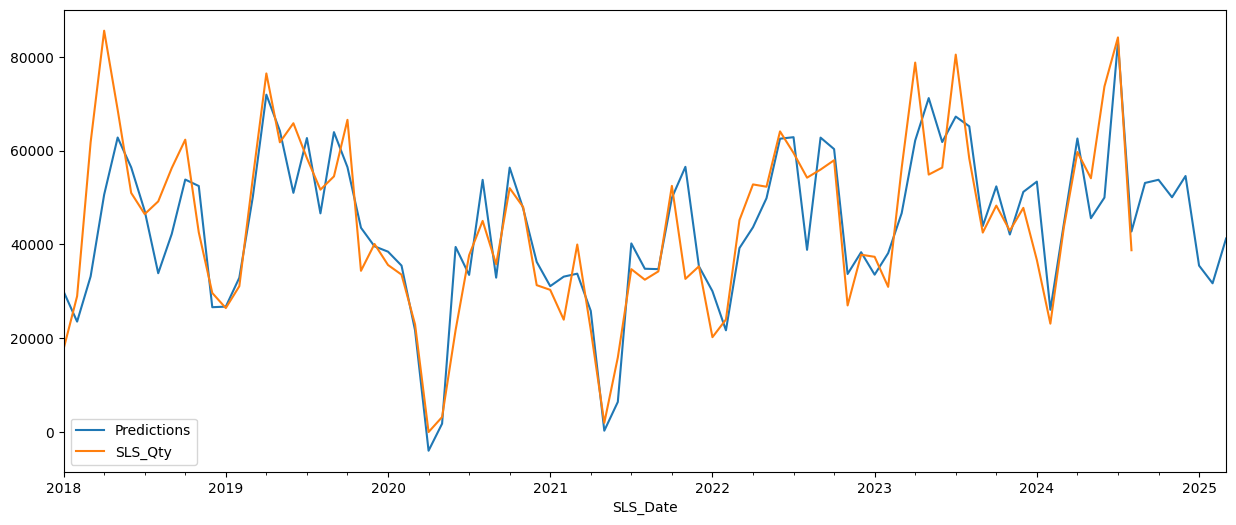

In [0]:
# plot predictions and actual values
predictions_df.plot(figsize=(15,6))
monthly_df['SLS_Qty'][:-7].plot(legend = True)

In [0]:
predictions_df['actual'] = monthly_df['SLS_Qty']
predictions_df['actual'] = predictions_df['actual'].fillna(0)
predictions_df['Predictions'] = np.round(predictions_df['Predictions'])
predictions_df['mape'] = (np.abs(predictions_df['actual']-predictions_df['Predictions'])/predictions_df['actual'])*100
predictions_df['mape'][-7:] = 0
predictions_df[-20:]

,Predictions,actual,mape
2023-08-31,65174.0,58310.0,11.771566
2023-09-30,43920.0,42522.0,3.287710
2023-10-31,52370.0,48269.0,8.496136
2023-11-30,42111.0,42915.0,1.873471
2023-12-31,51191.0,47787.0,7.123276
2024-01-31,53383.0,36683.0,45.525175
2024-02-29,26071.0,23102.0,12.851701
2024-03-31,44440.0,43661.0,1.784201
2024-04-30,62573.0,59697.0,4.817663
2024-05-31,45580.0,54098.0,15.745499


In [0]:
predictions_df[-12:-7]['mape'].mean()

12.817404169912166